<a href="https://colab.research.google.com/github/hzchzc123123/STOCK/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Environment

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import time
import torch
import torch.nn as nn
import torch.utils.data as Data


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import os
from pylab import rcParams

from numpy.random import normal, seed
from scipy.stats import norm
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

print("Setup Complete")

Setup Complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# https://drive.google.com/file/d/1ZWmbrvzpDfQAHb9eQcbTchs8Sa2QeVP1/view?usp=drive_link
id = "1ZWmbrvzpDfQAHb9eQcbTchs8Sa2QeVP1"
file = drive.CreateFile({'id':id})
file.GetContentFile('kaggle.json')
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d luisgilch/stock-data-with-industry-information
!unzip stock-data-with-industry-information.zip


stock-data-with-industry-information.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  stock-data-with-industry-information.zip
replace kaggle_stock_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: kaggle_stock_data.csv   
  inflating: kaggle_stock_sector_information.csv  
  inflating: stock_data.csv          
  inflating: stock_sector_information.csv  


# Data Exploration

## Dataset

In [ ]:
df_stock = pd.read_csv('kaggle_stock_data.csv')
df_stock

Unnamed: 0  Instrument                  Date  Price High  Price Close  \
0                0     CBKG.DE  2019-01-02T00:00:00Z       5.804        5.765   
1                1     CBKG.DE  2019-01-03T00:00:00Z       5.950        5.802   
2                2     CBKG.DE  2019-01-04T00:00:00Z       6.168        6.143   
3                3     CBKG.DE  2019-01-07T00:00:00Z       6.249        6.182   
4                4     CBKG.DE  2019-01-08T00:00:00Z       6.390        6.330   
...            ...         ...                   ...         ...          ...   
501620      501620  PNHO.S^F22  2022-06-29T00:00:00Z      52.400       51.600   
501621      501621  PNHO.S^F22  2022-06-29T00:00:00Z      52.400       51.600   
501622      501622  PNHO.S^F22  2022-06-29T00:00:00Z      52.400       51.600   
501623      501623  PNHO.S^F22  2022-06-29T00:00:00Z      52.400       51.600   
501624      501624  PNHO.S^F22  2022-06-29T00:00:00Z      52.400       51.600   

        Price Open     Volume  
0            5.782  7221471.0  
1            5.748  8064658.0  
2            5.890  8772521.0  
3            6.242  6781840.0  
4            6.172  8472530.0  
...            ...        ...  
501620      52.400        0.0  
501621      52.400        0.0  
501622      52.400        0.0  
501623      52.400        0.0  
501624      52.400        0.0  

[501625 rows x 7 columns]

In [ ]:
df_stock = df_stock.drop(df_stock.columns[0],axis=1)
df_stock = df_stock.drop_duplicates()
df_stock['Instrument'].value_counts()

NMIG.D          1207
REIT.LU         1207
ETEG.D          1207
SSSG.D          1207
AIR.PA          1207
                ... 
EIC.S             99
3D6.DE            84
DISG.SG^F23       68
BC.S^D19          61
GSKGn.DE^D11       1
Name: Instrument, Length: 408, dtype: int64

In [ ]:
df_stock = df_stock[df_stock['Instrument']=='AIR.PA'].drop(df_stock.columns[[0]],axis=1)

# 将 "Date" 列解析为日期时间格式，以确保日期显示为 "年-月-日" 格式
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# 将 "Date" 列设置为索引
df_stock.set_index('Date', inplace=True)

In [ ]:
df_stock

Price High  Price Close  Price Open     Volume
Date                                                                     
2019-01-02 00:00:00+00:00       84.45        84.17       83.58  1483033.0
2019-01-03 00:00:00+00:00       83.75        81.21       83.33  1964509.0
2019-01-04 00:00:00+00:00       85.52        85.12       82.16  2006859.0
2019-01-07 00:00:00+00:00       86.95        83.56       85.96  1428948.0
2019-01-08 00:00:00+00:00       88.61        86.65       83.83  2533915.0
...                               ...          ...         ...        ...
2023-09-07 00:00:00+00:00      137.20       136.42      133.80   869871.0
2023-09-08 00:00:00+00:00      136.62       135.44      136.48   839474.0
2023-09-11 00:00:00+00:00      136.00       133.66      135.98  1391017.0
2023-09-12 00:00:00+00:00      133.84       130.48      133.72  1333446.0
2023-09-13 00:00:00+00:00      131.12       130.52      130.44   842987.0

[1207 rows x 4 columns]

In [ ]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2019-01-02 00:00:00+00:00 to 2023-09-13 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price High   1207 non-null   float64
 1   Price Close  1207 non-null   float64
 2   Price Open   1207 non-null   float64
 3   Volume       1207 non-null   float64
dtypes: float64(4)
memory usage: 47.1 KB


In [ ]:
df_stock.isnull().sum()

Price High     0
Price Close    0
Price Open     0
Volume         0
dtype: int64

## EDA

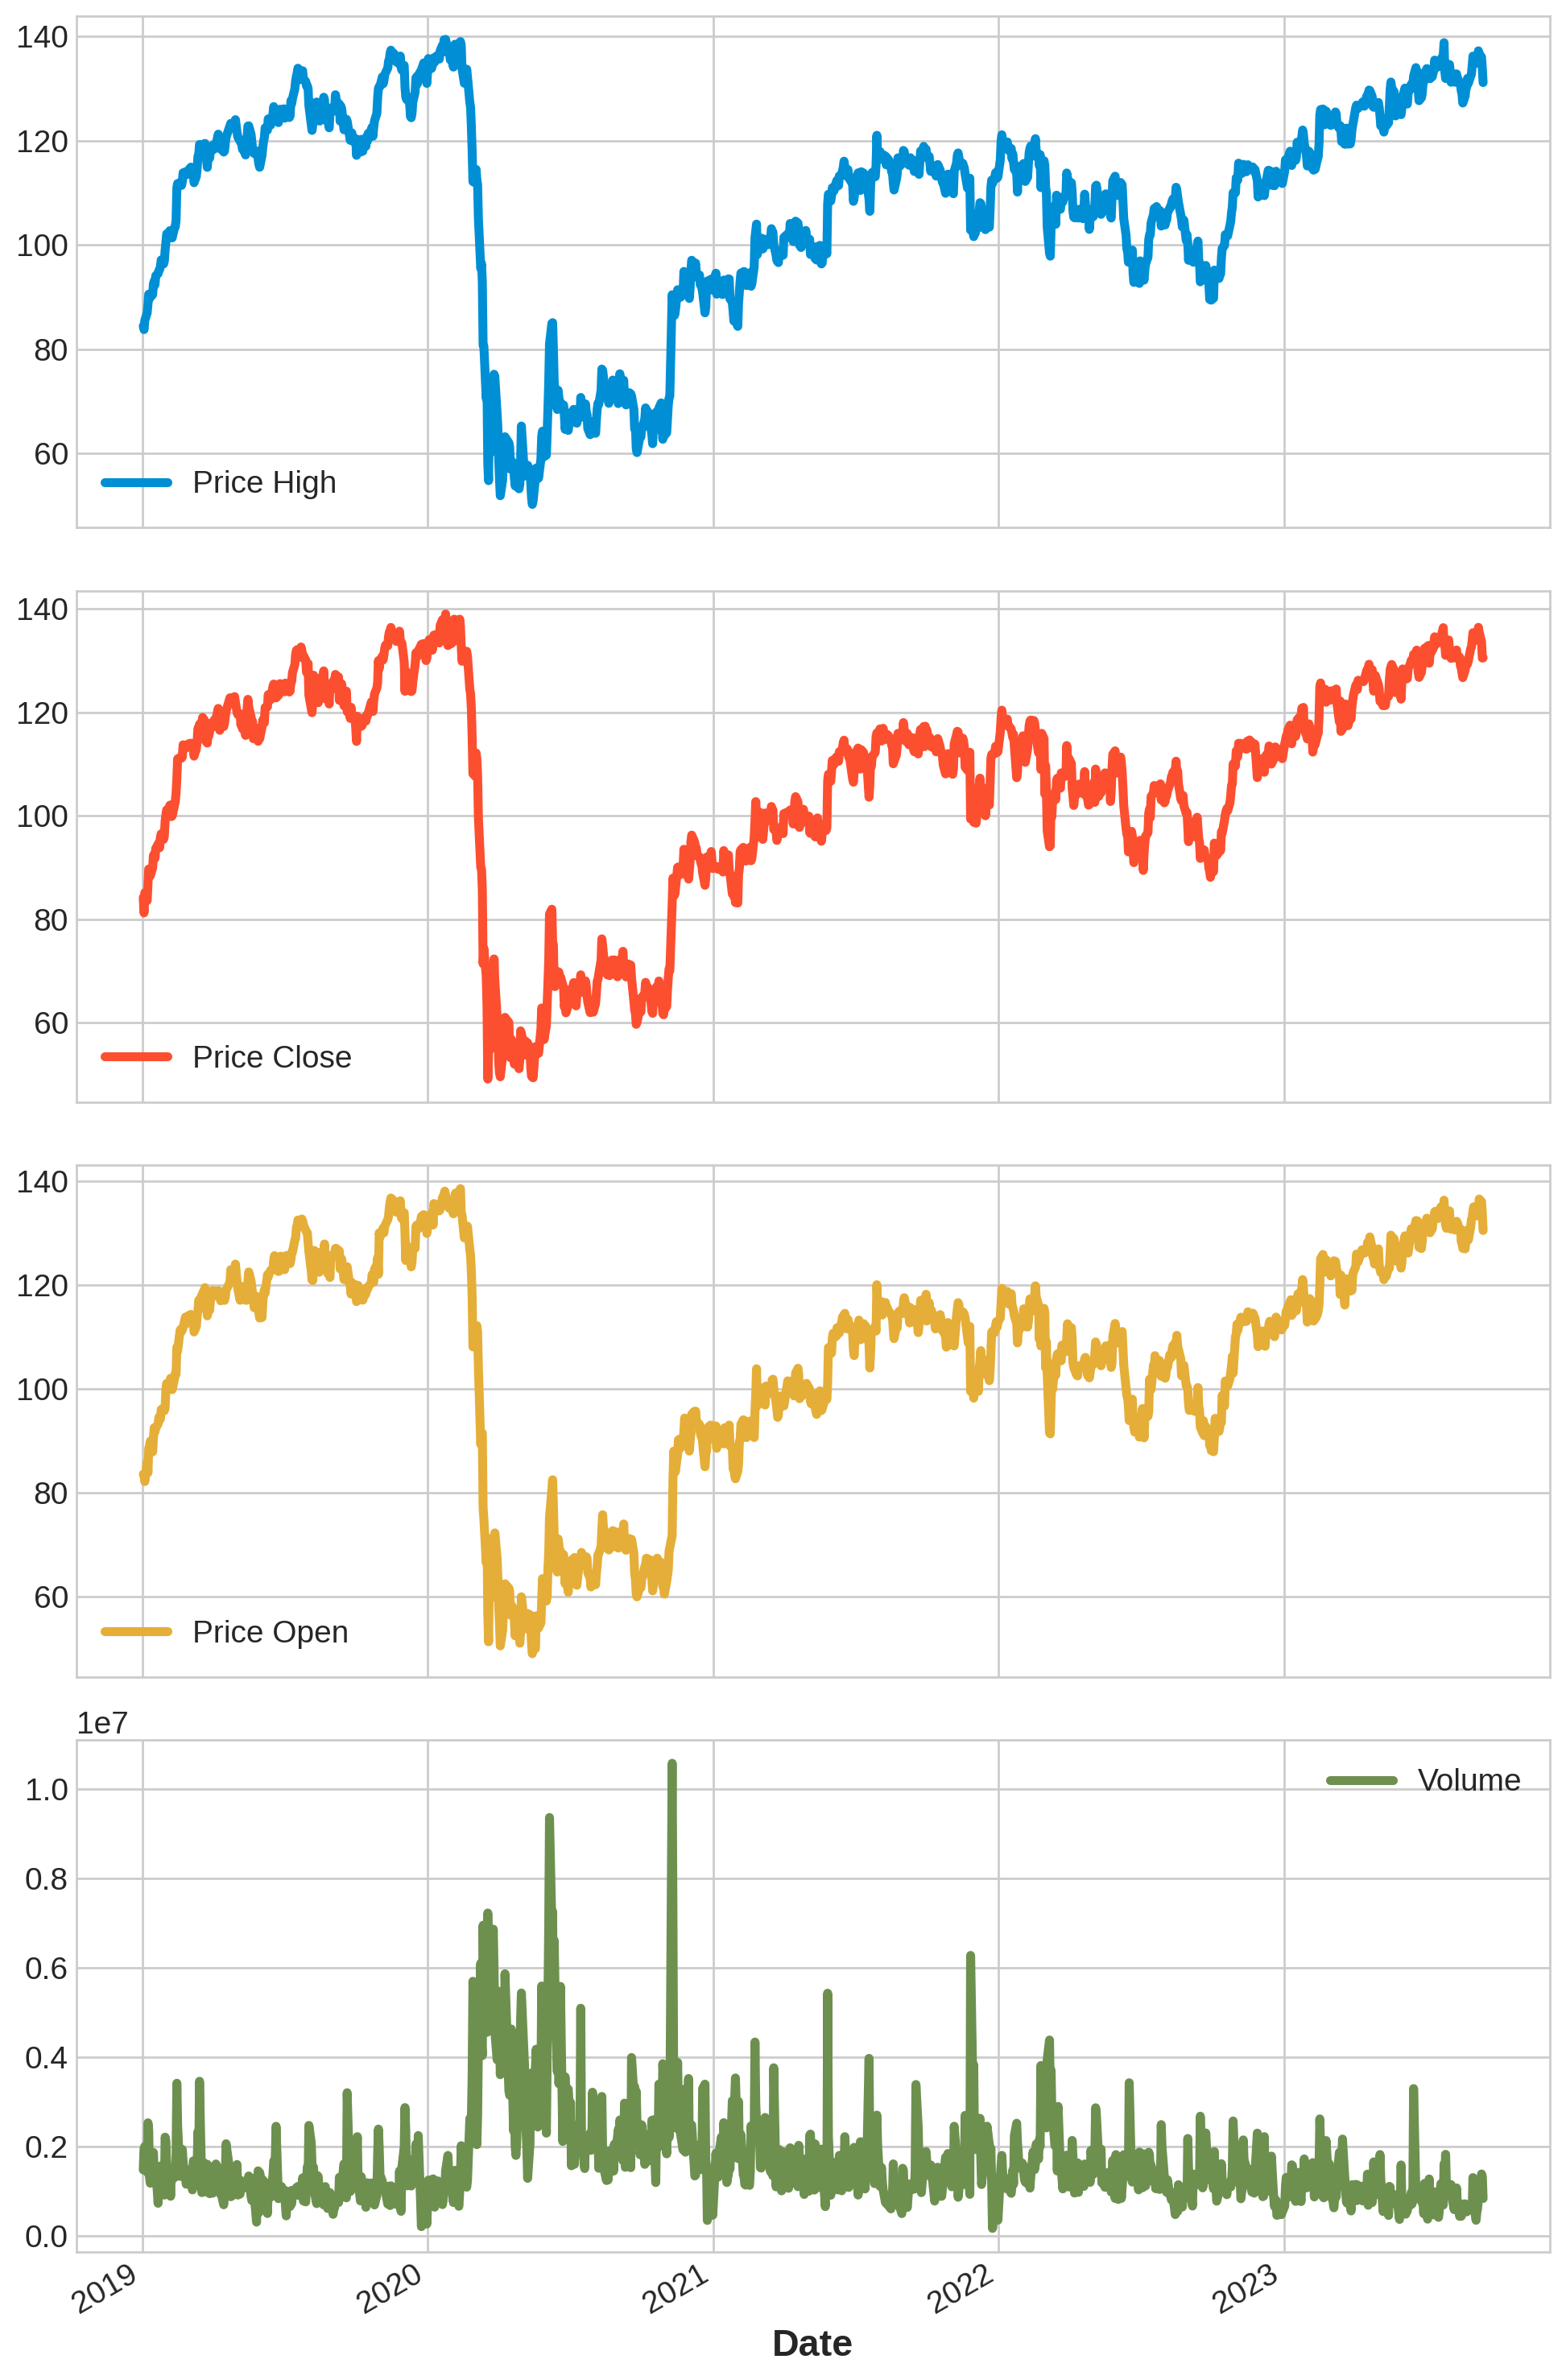

In [ ]:
df_stock.plot(subplots=True, figsize=(10,15))
plt.show()

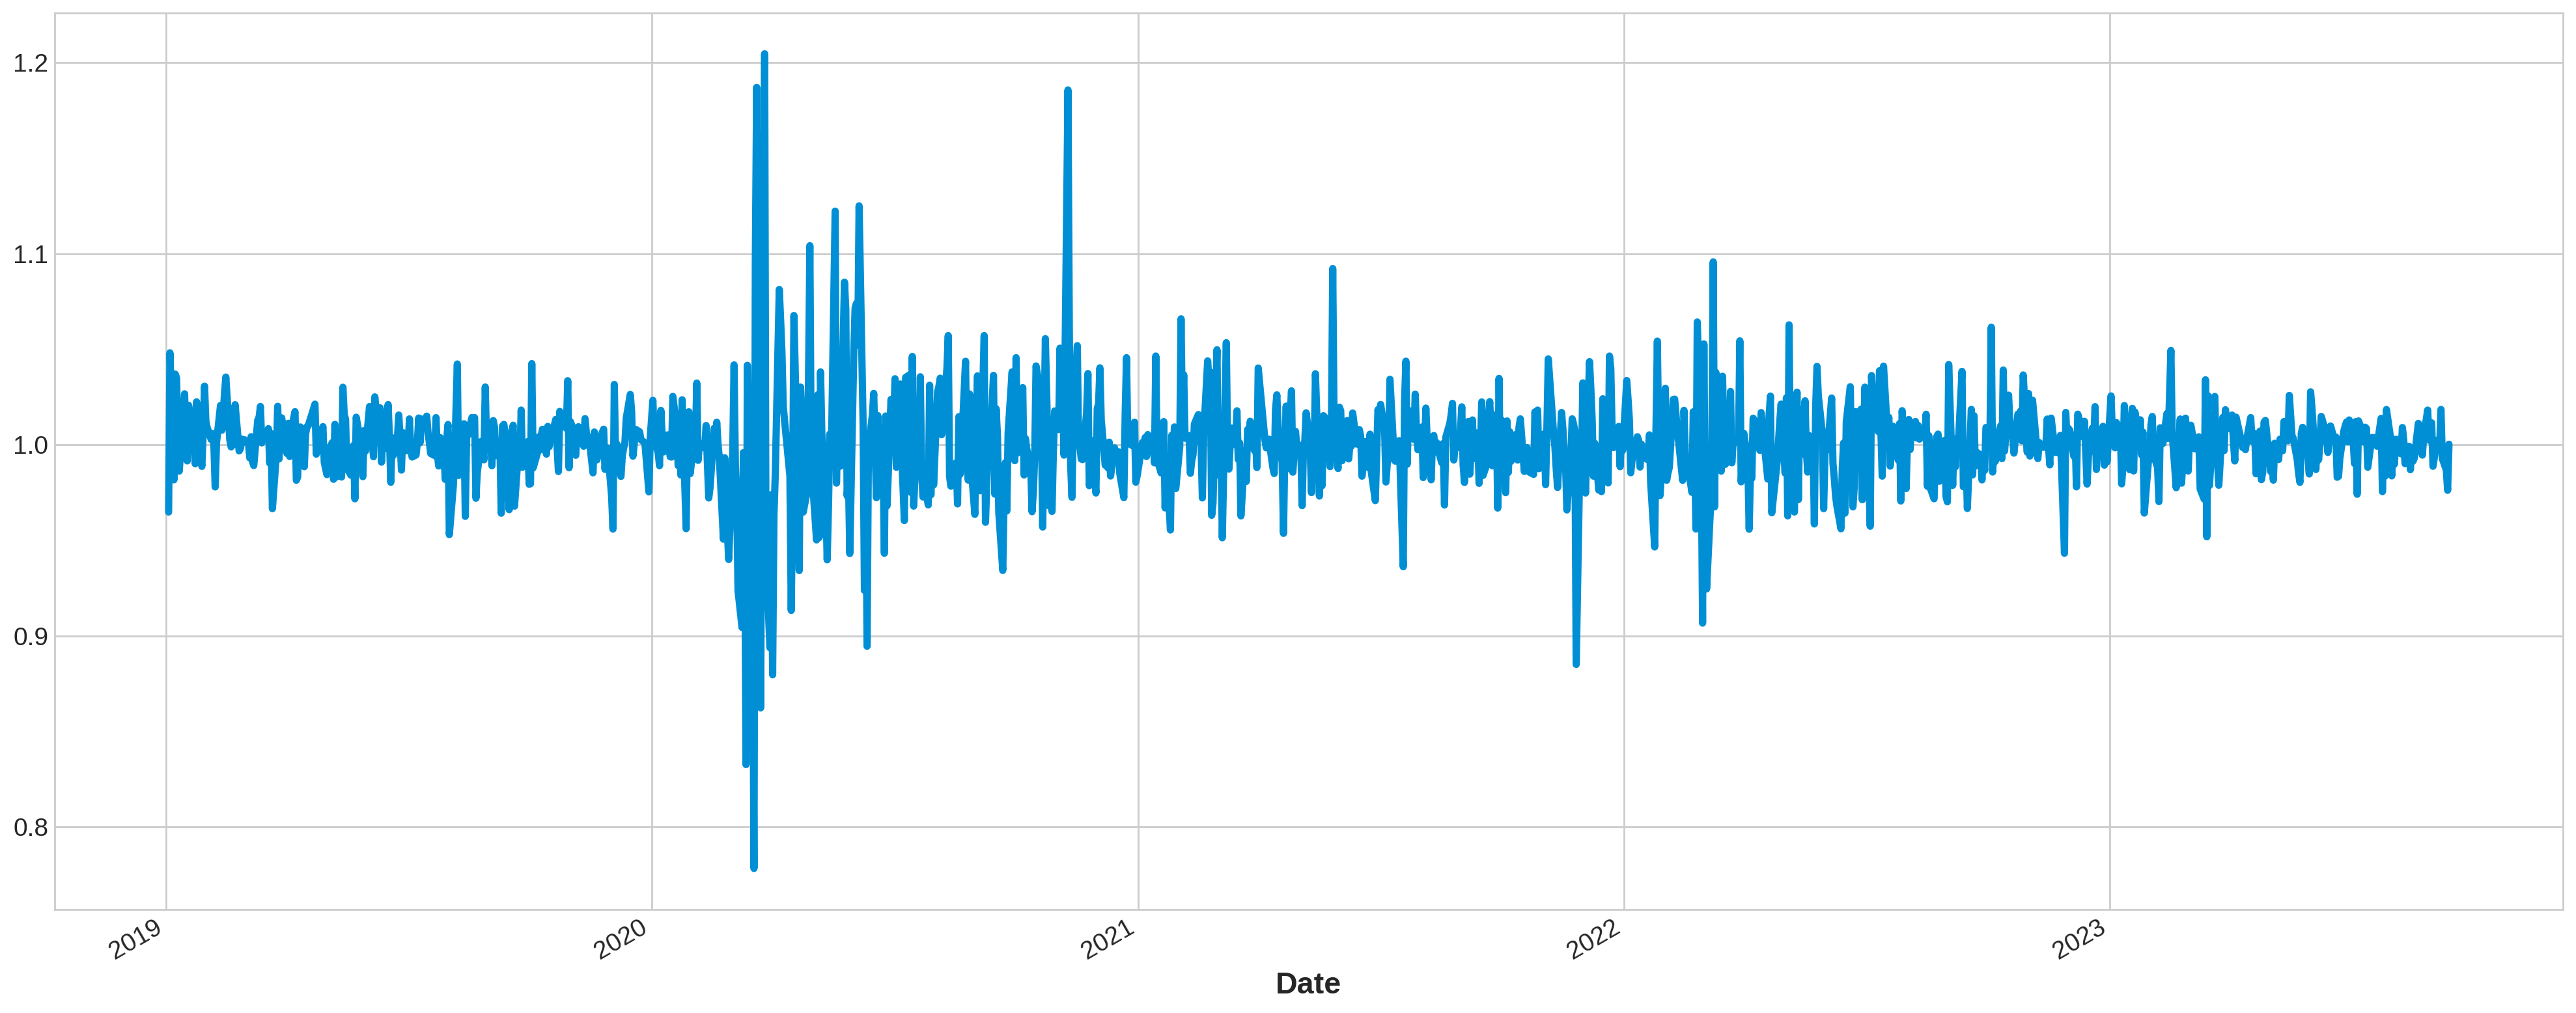

In [ ]:
df_stock['Change'] = df_stock['Price Close'].div(df_stock['Price Close'].shift())
df_stock['Change'].plot(figsize=(20,8))
plt.show()

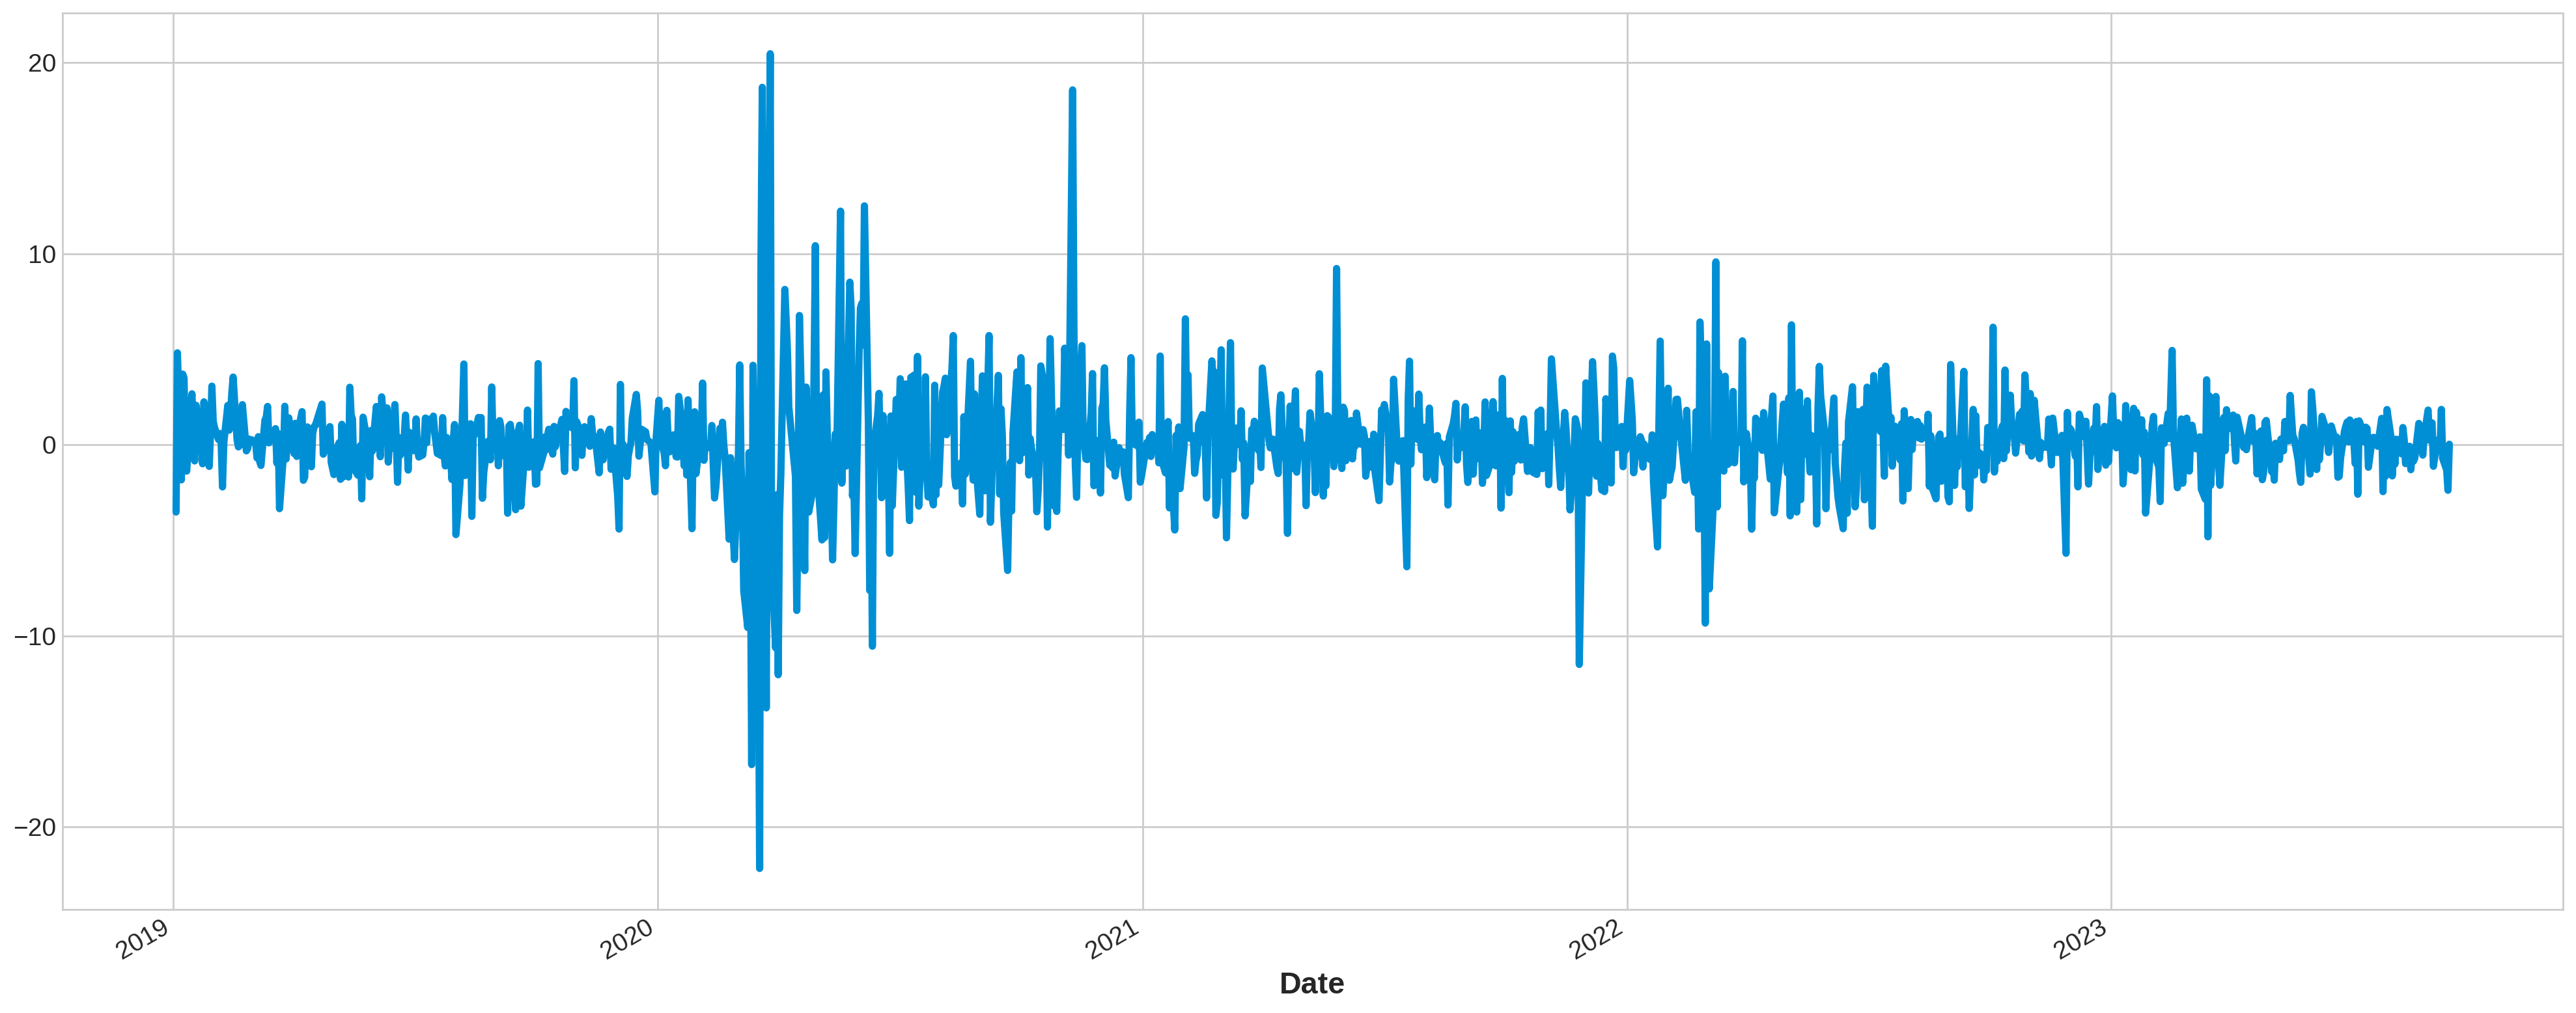

In [ ]:
df_stock['Return'] = df_stock['Change'].sub(1).mul(100)
df_stock['Return'].plot(figsize=(20,8))
plt.show()

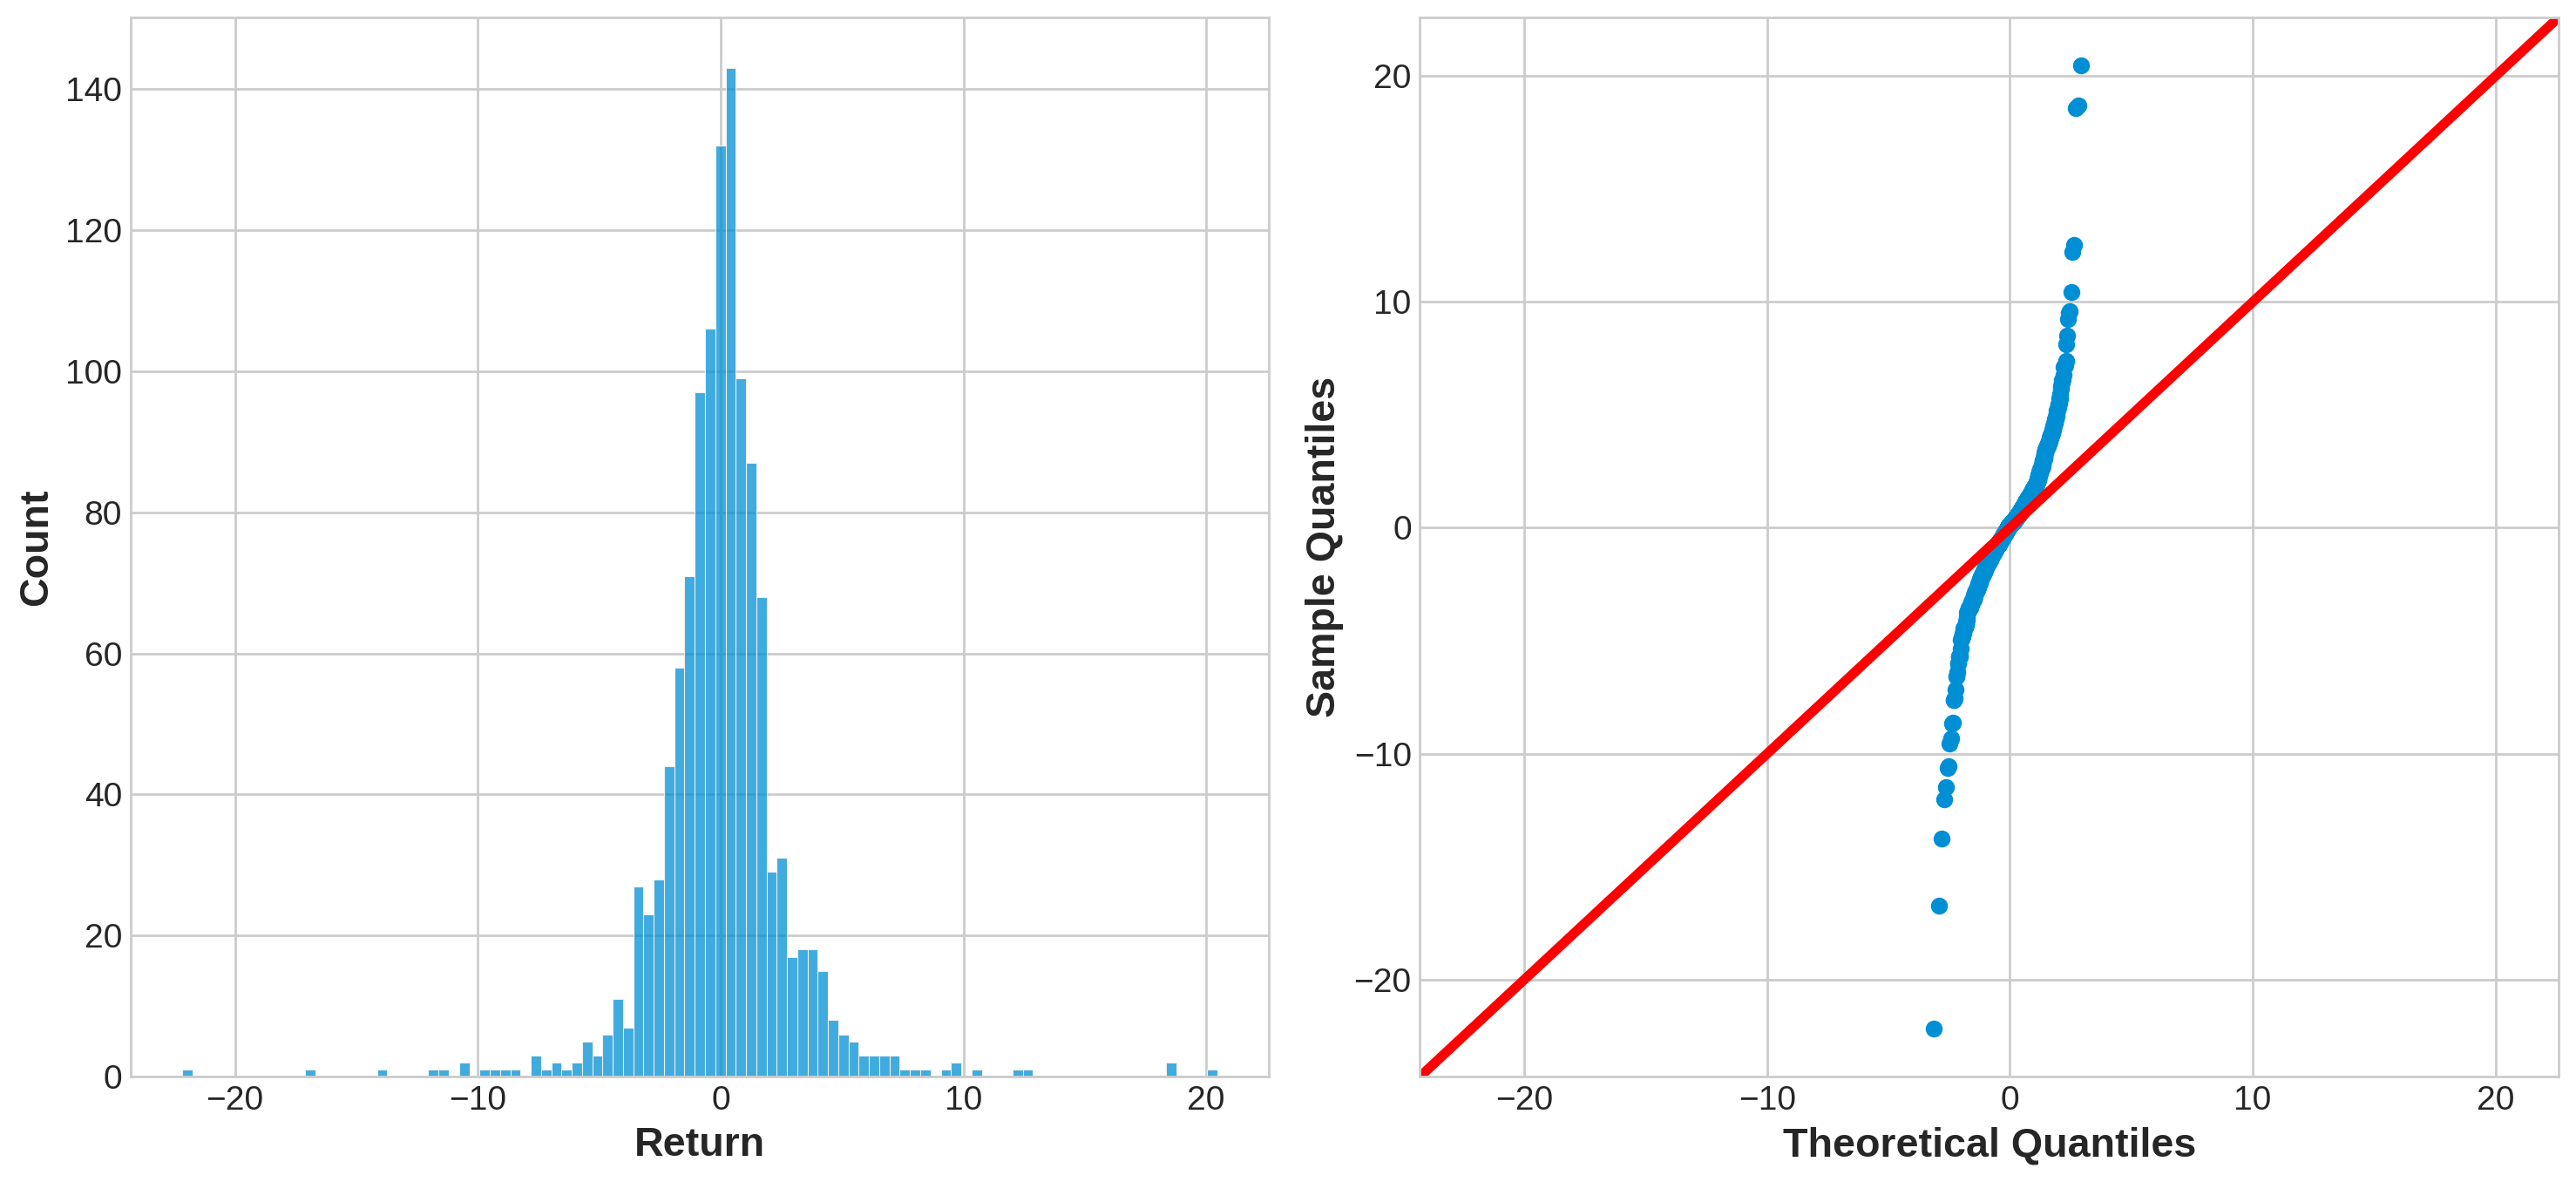

In [ ]:
fig,axss = plt.subplots(1, 2, figsize=[15,7])
sns.histplot(x='Return', data=df_stock, ax=axss[0])
sm.qqplot(df_stock['Return'], line='45', ax=axss[1])

# fig = sm.qqplot(df_stock['Return'], line='45')
plt.show()

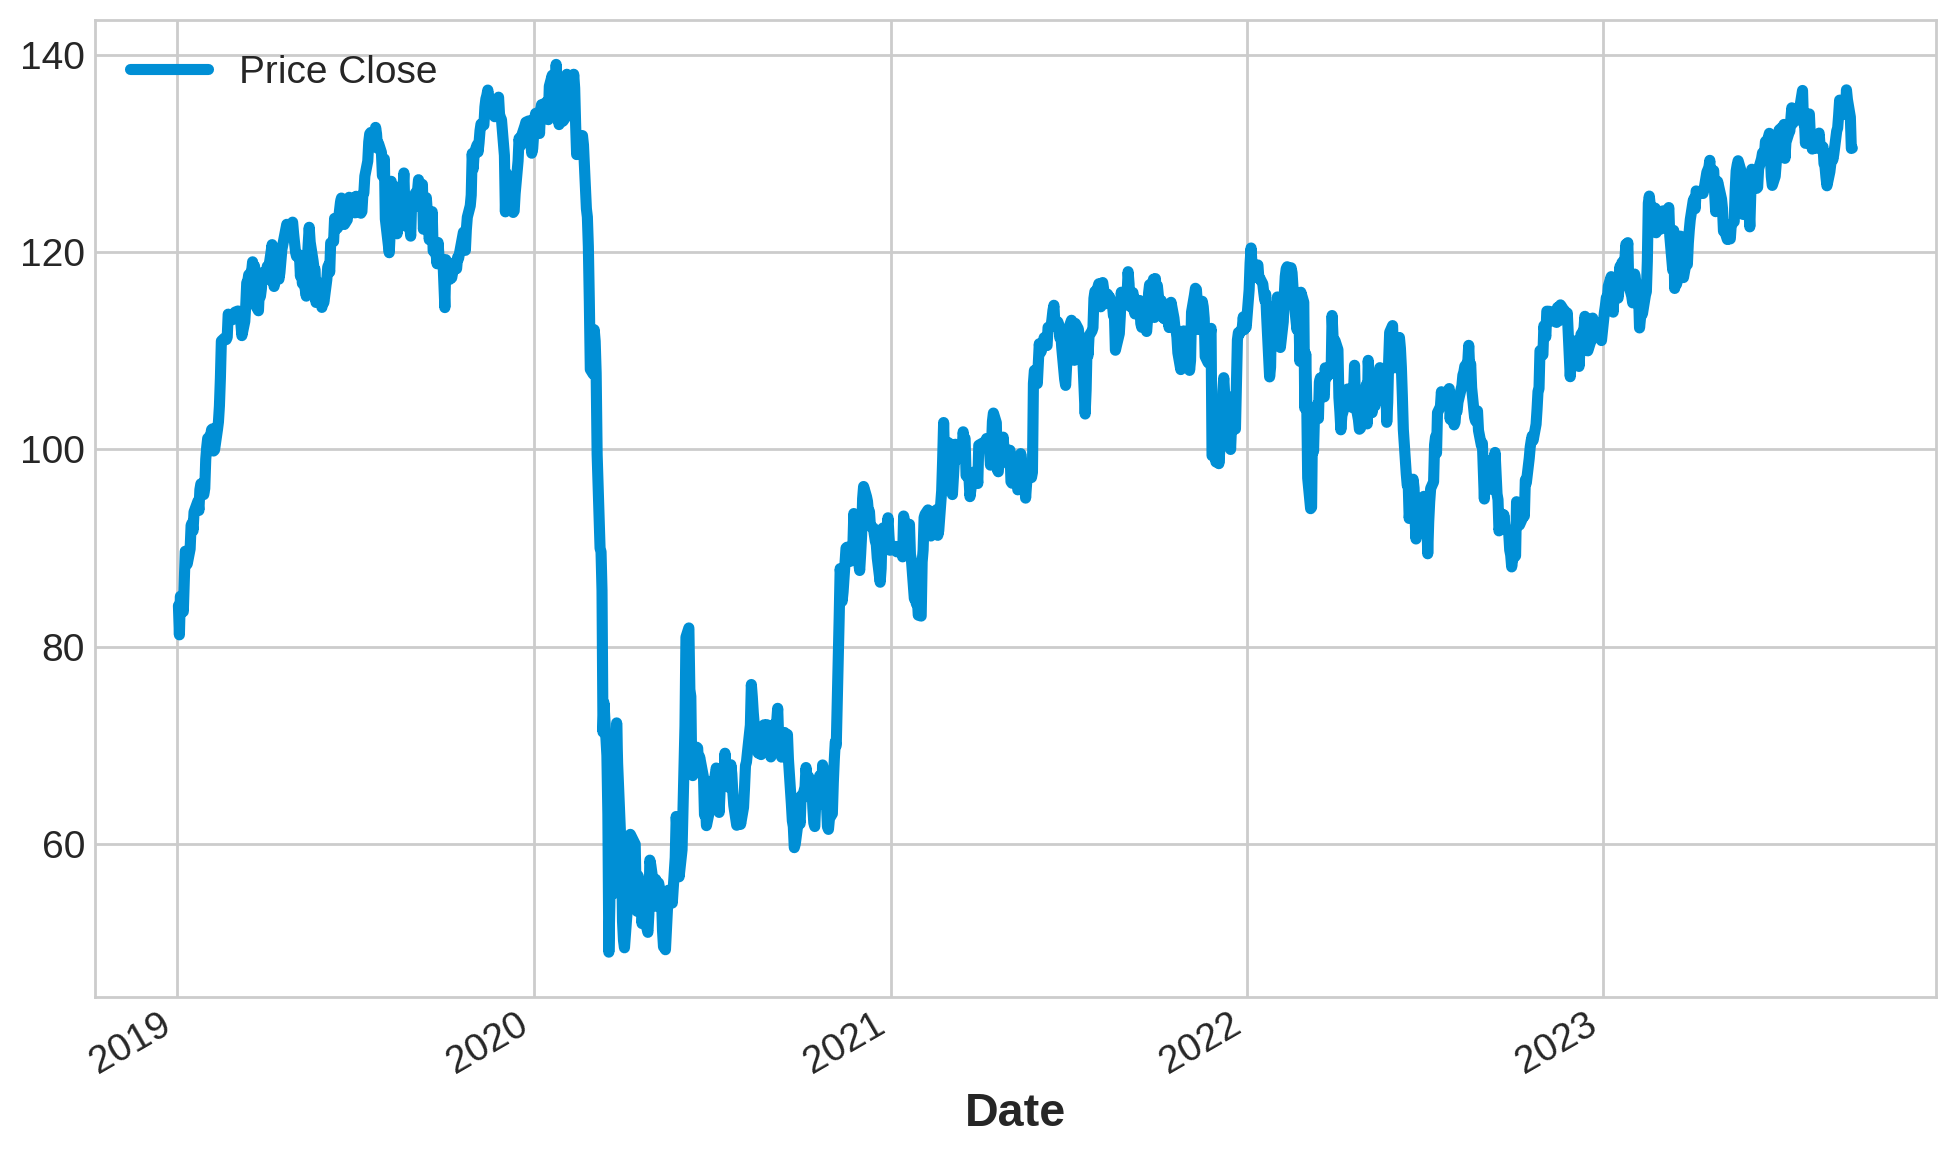

In [ ]:
plt.figure(figsize=(10,6))
df_stock['Price Close'].plot()
# df_stock['Price High'].plot()
plt.legend(loc='best')
plt.show()

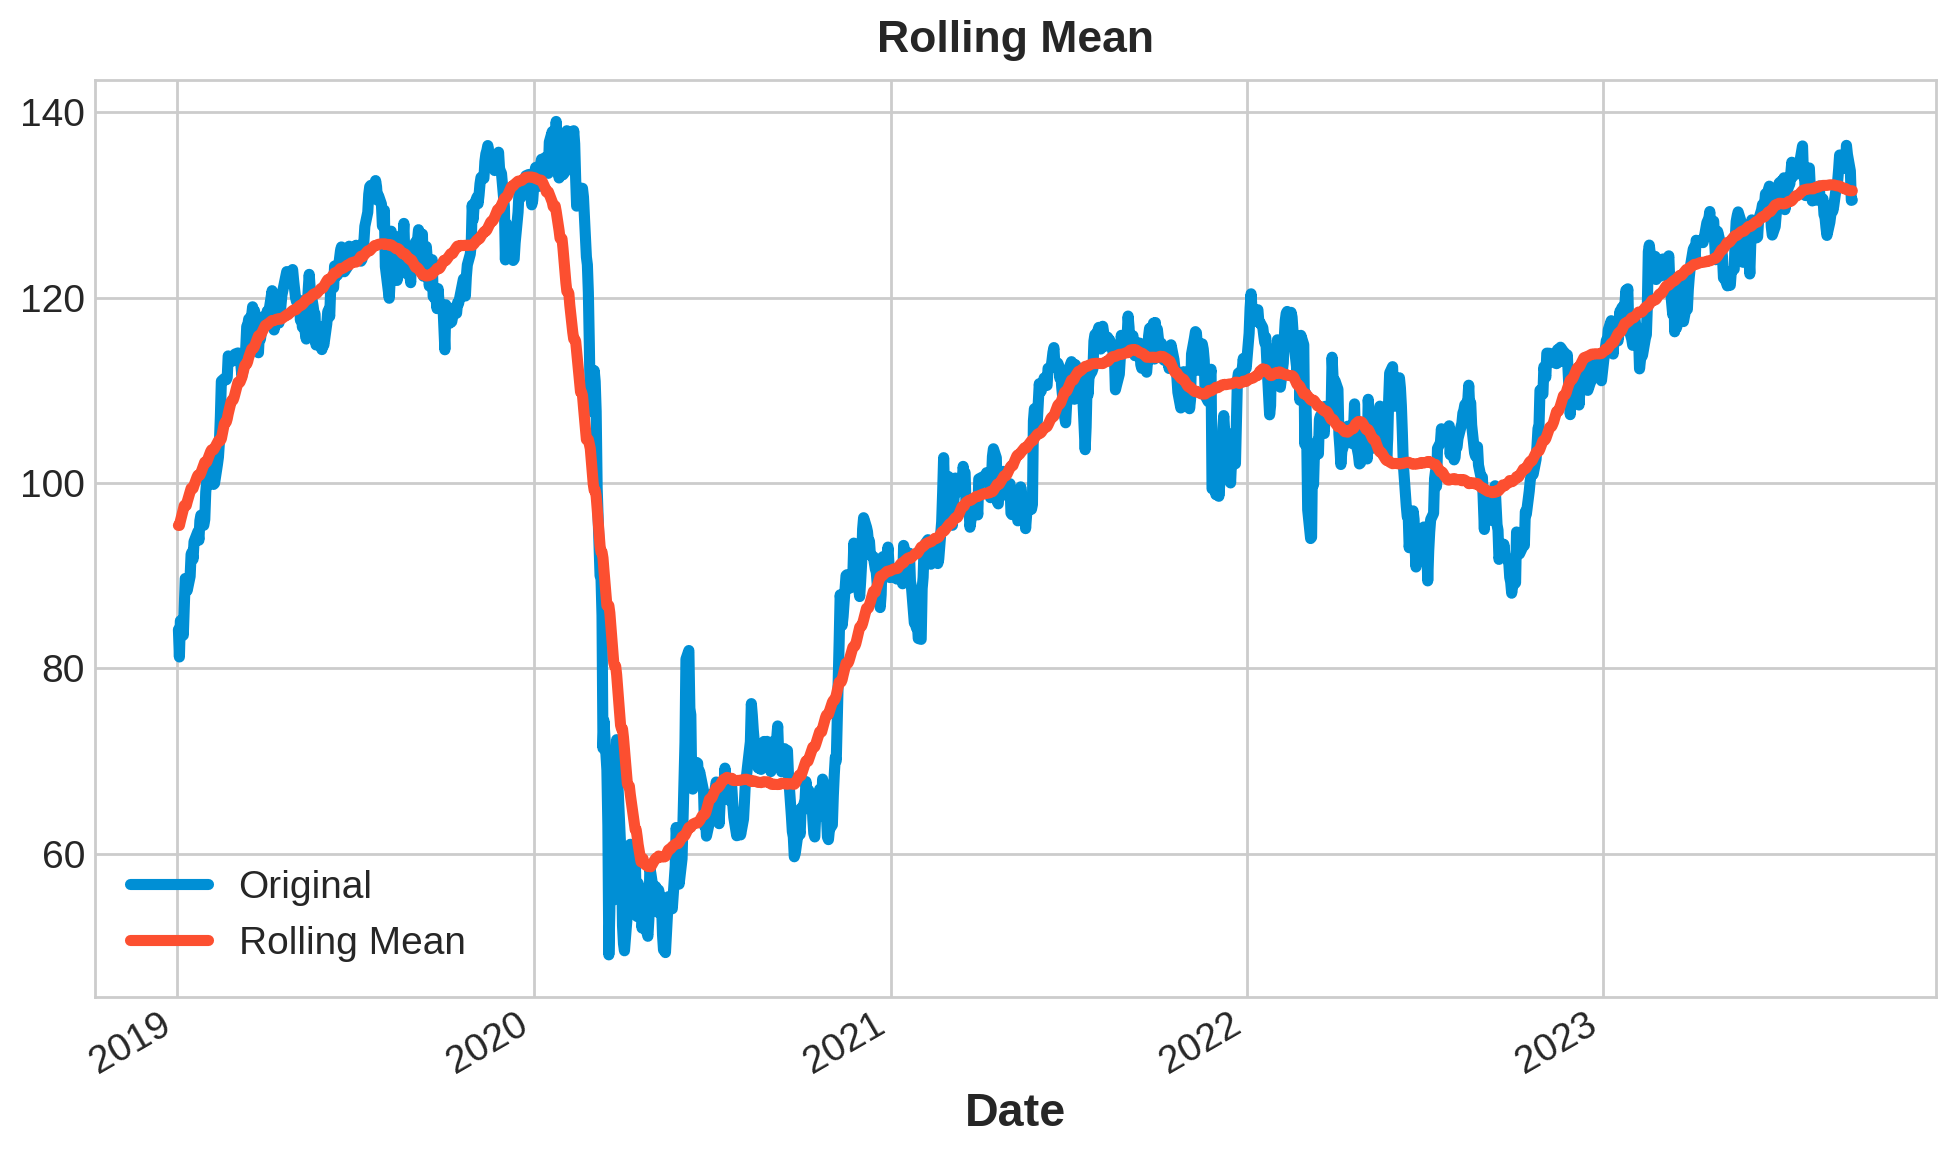

In [ ]:
y = df_stock['Price Close'].copy()
plt.figure(figsize=(10,6))
rolling_mean = y.rolling(window='90D',center=True).mean()
y.plot()
rolling_mean.plot()

plt.legend(['Original','Rolling Mean'])
plt.title('Rolling Mean')
plt.show()

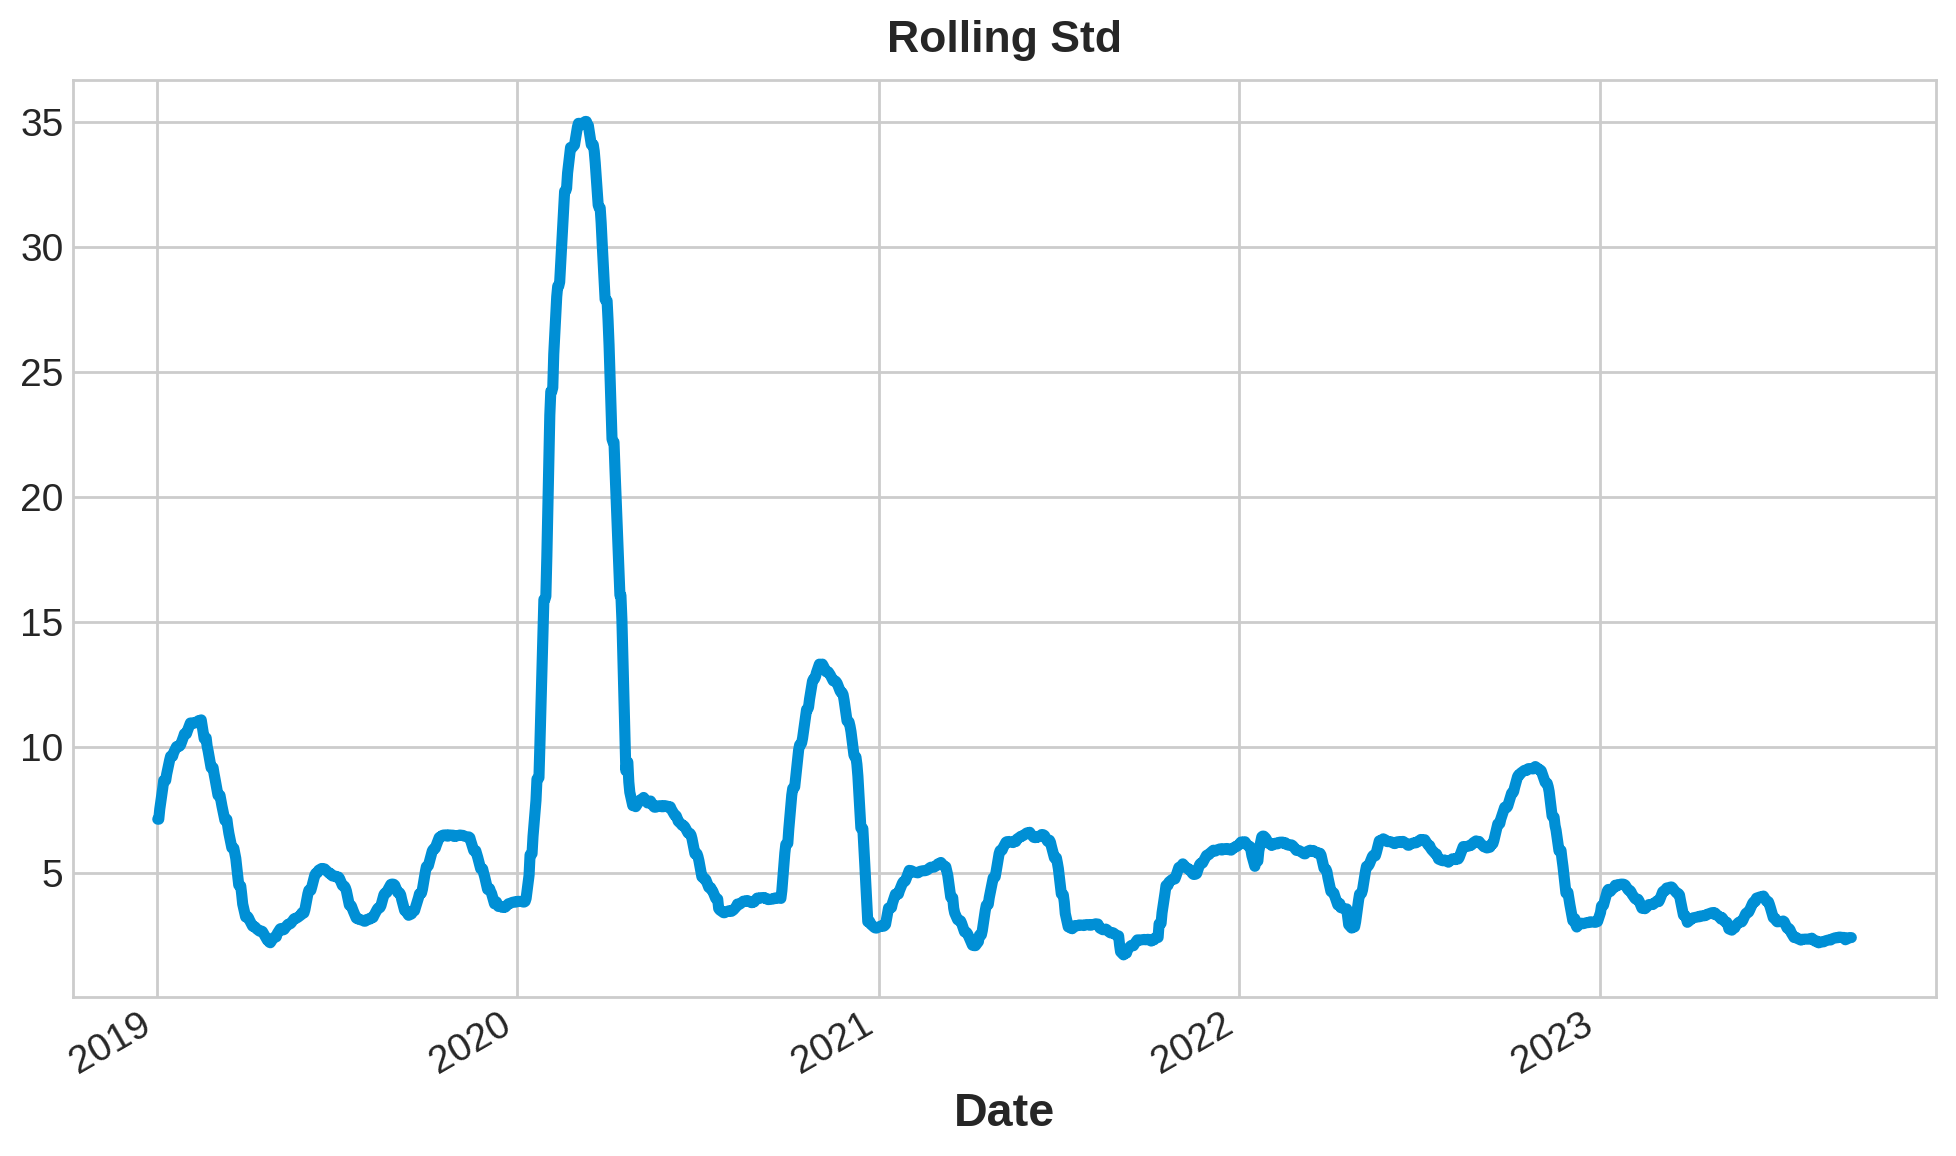

In [ ]:
plt.figure(figsize=(10,6))
rolling_std = y.rolling(window='90D',center=True).std()
rolling_std.plot()
plt.title('Rolling Std')
plt.show()

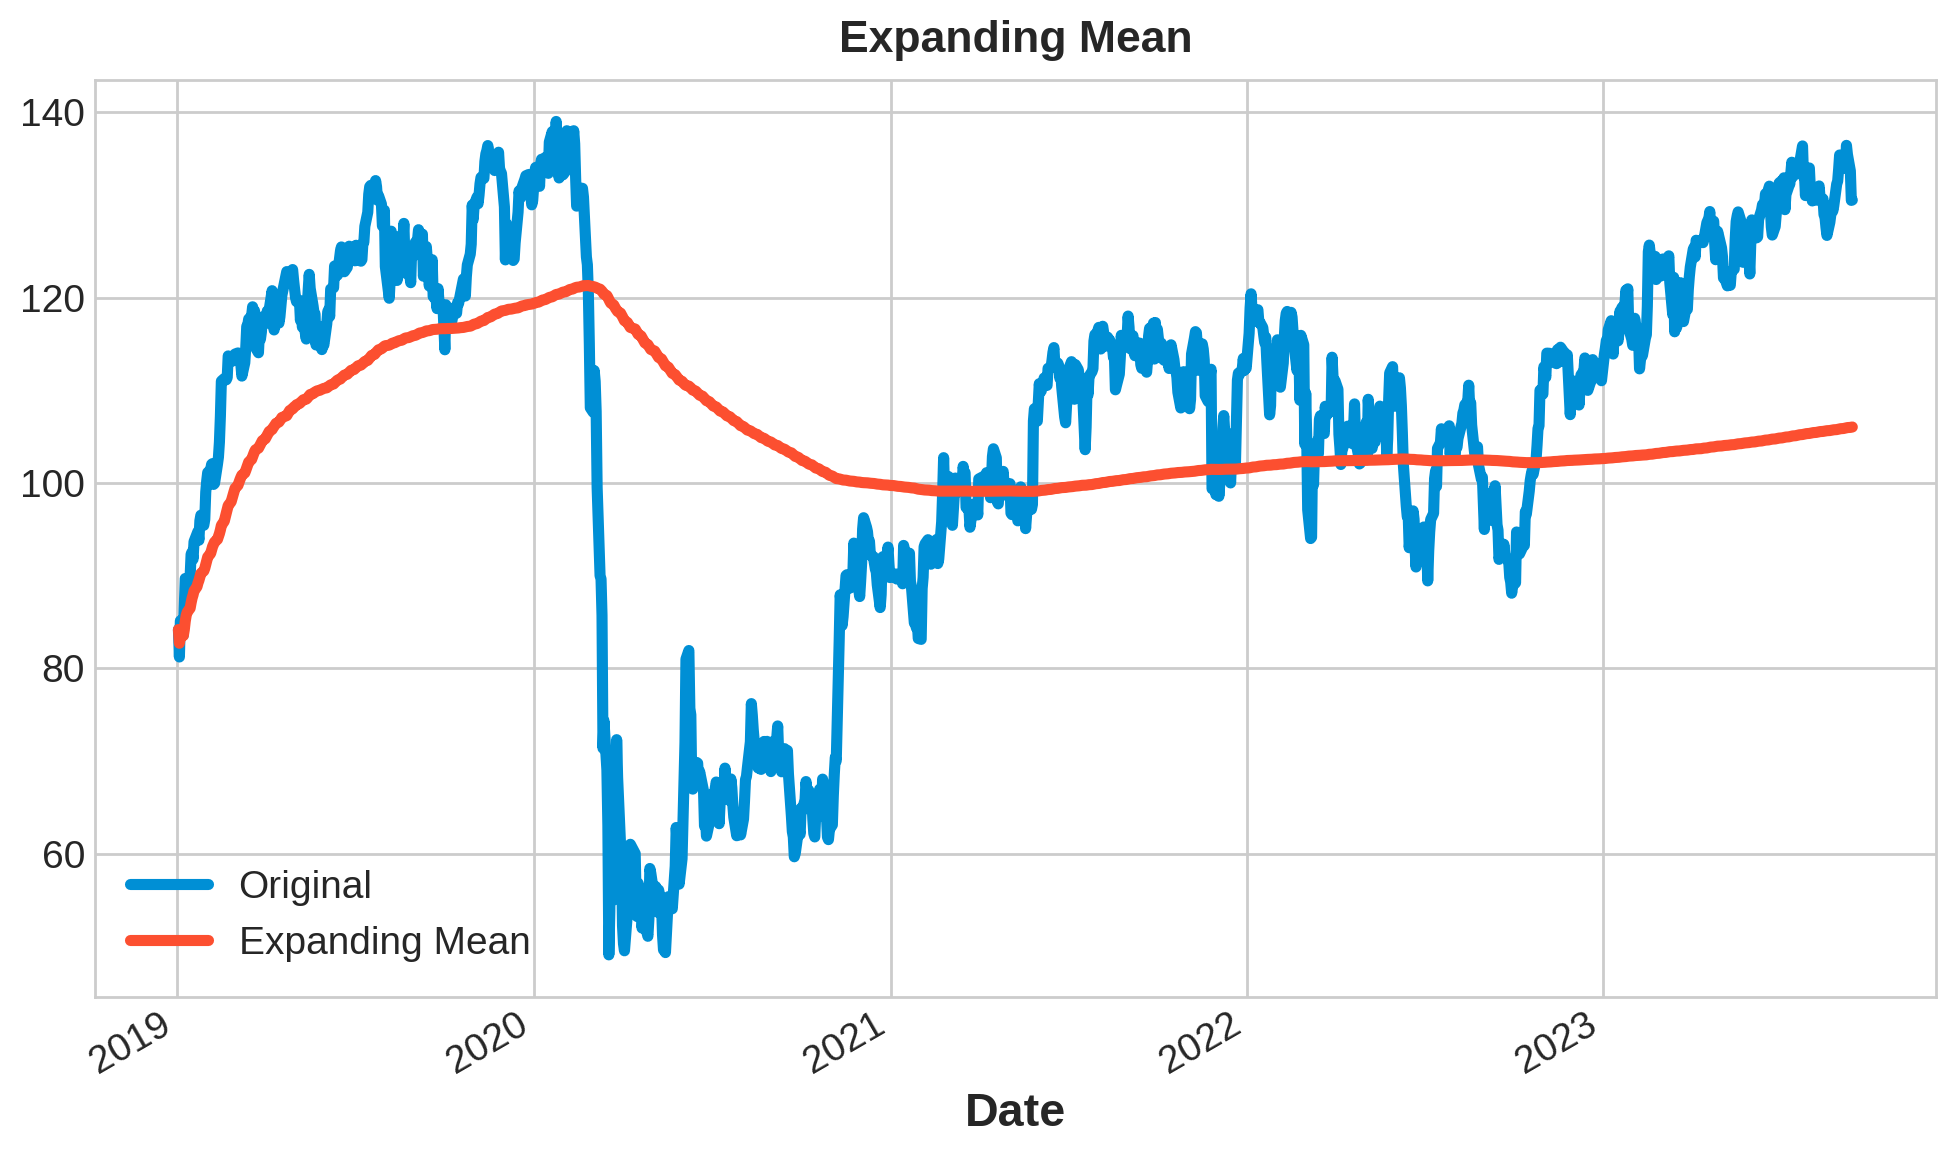

In [ ]:
plt.figure(figsize=(10,6))
expanding_mean = y.expanding().mean()
y.plot()
expanding_mean.plot()
plt.title('Expanding Mean')
plt.legend(['Original','Expanding Mean'])
plt.show()

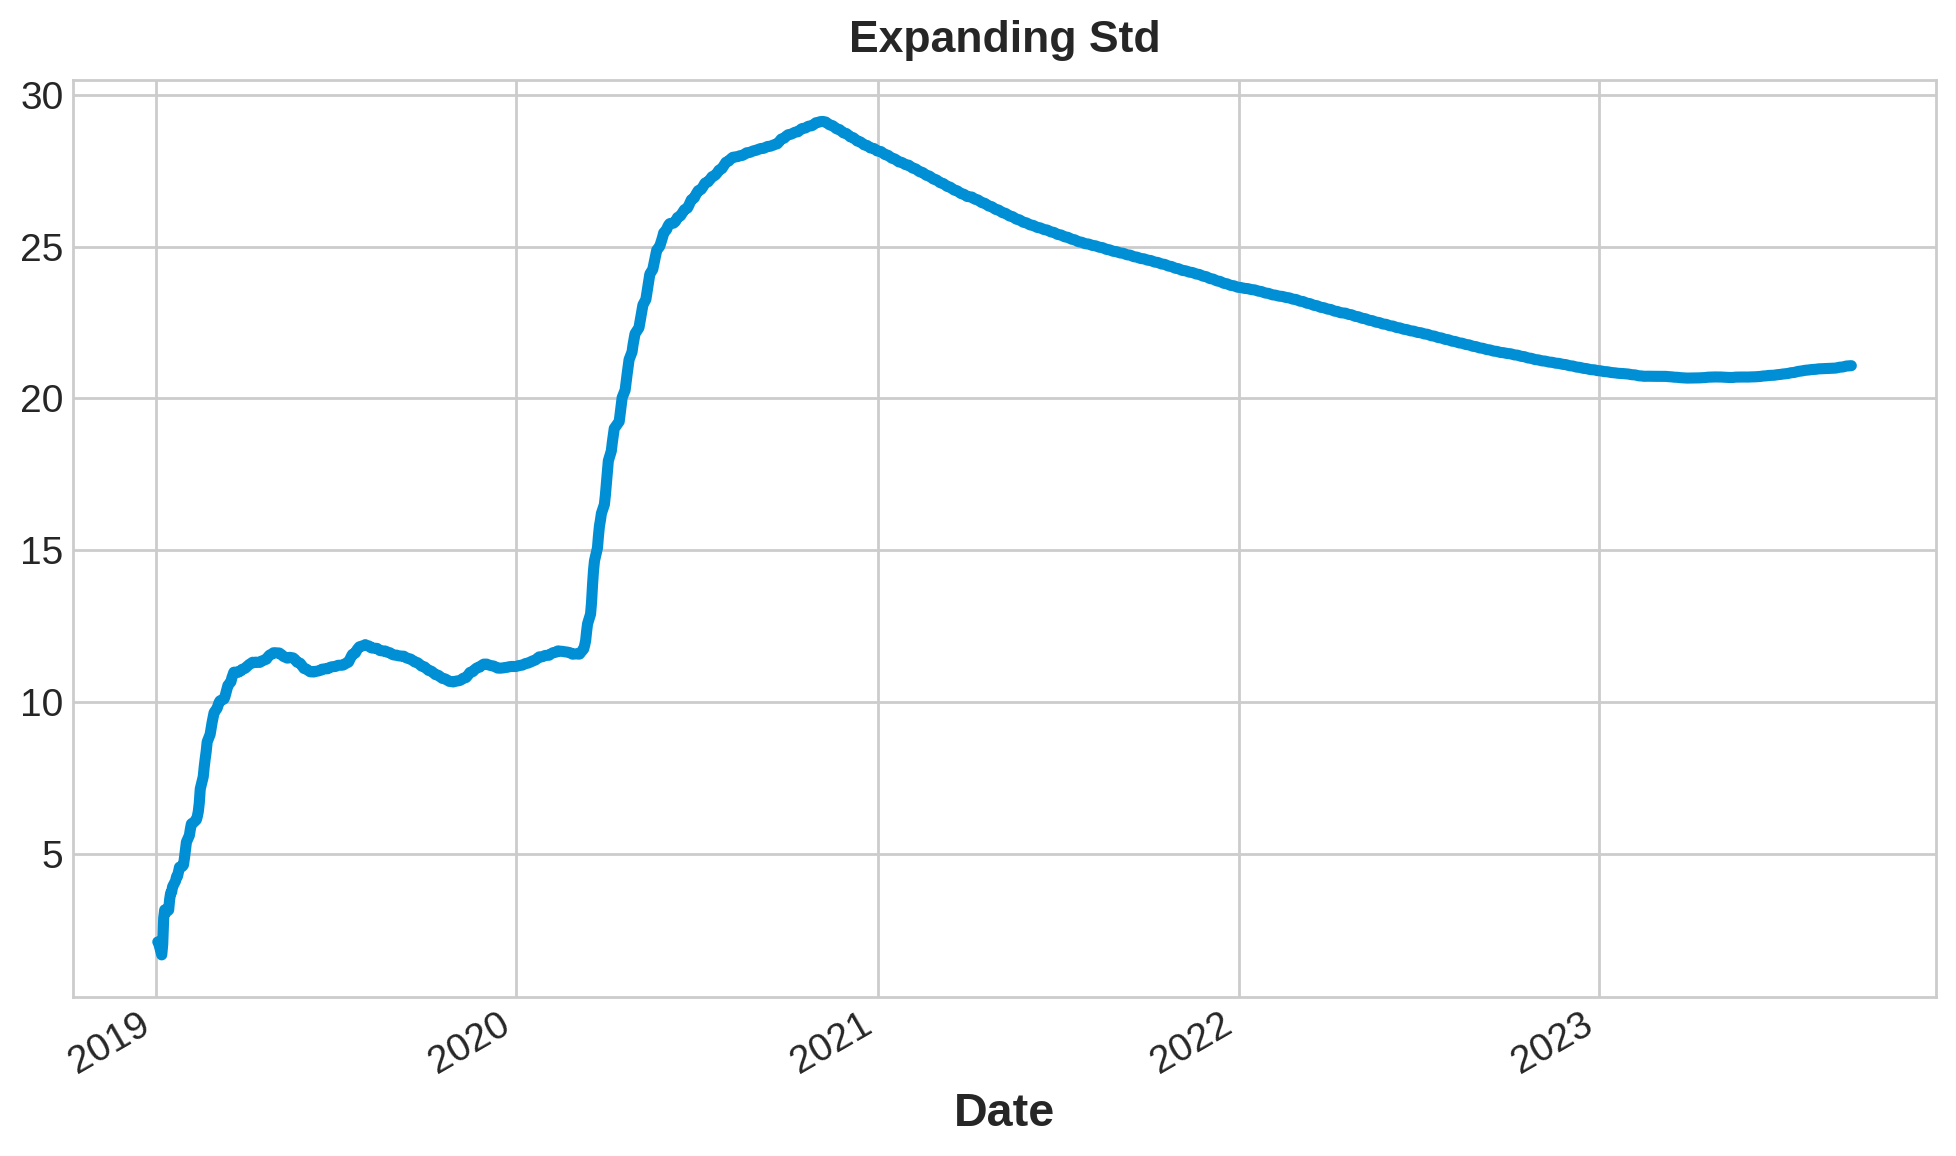

In [ ]:
plt.figure(figsize=(10,6))
expanding_std = y.expanding().std()
expanding_std.plot()
plt.title('Expanding Std')
plt.show()

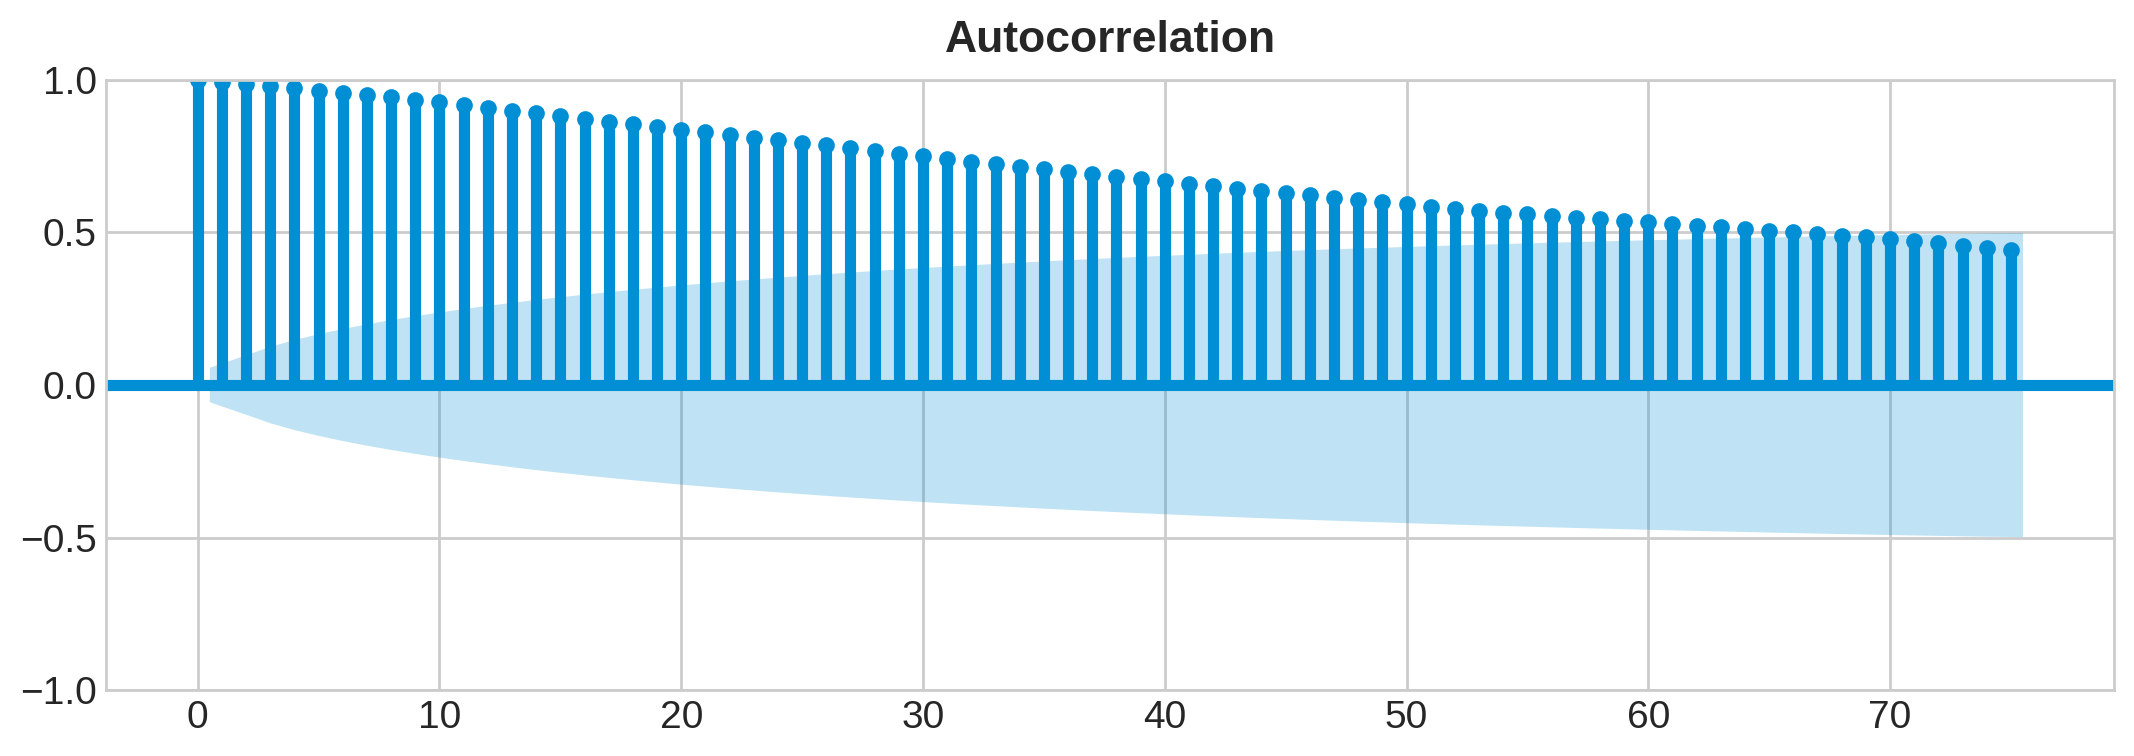

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plt.figure(figsize=(10,6))
plot_acf(y,lags=75)
plt.show()

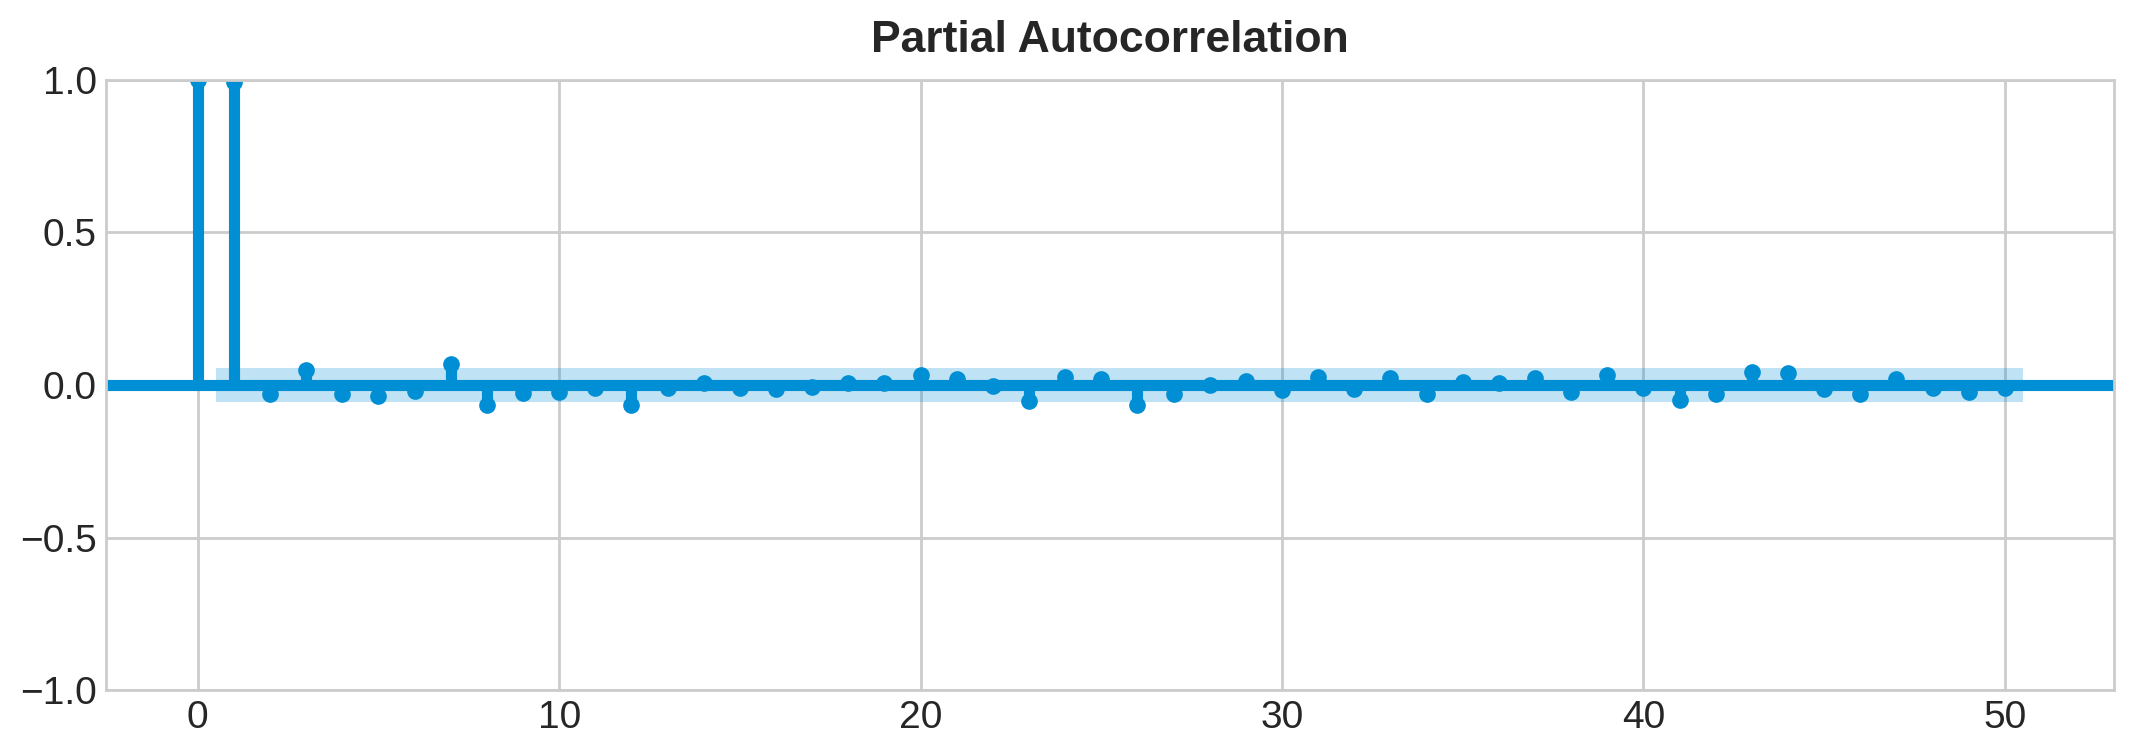

In [ ]:
plot_pacf(y,lags=50)
plt.show()

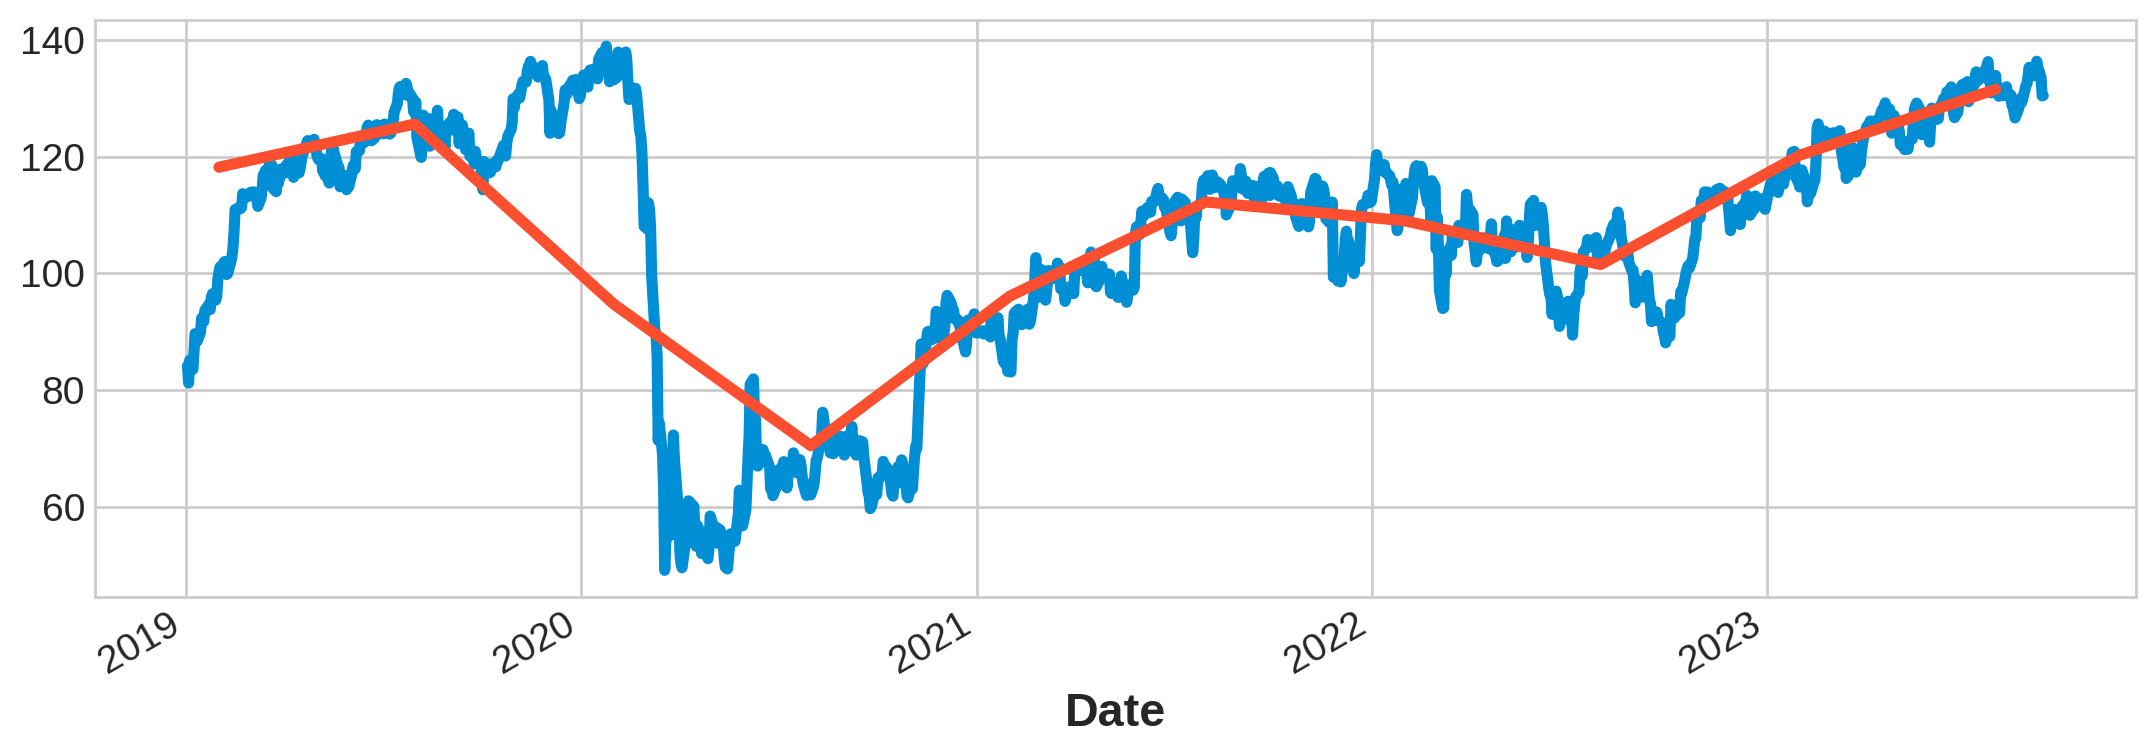

In [ ]:
df_stock['Price Close'].plot()
df_stock['Price Close'].shift(-90).resample('6M').mean().plot()
plt.show()

# Data Cleaning and Feature Analysis

## Data Description

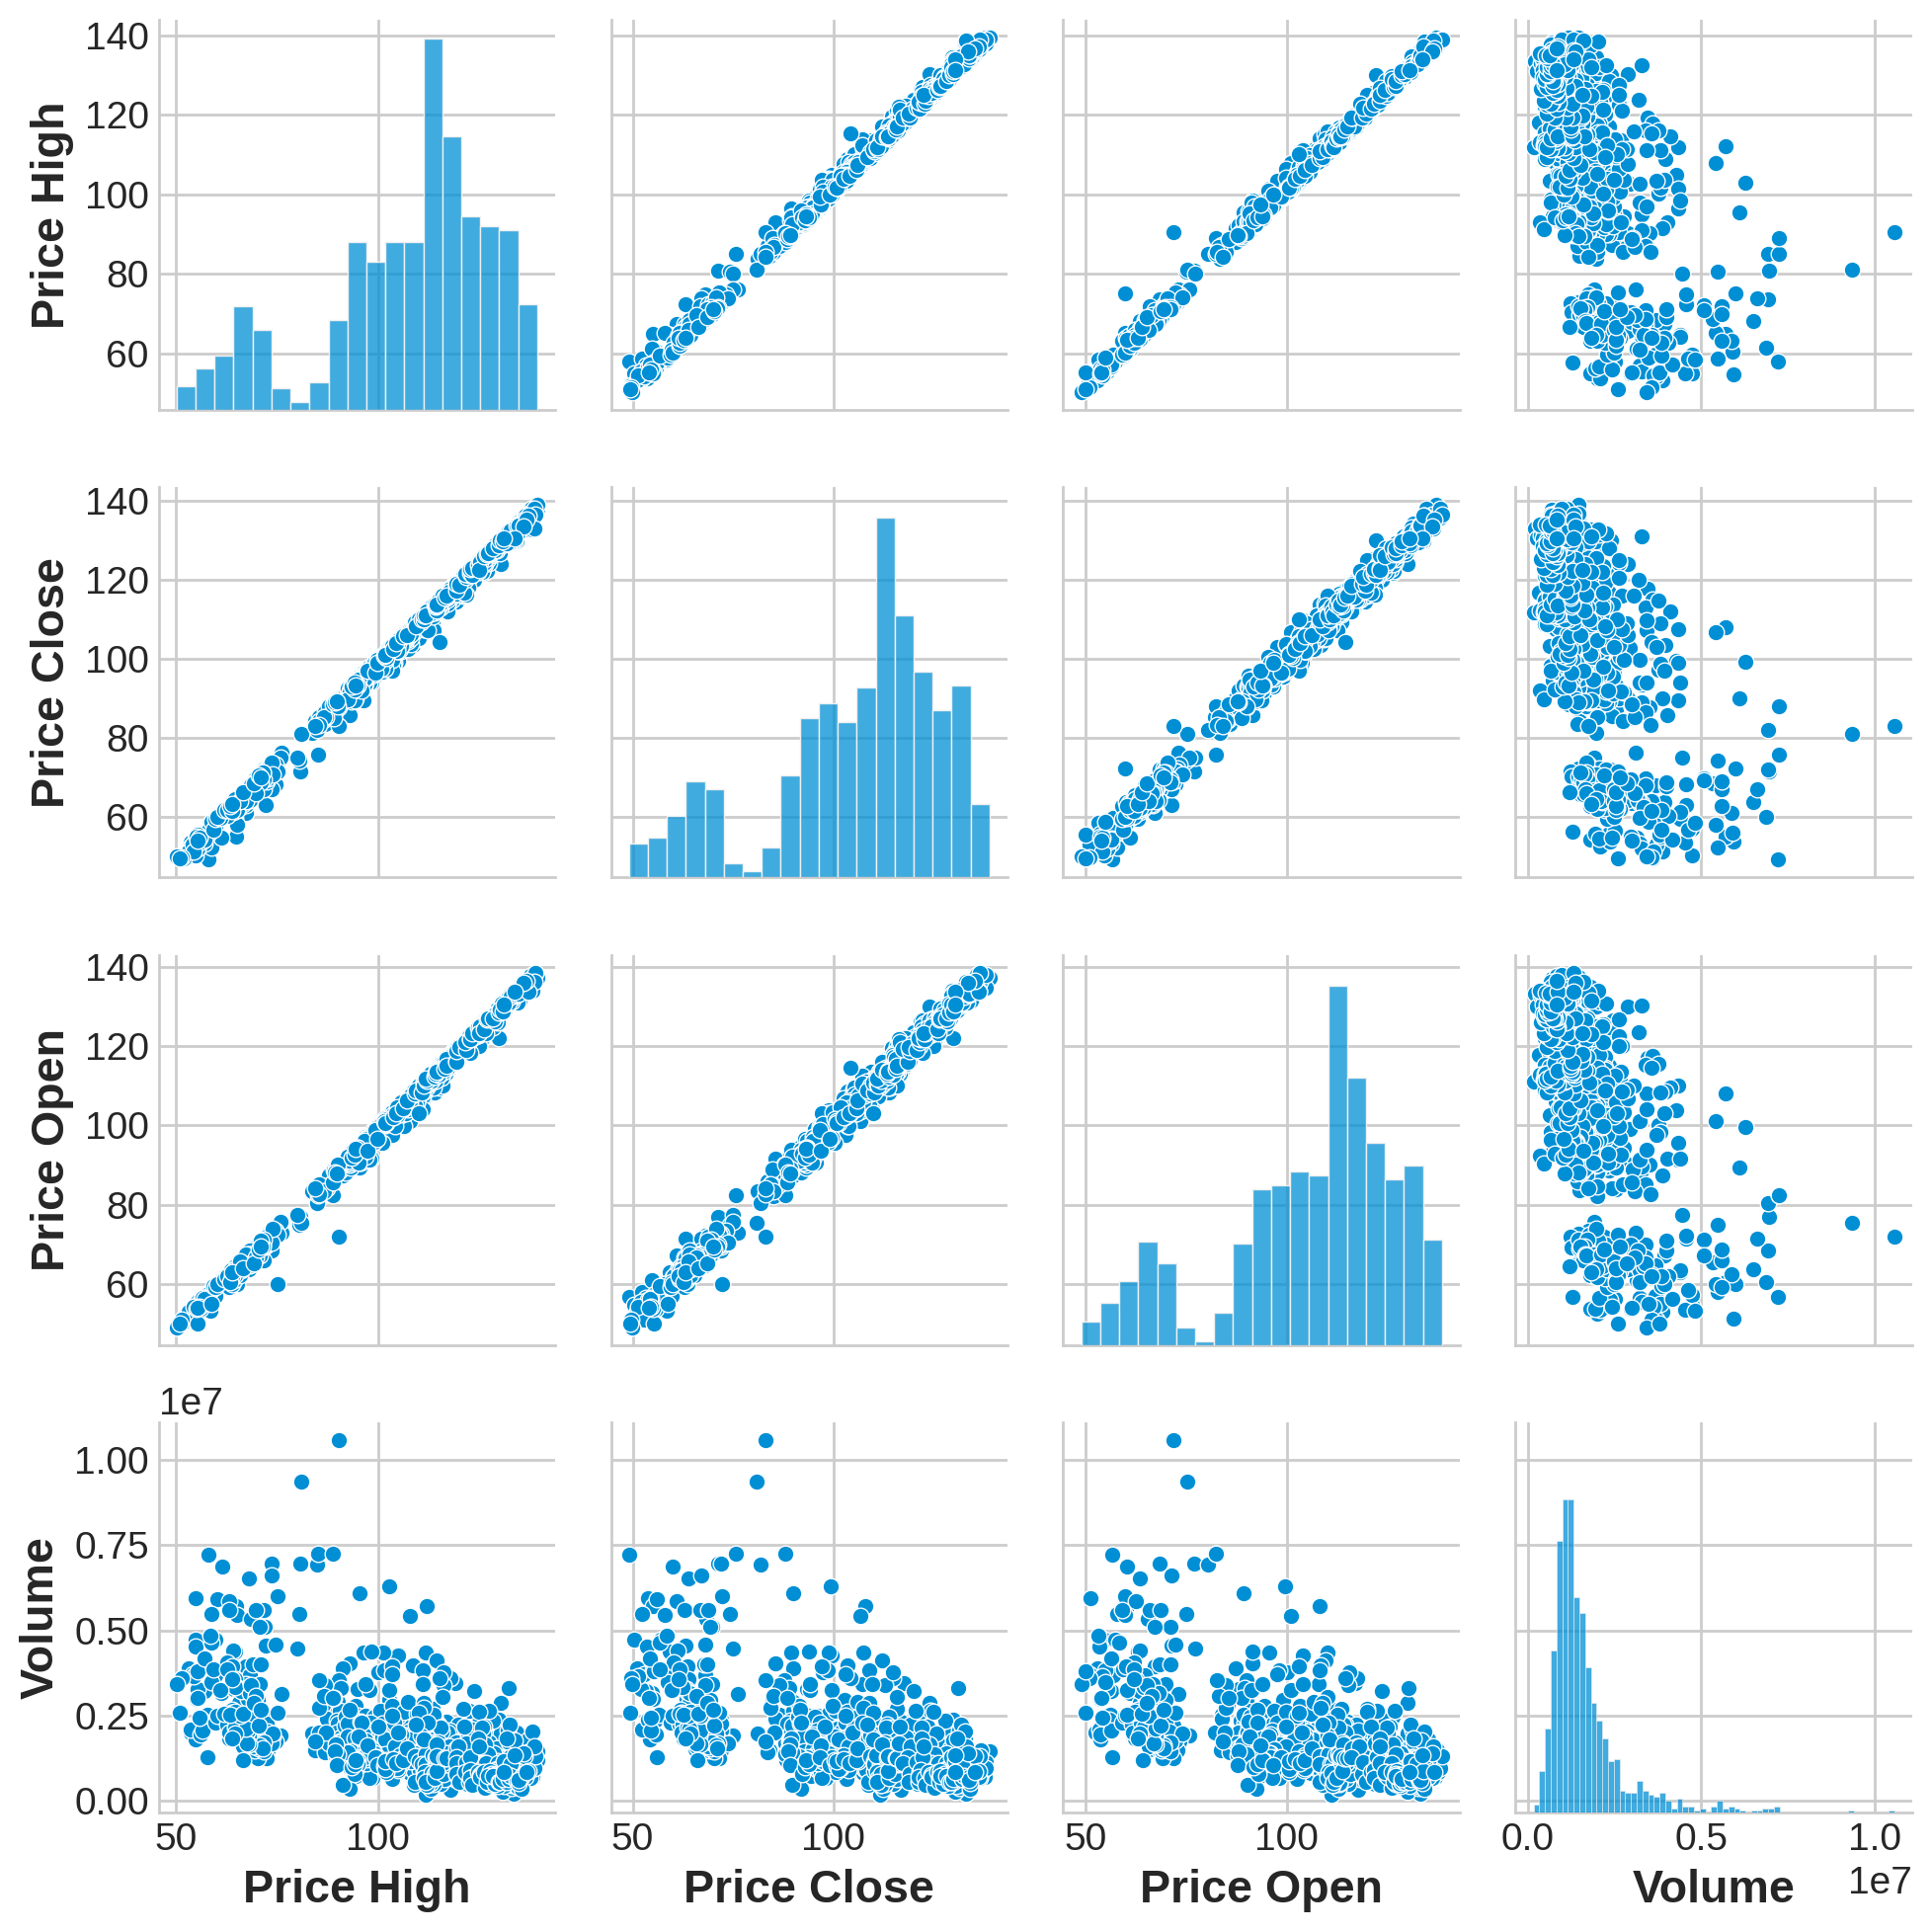

In [ ]:
df_stock1 = df_stock.copy()
df_stock = df_stock.loc[:,:'Volume']
sns.pairplot(data=df_stock)
plt.show()

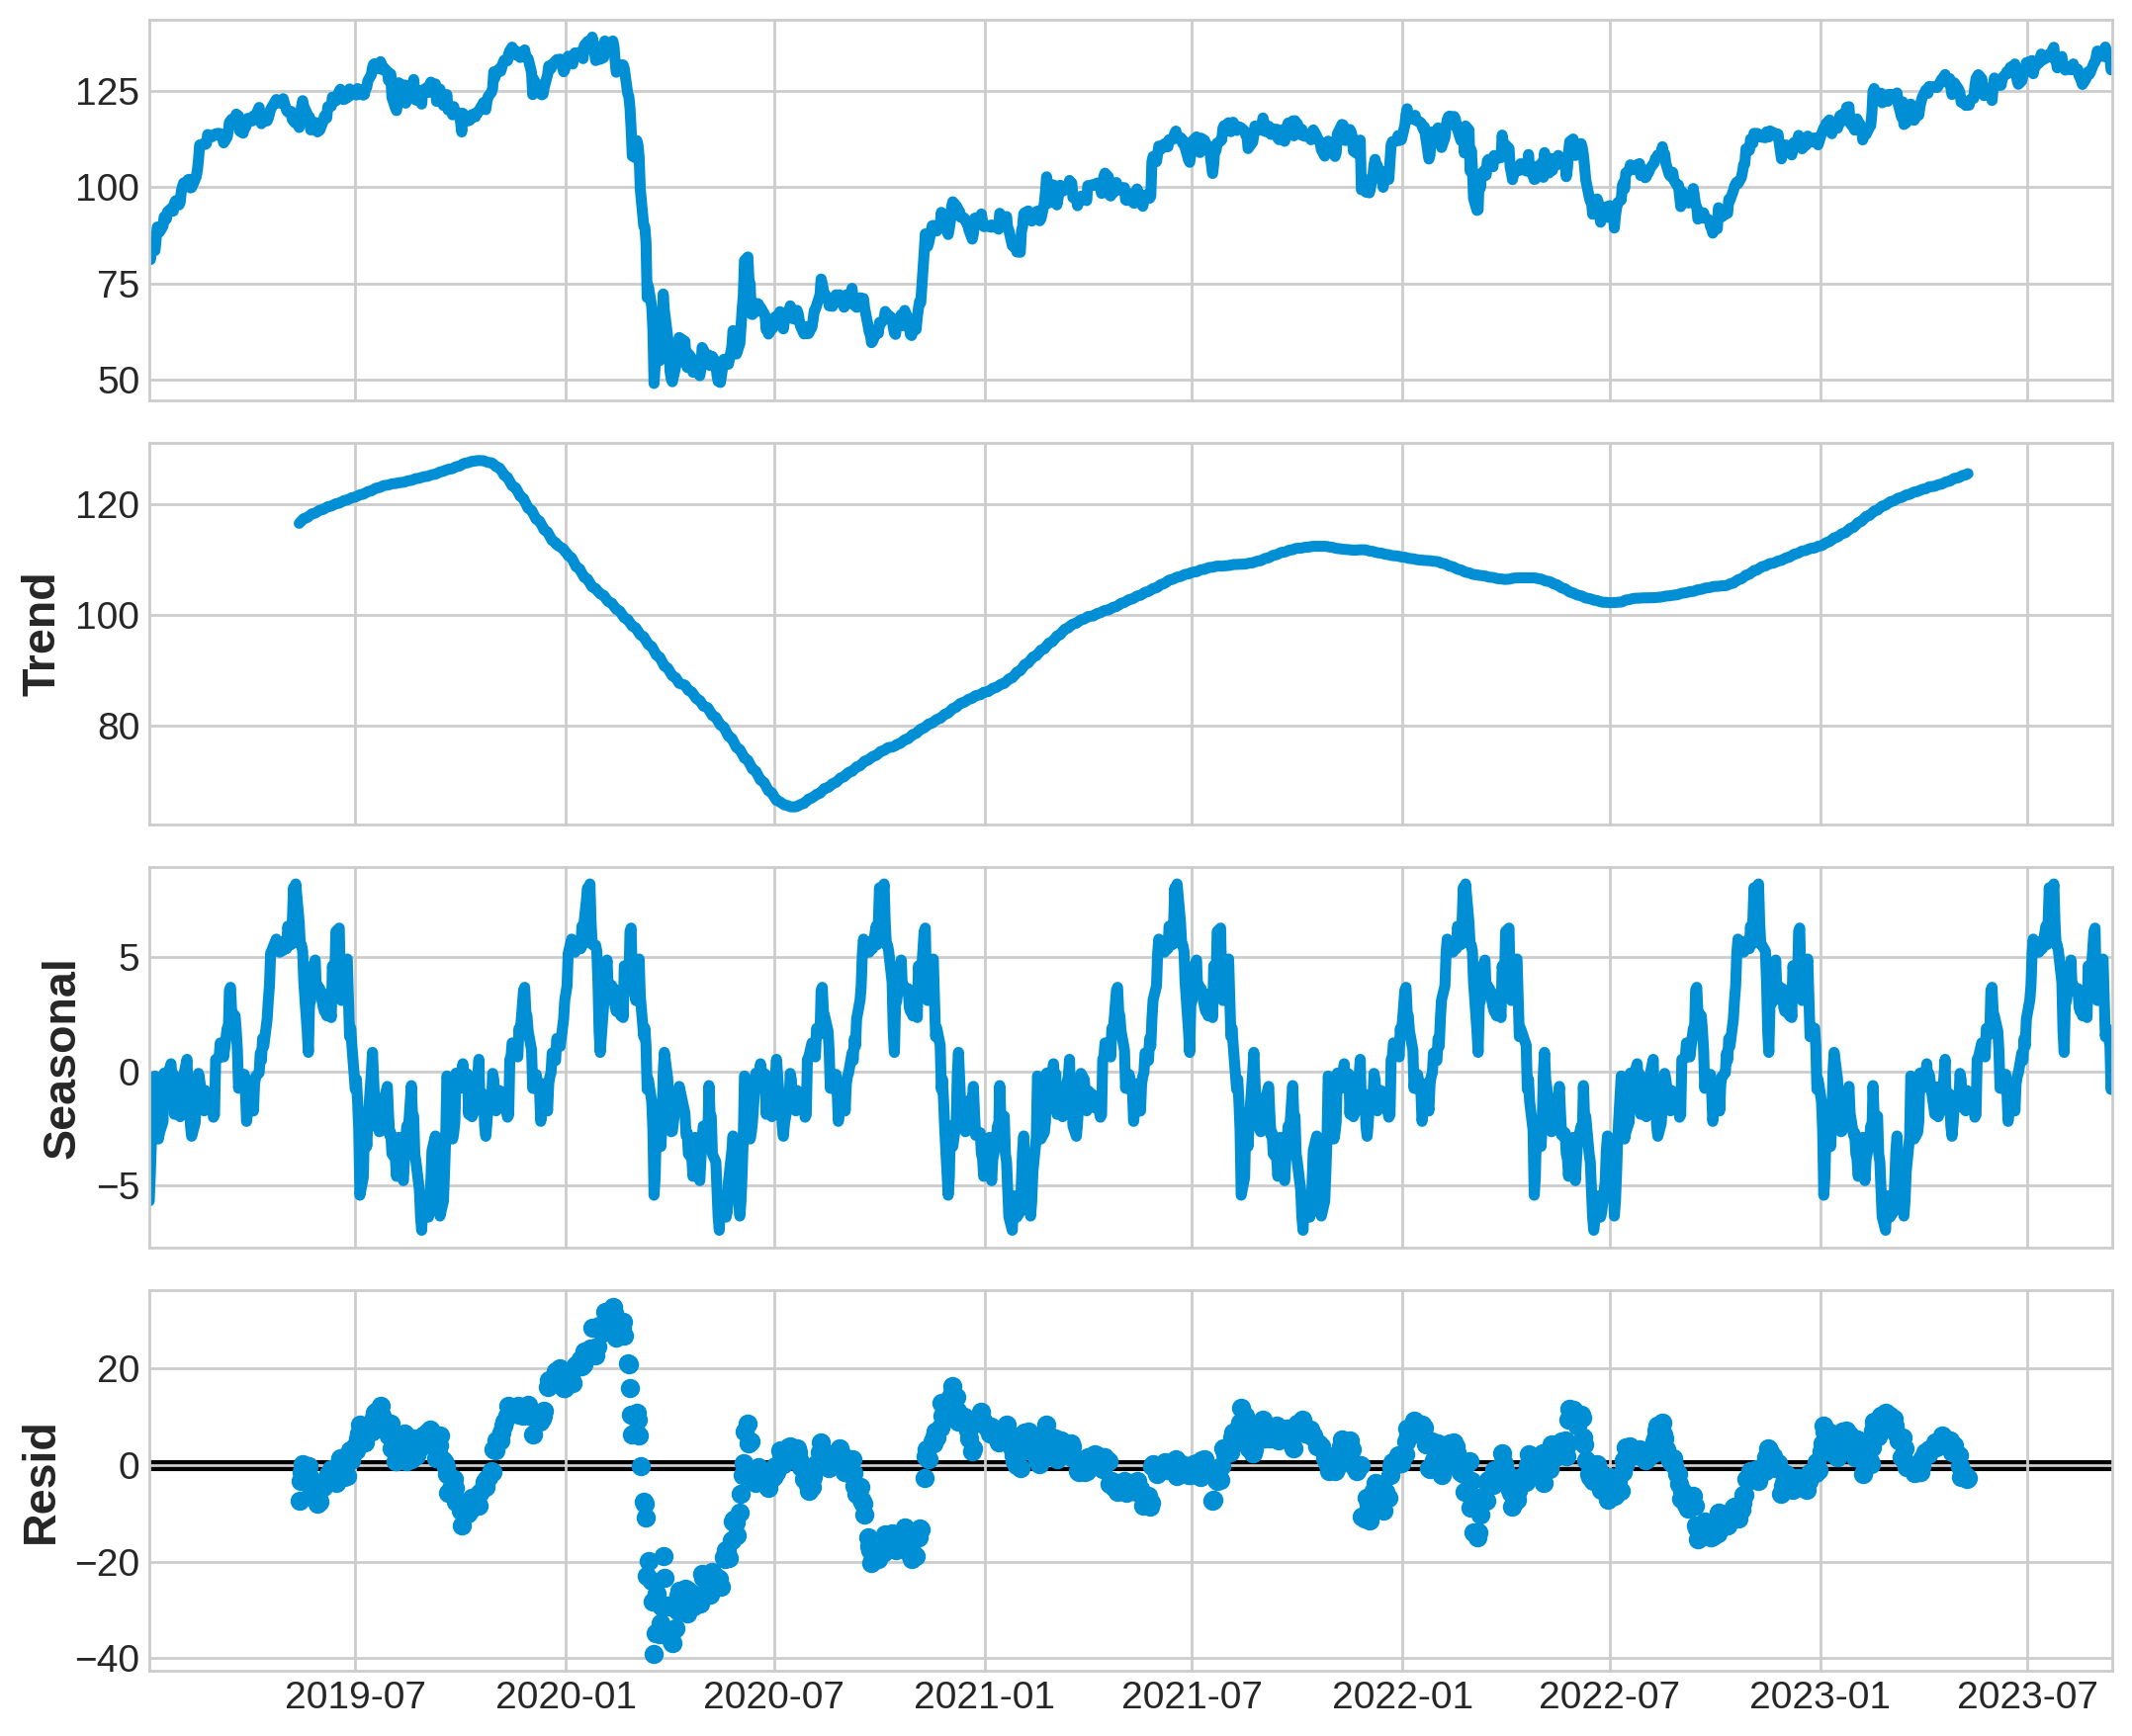

In [ ]:
# decomposition
rcParams['figure.figsize'] = 11, 9
df_stock_sim1 = sm.tsa.seasonal_decompose(df_stock[['Price Close']],
                                          period=180,
                                          model='additive')
df_stock_sim2 = df_stock[['Price Close']]
figure = df_stock_sim1.plot()
plt.show()

In [ ]:
sim1=df_stock_sim1.resid.dropna()
sim2 = df_stock_sim2.dropna()

# Model

## ARIMA

[]

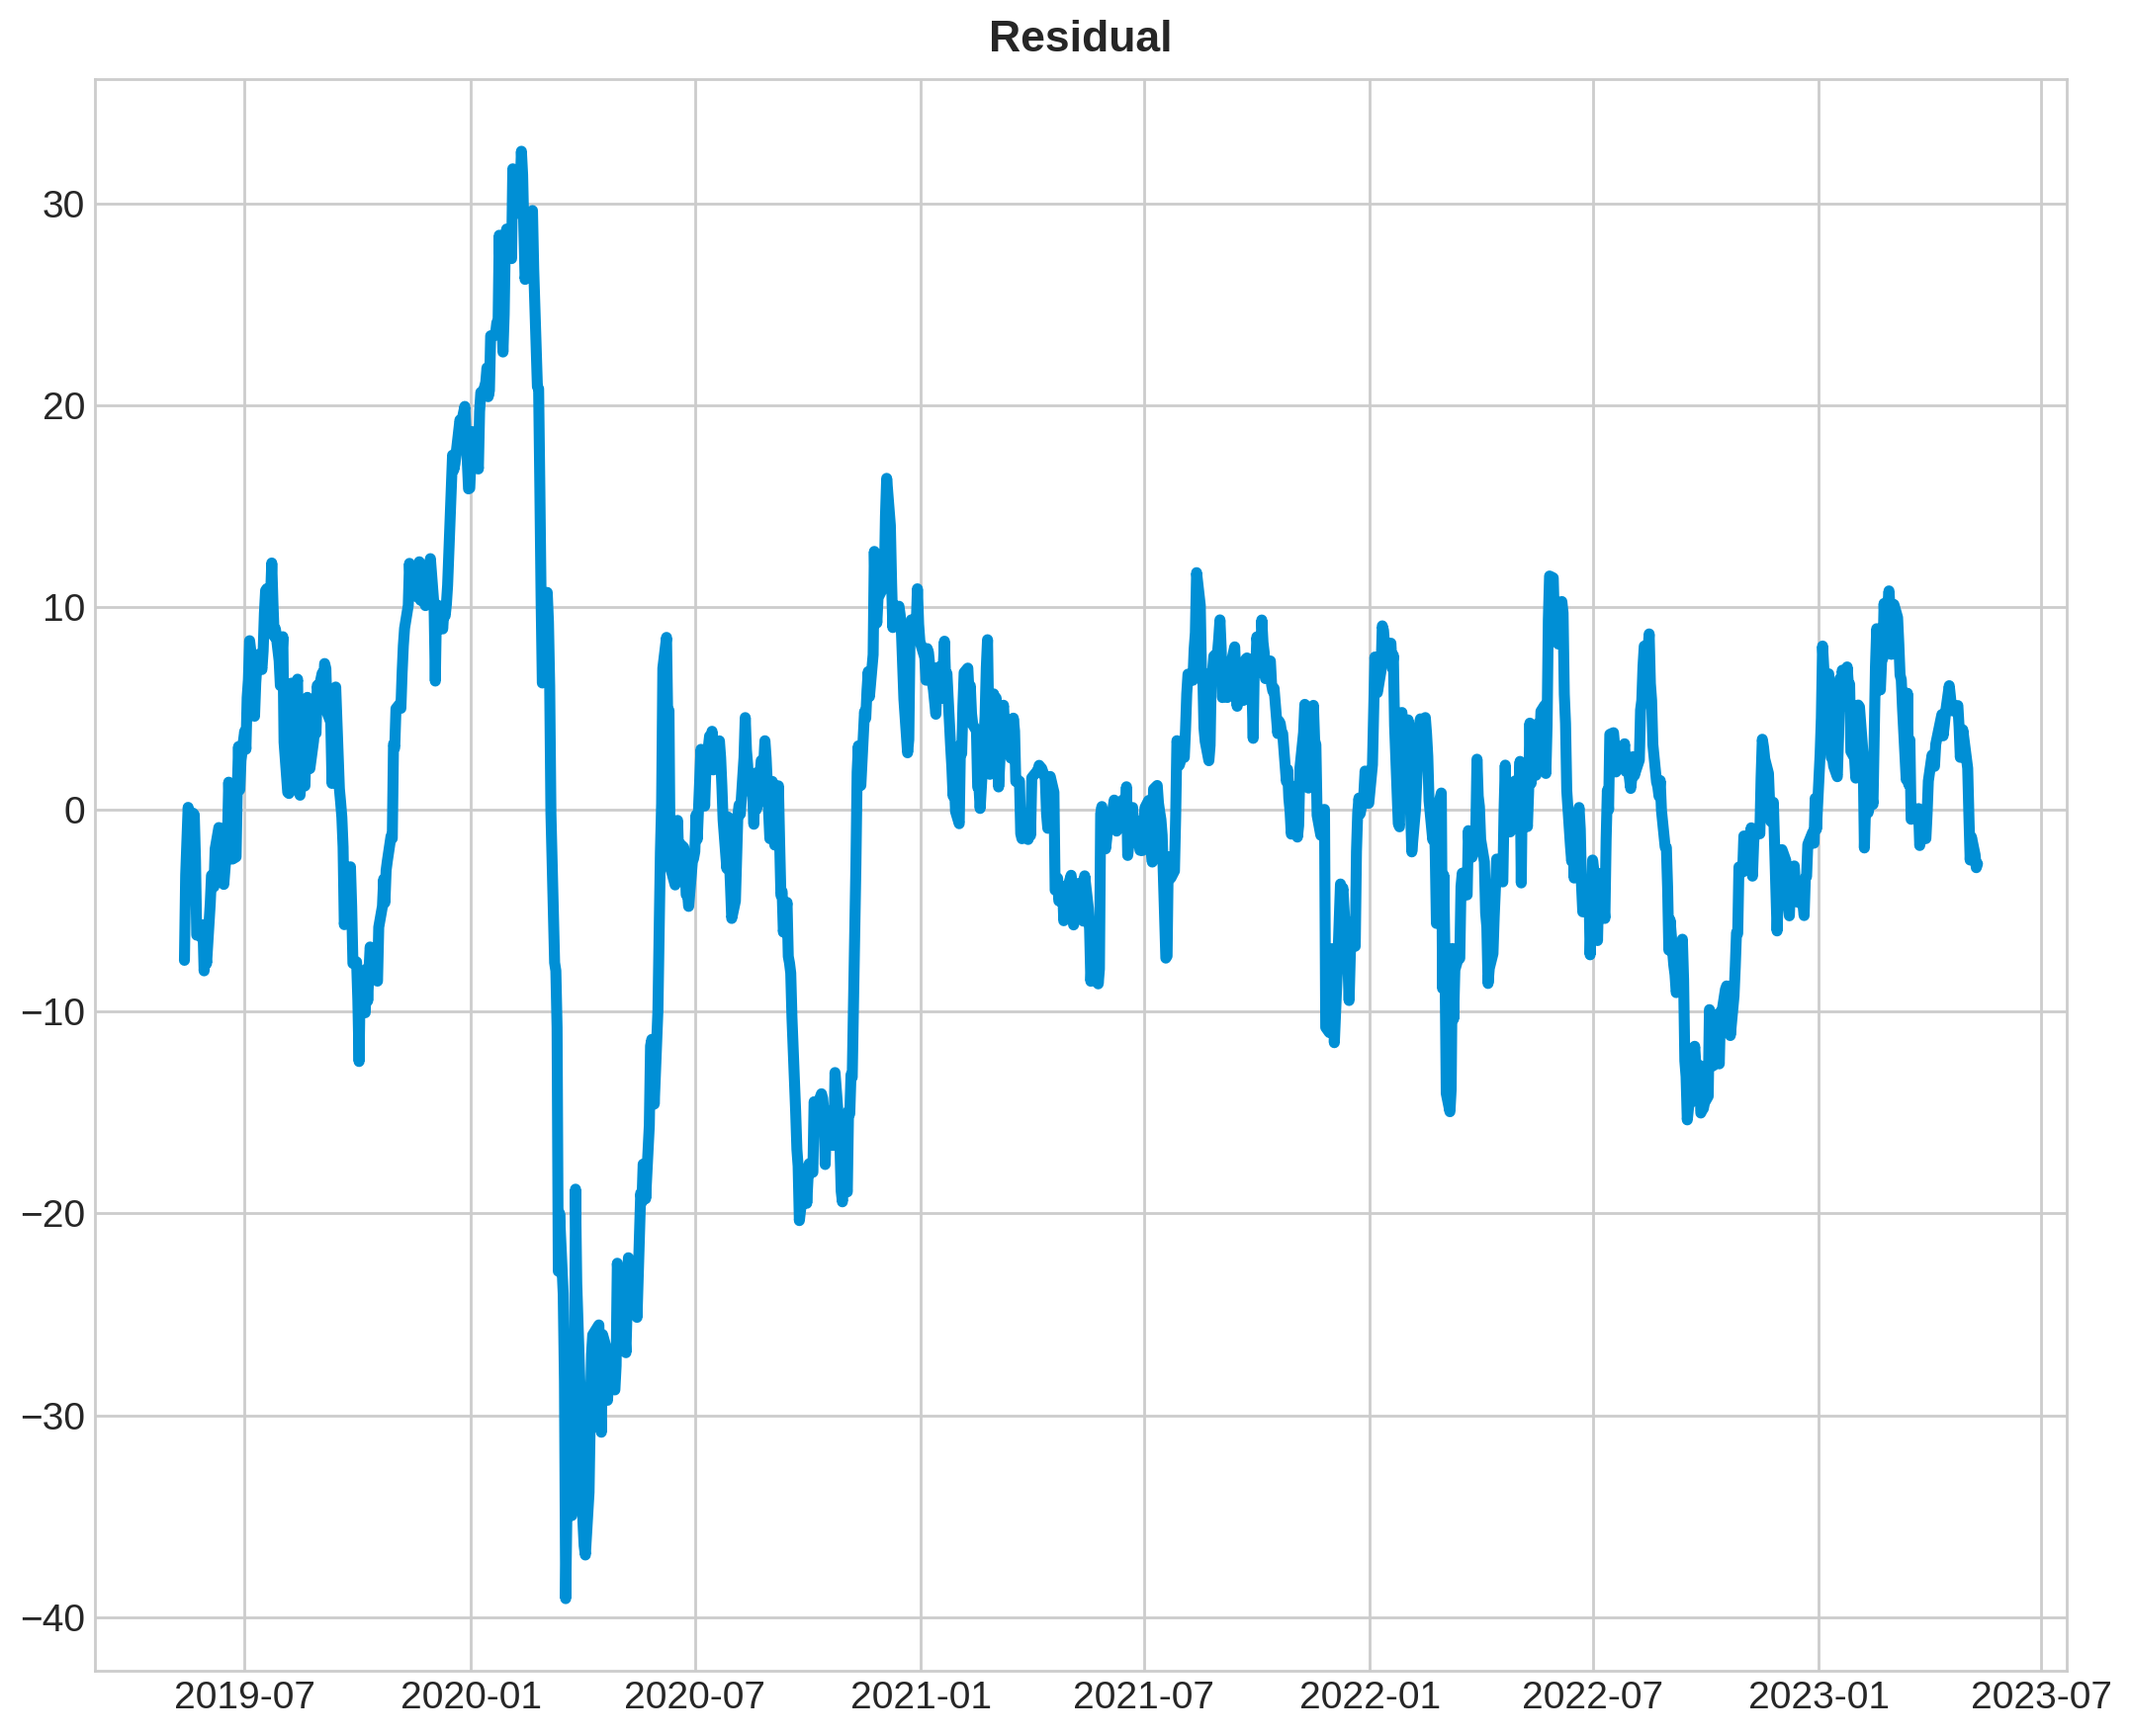

In [ ]:
plt.plot(sim1)
plt.title('Residual')
plt.plot()

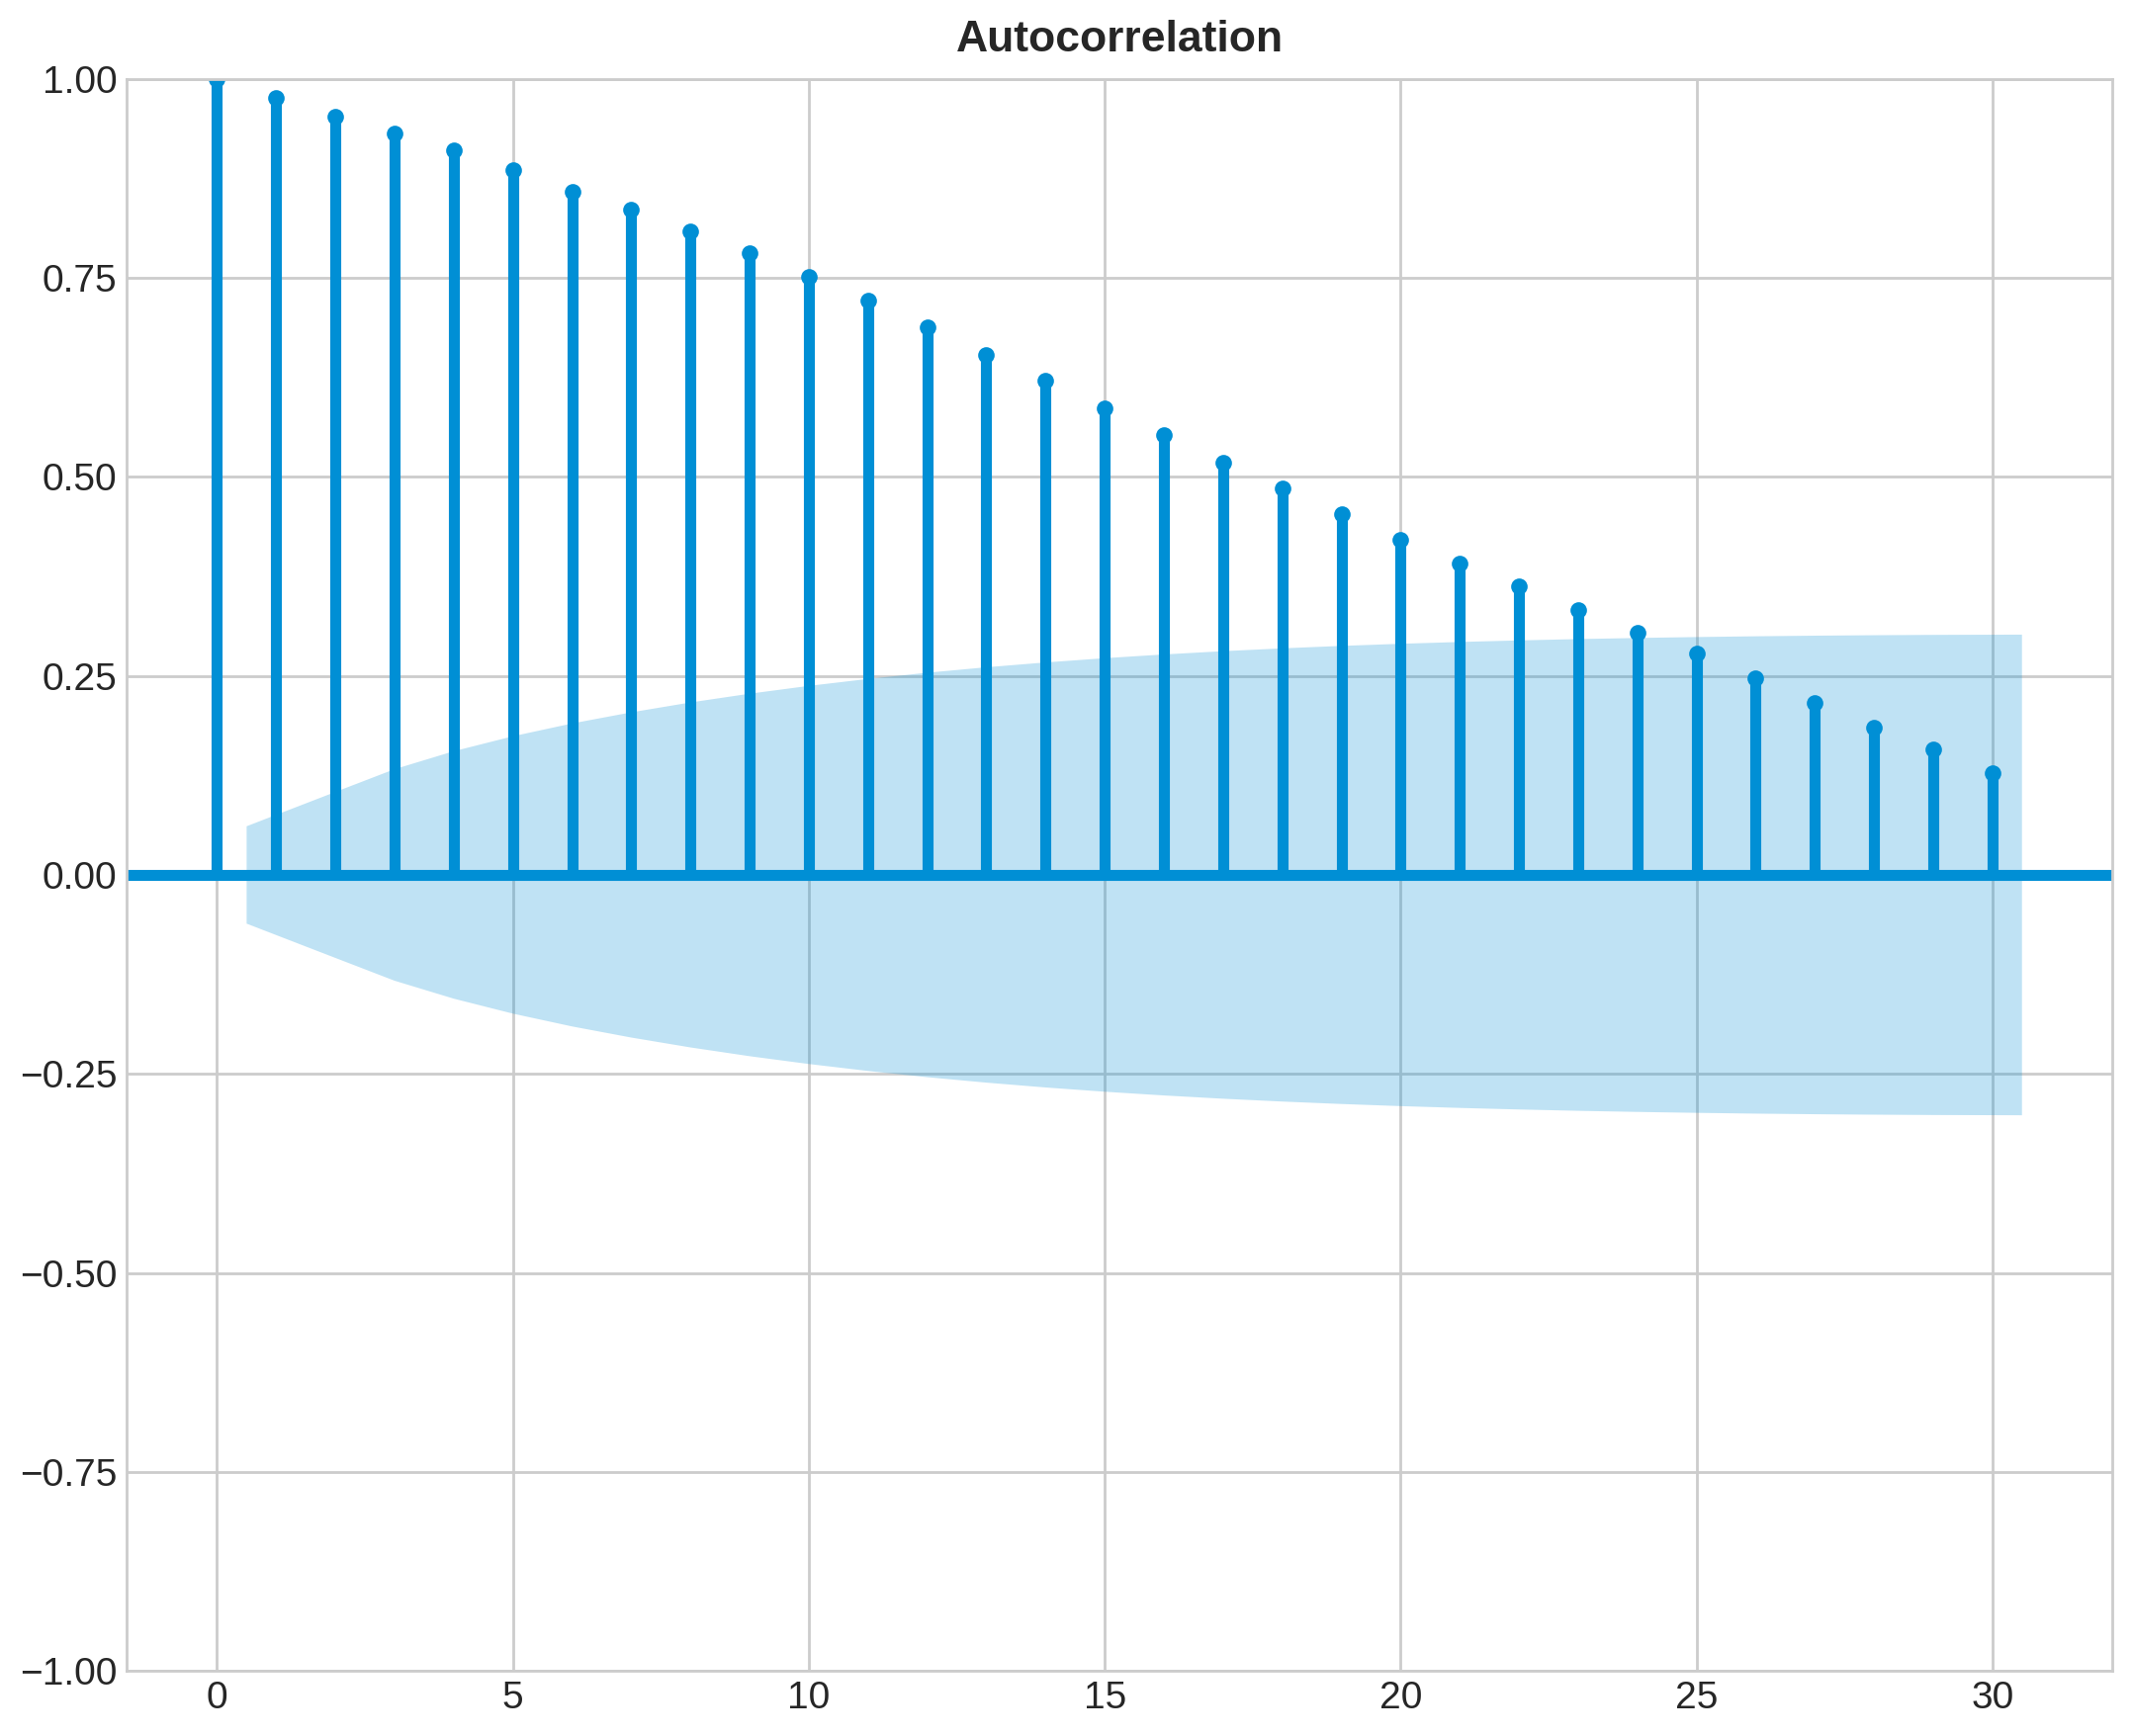

In [ ]:
plot_acf(sim1, lags=30)
plt.show()

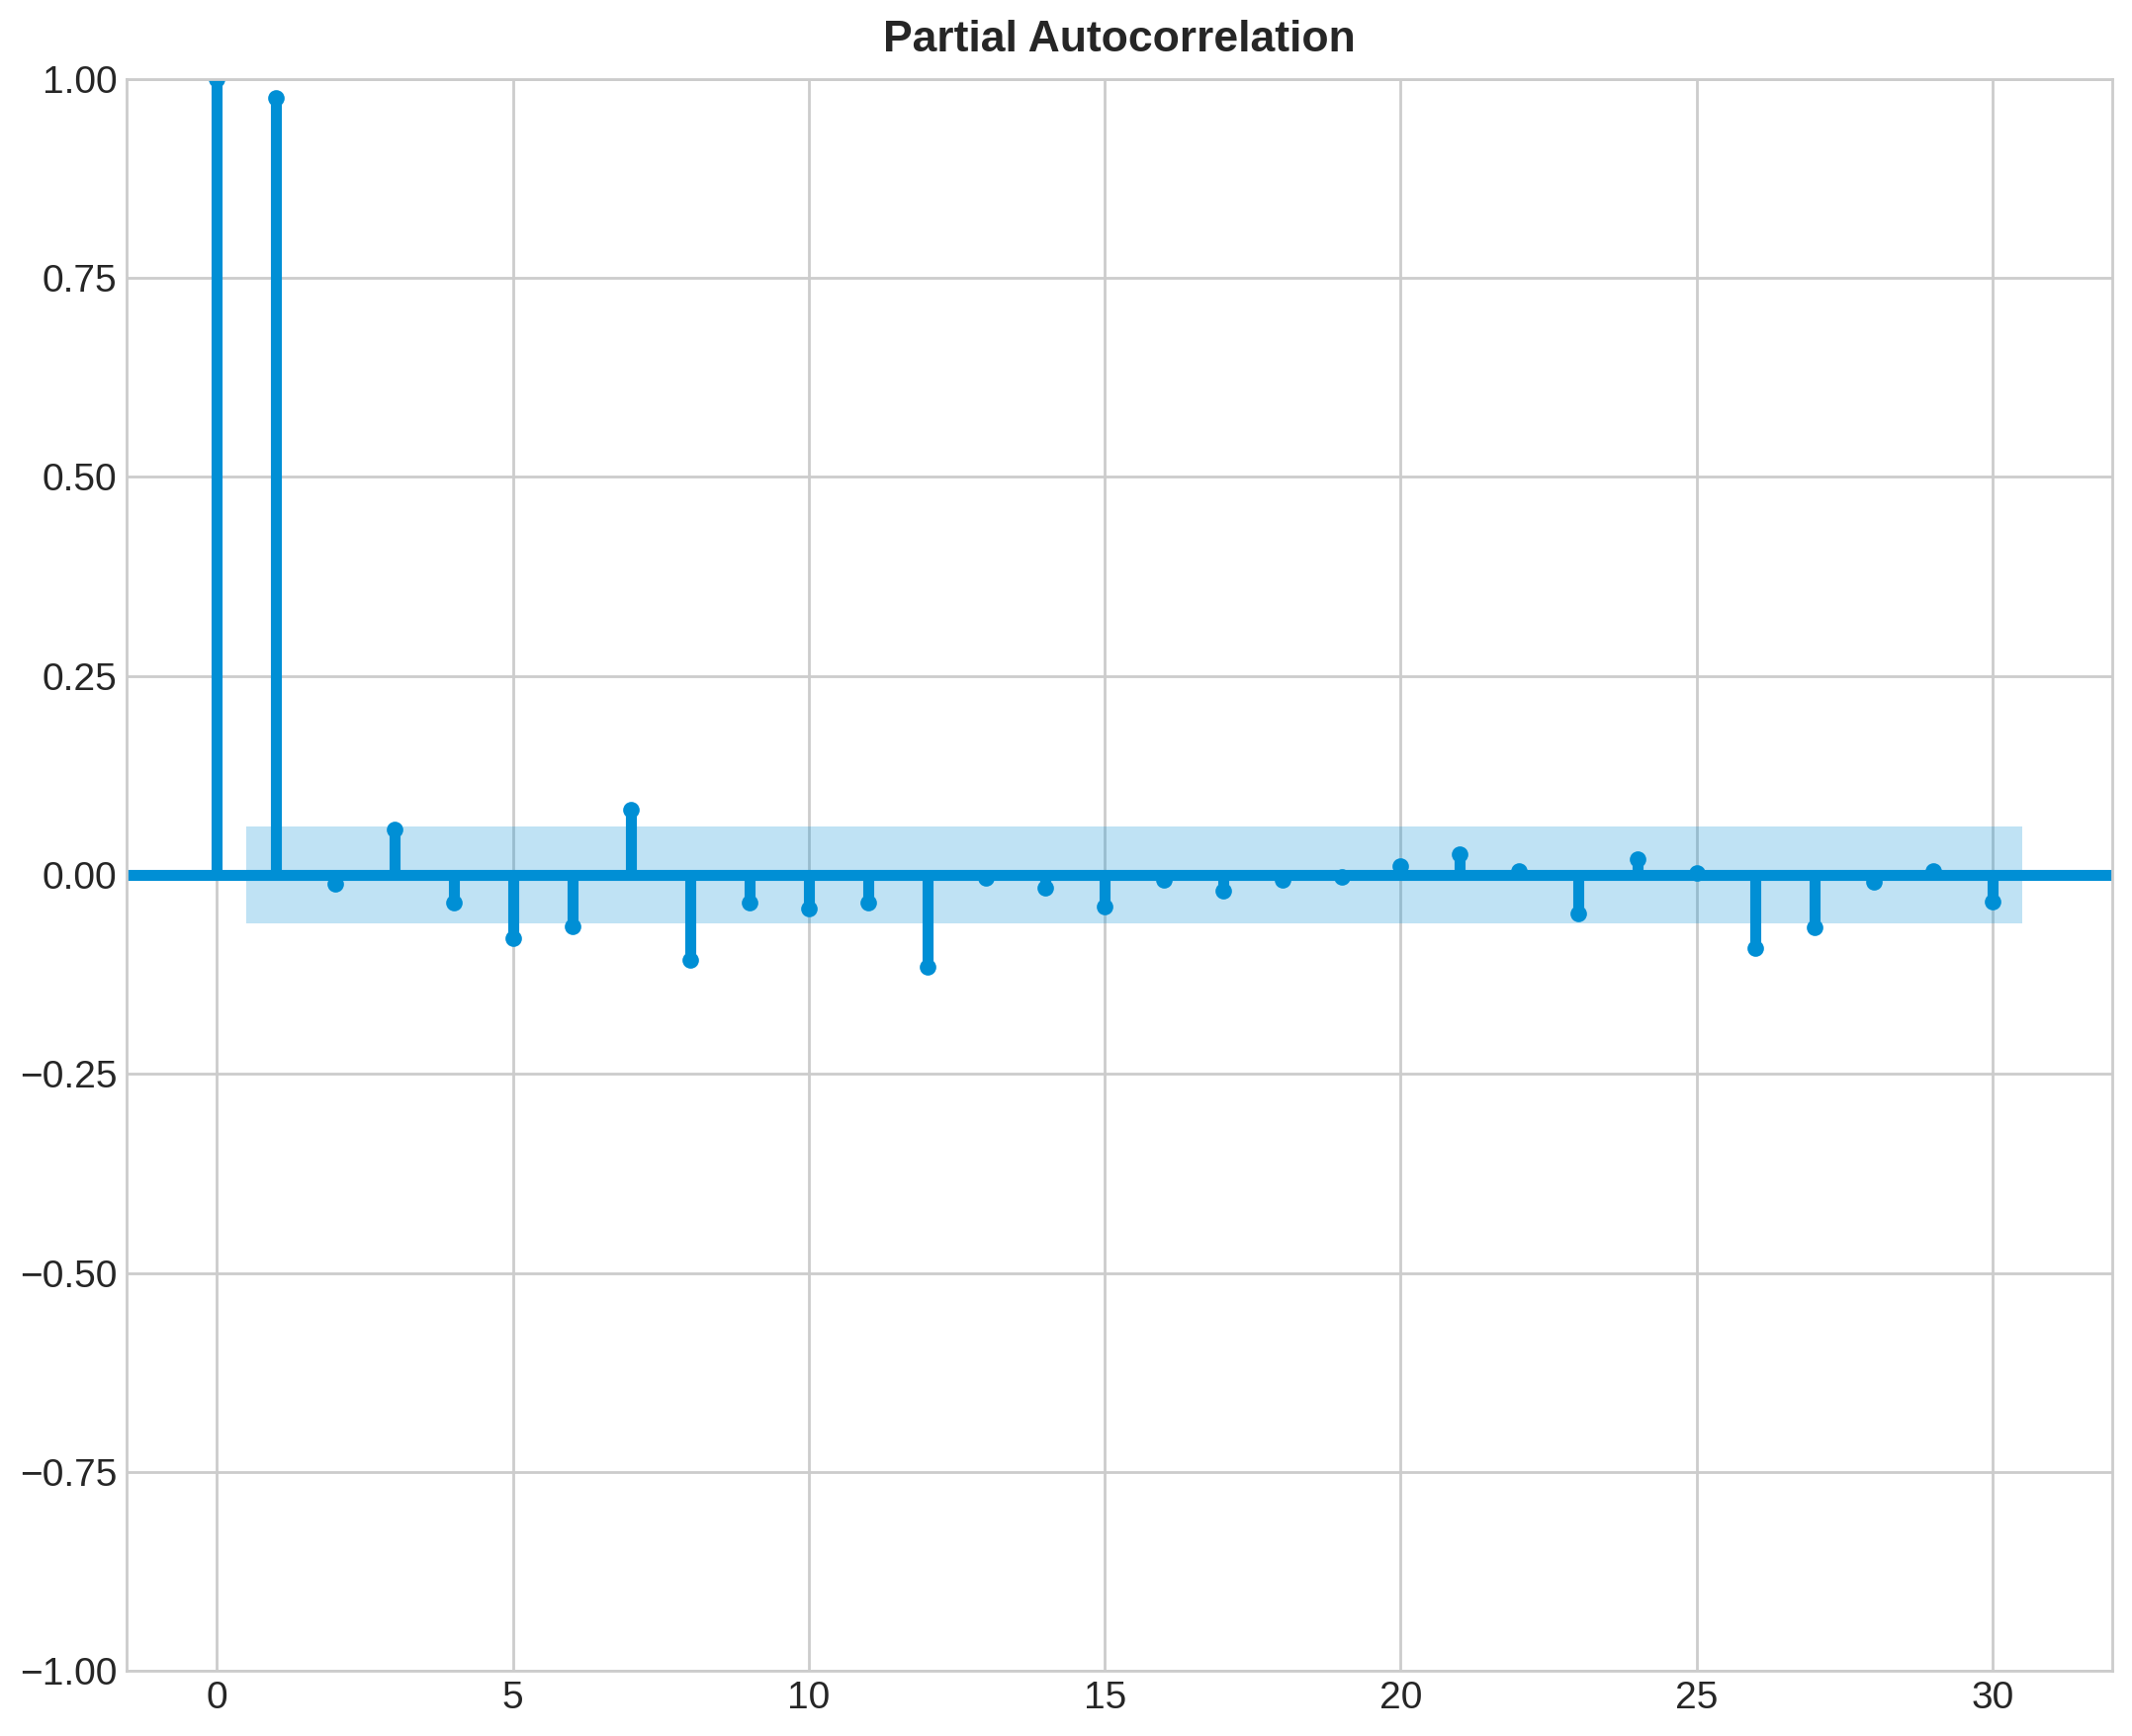

In [ ]:
plot_pacf(sim1, lags=30)
plt.show()

In [ ]:
model = sm.tsa.statespace.SARIMAX(sim1,
                                order=(1, 0, 0))

results = model.fit()

In [ ]:
pred = results.get_prediction(start=0,dynamic=False)

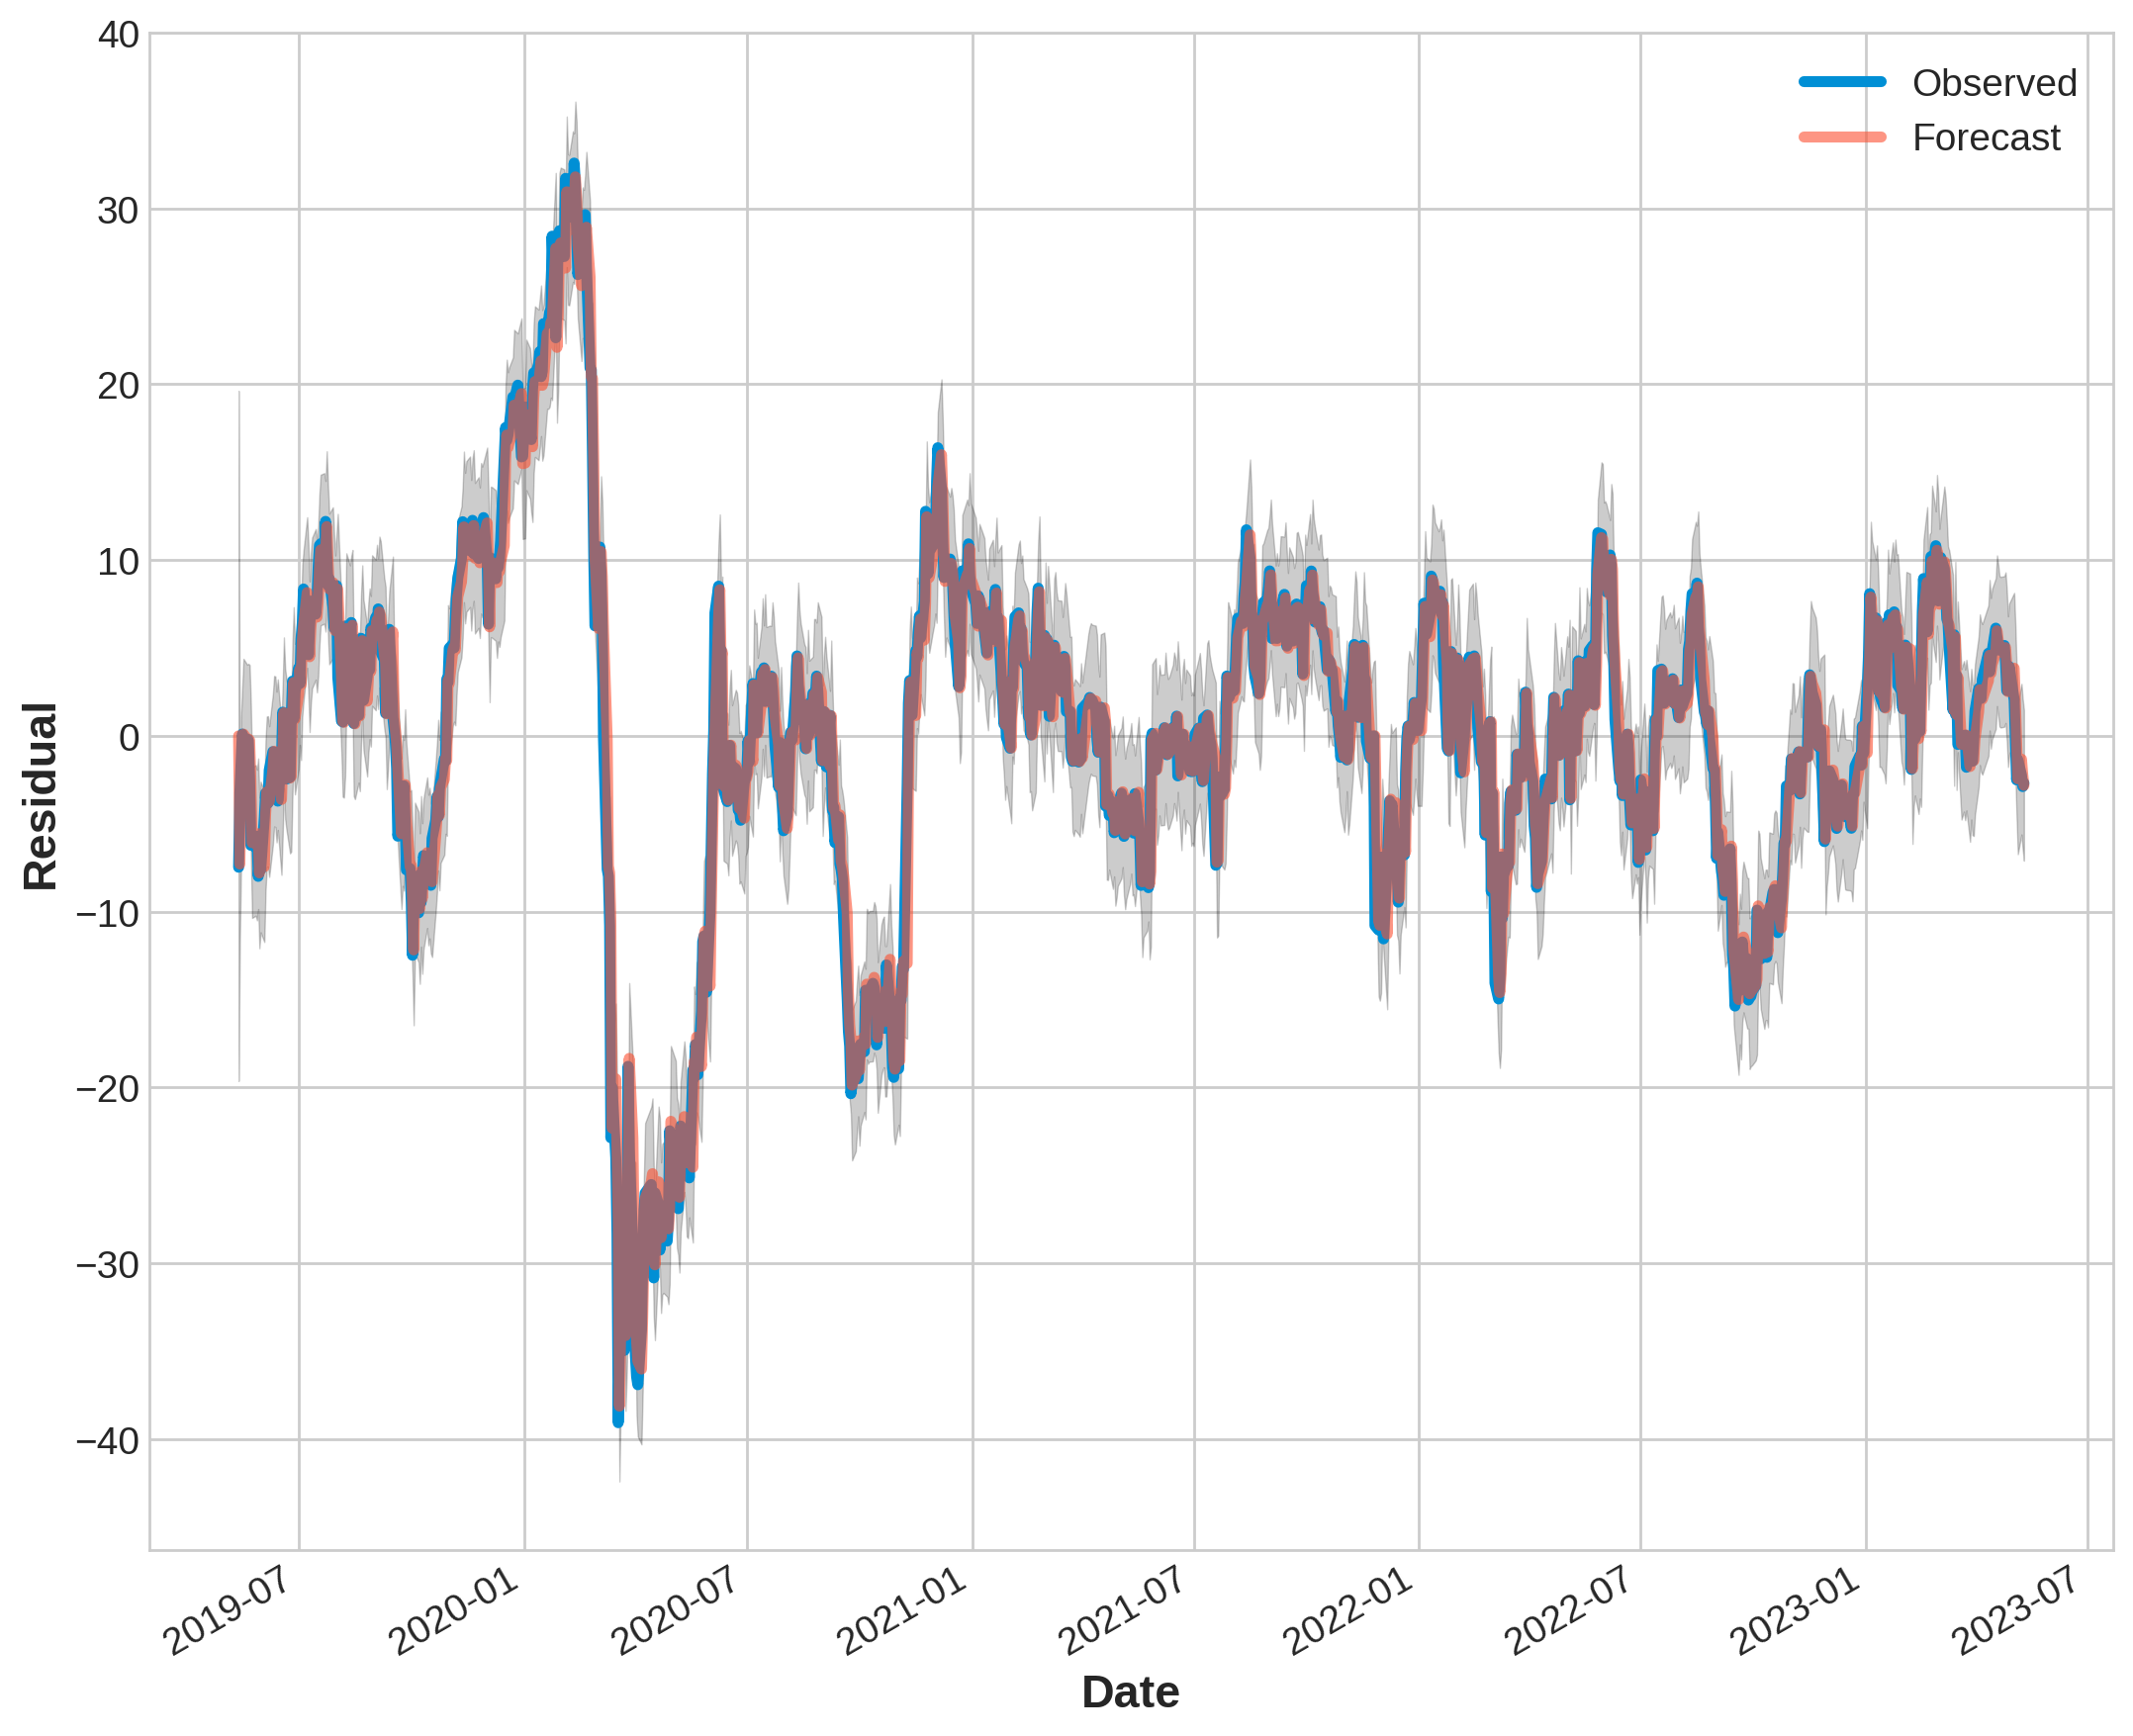

In [ ]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim1[0:].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
plt.legend()

plt.show()


<Axes: xlabel='Date'>

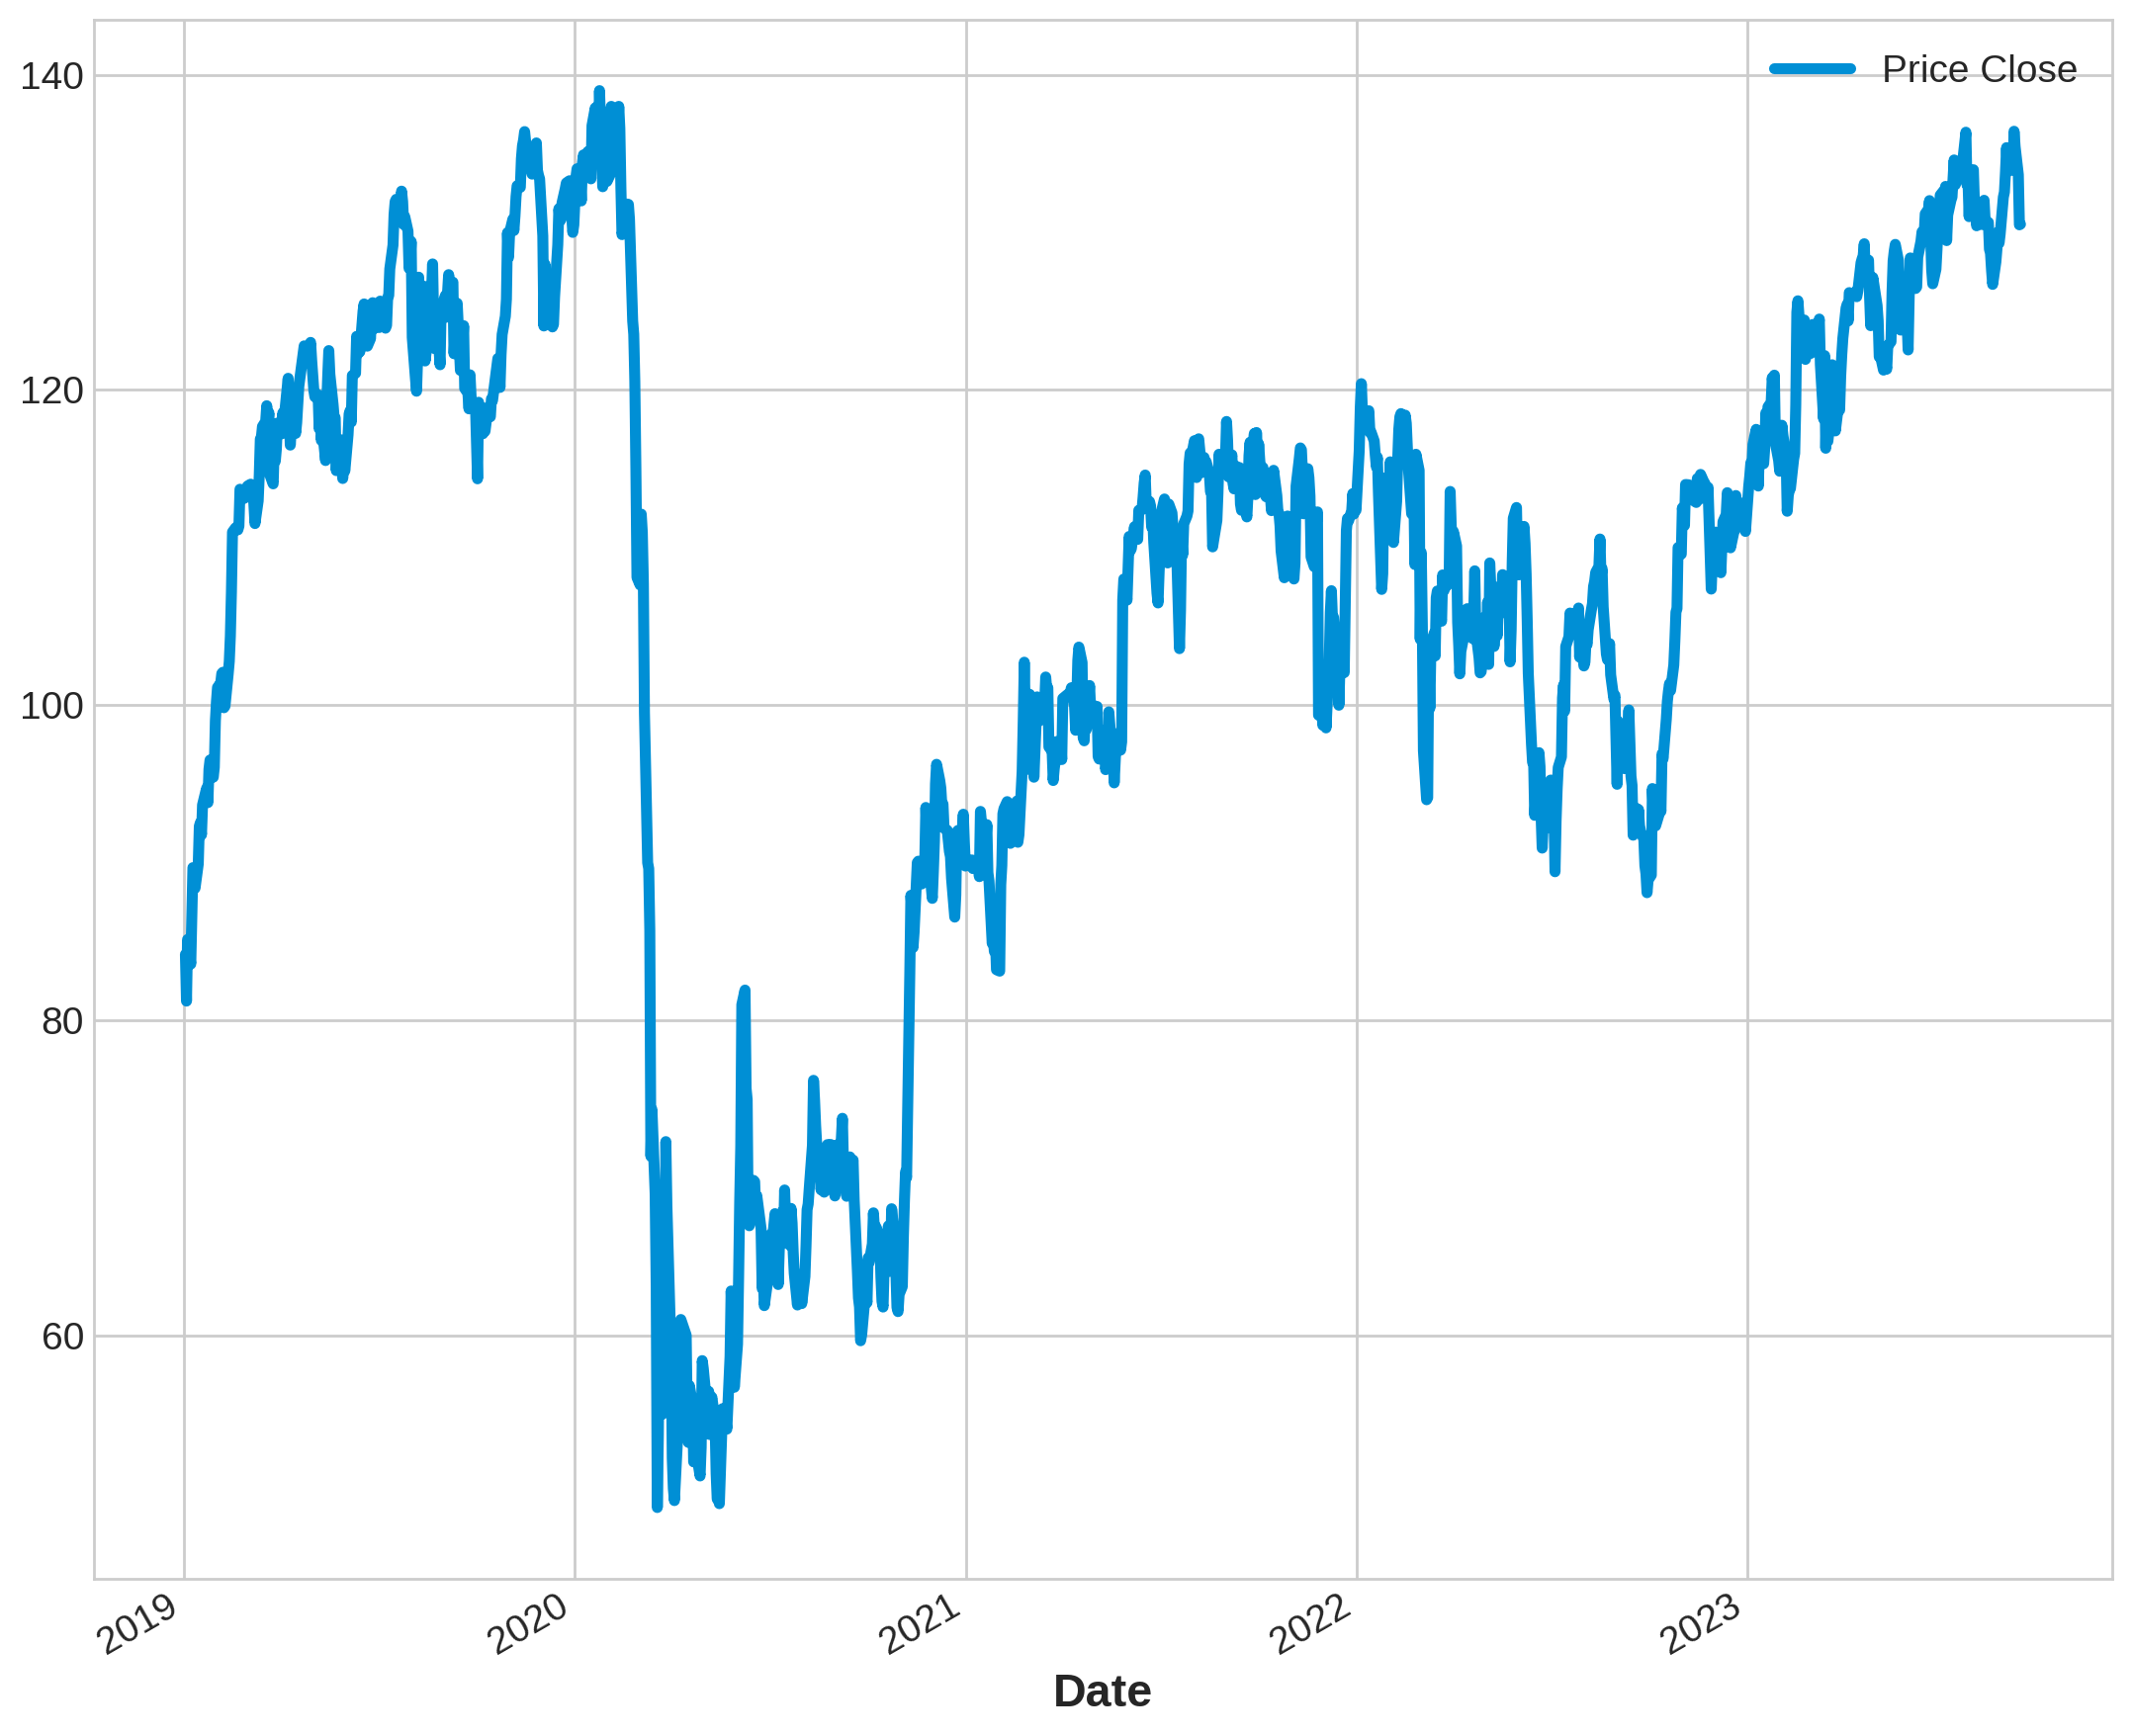

In [ ]:
sim2.plot()

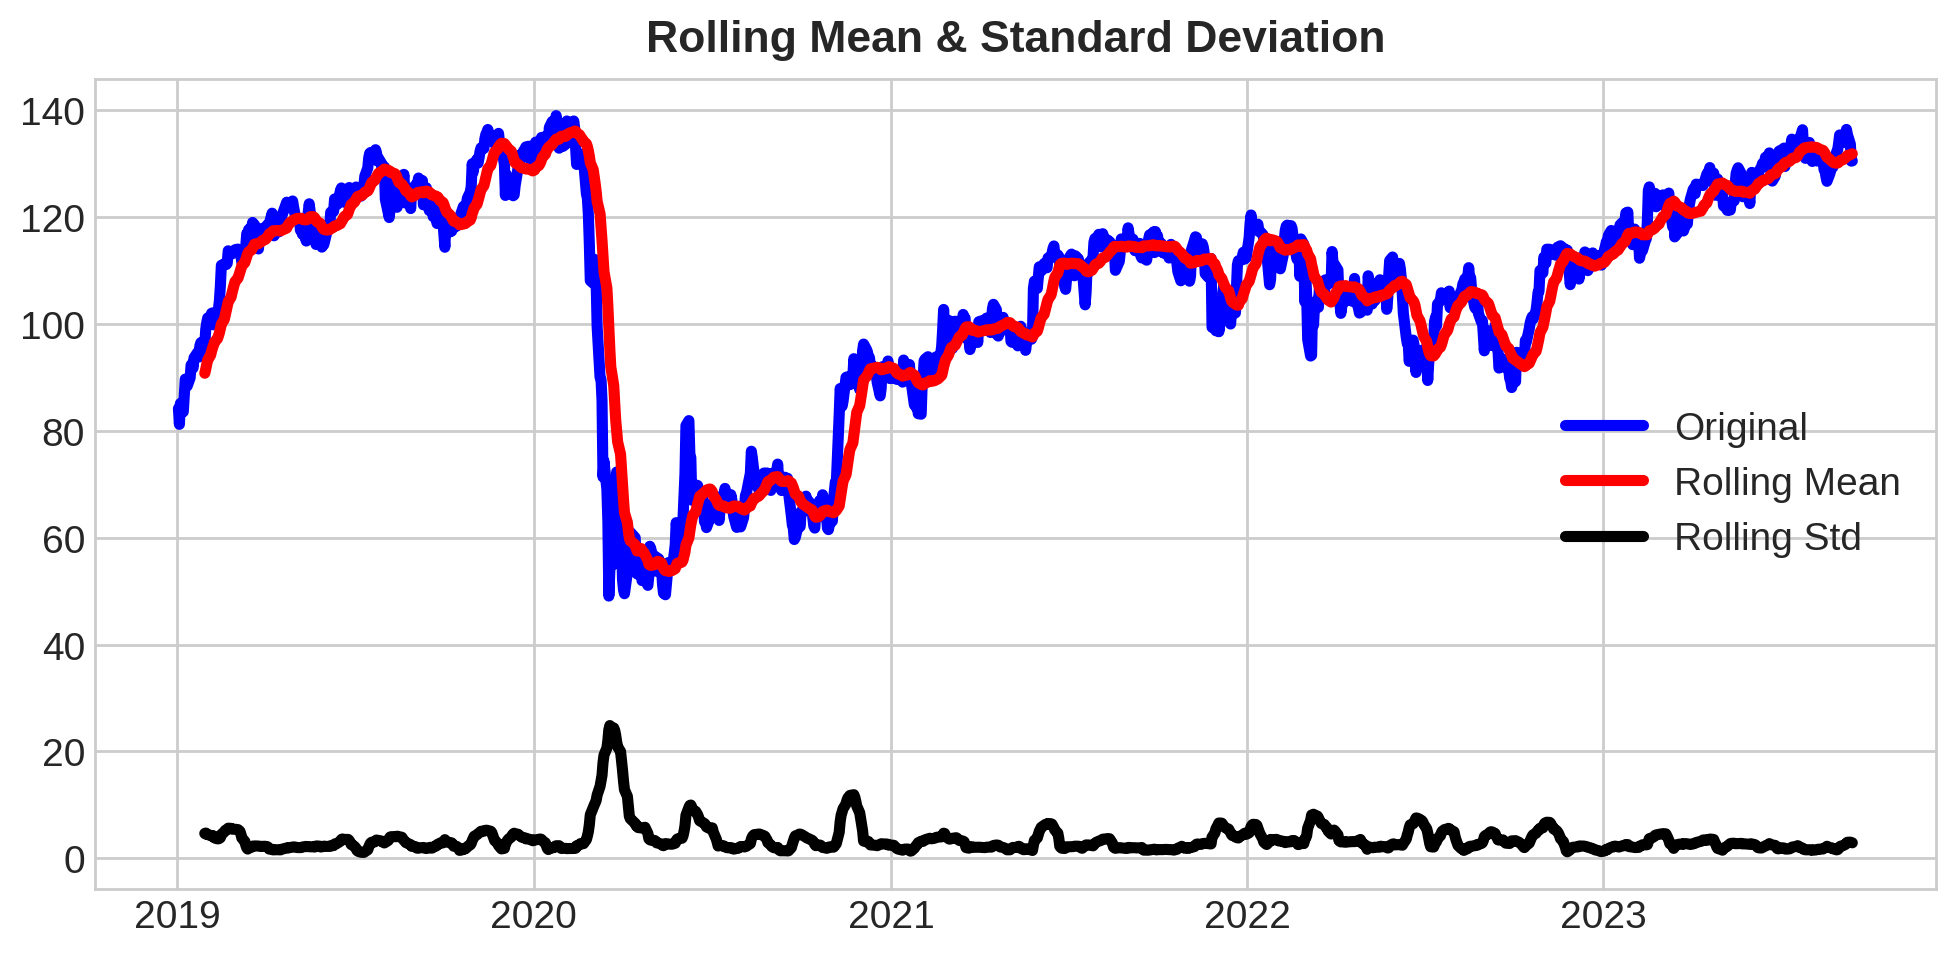

Results of Dickey-Fuller Test:
Test Statistic                   -2.237014
p-value                           0.193087
#Lags Used                       11.000000
Number of Observations Used    1195.000000
Critical Value (1%)              -3.435834
Critical Value (5%)              -2.863962
Critical Value (10%)             -2.568059
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest
StationaryTest = test_stationarity(sim2)

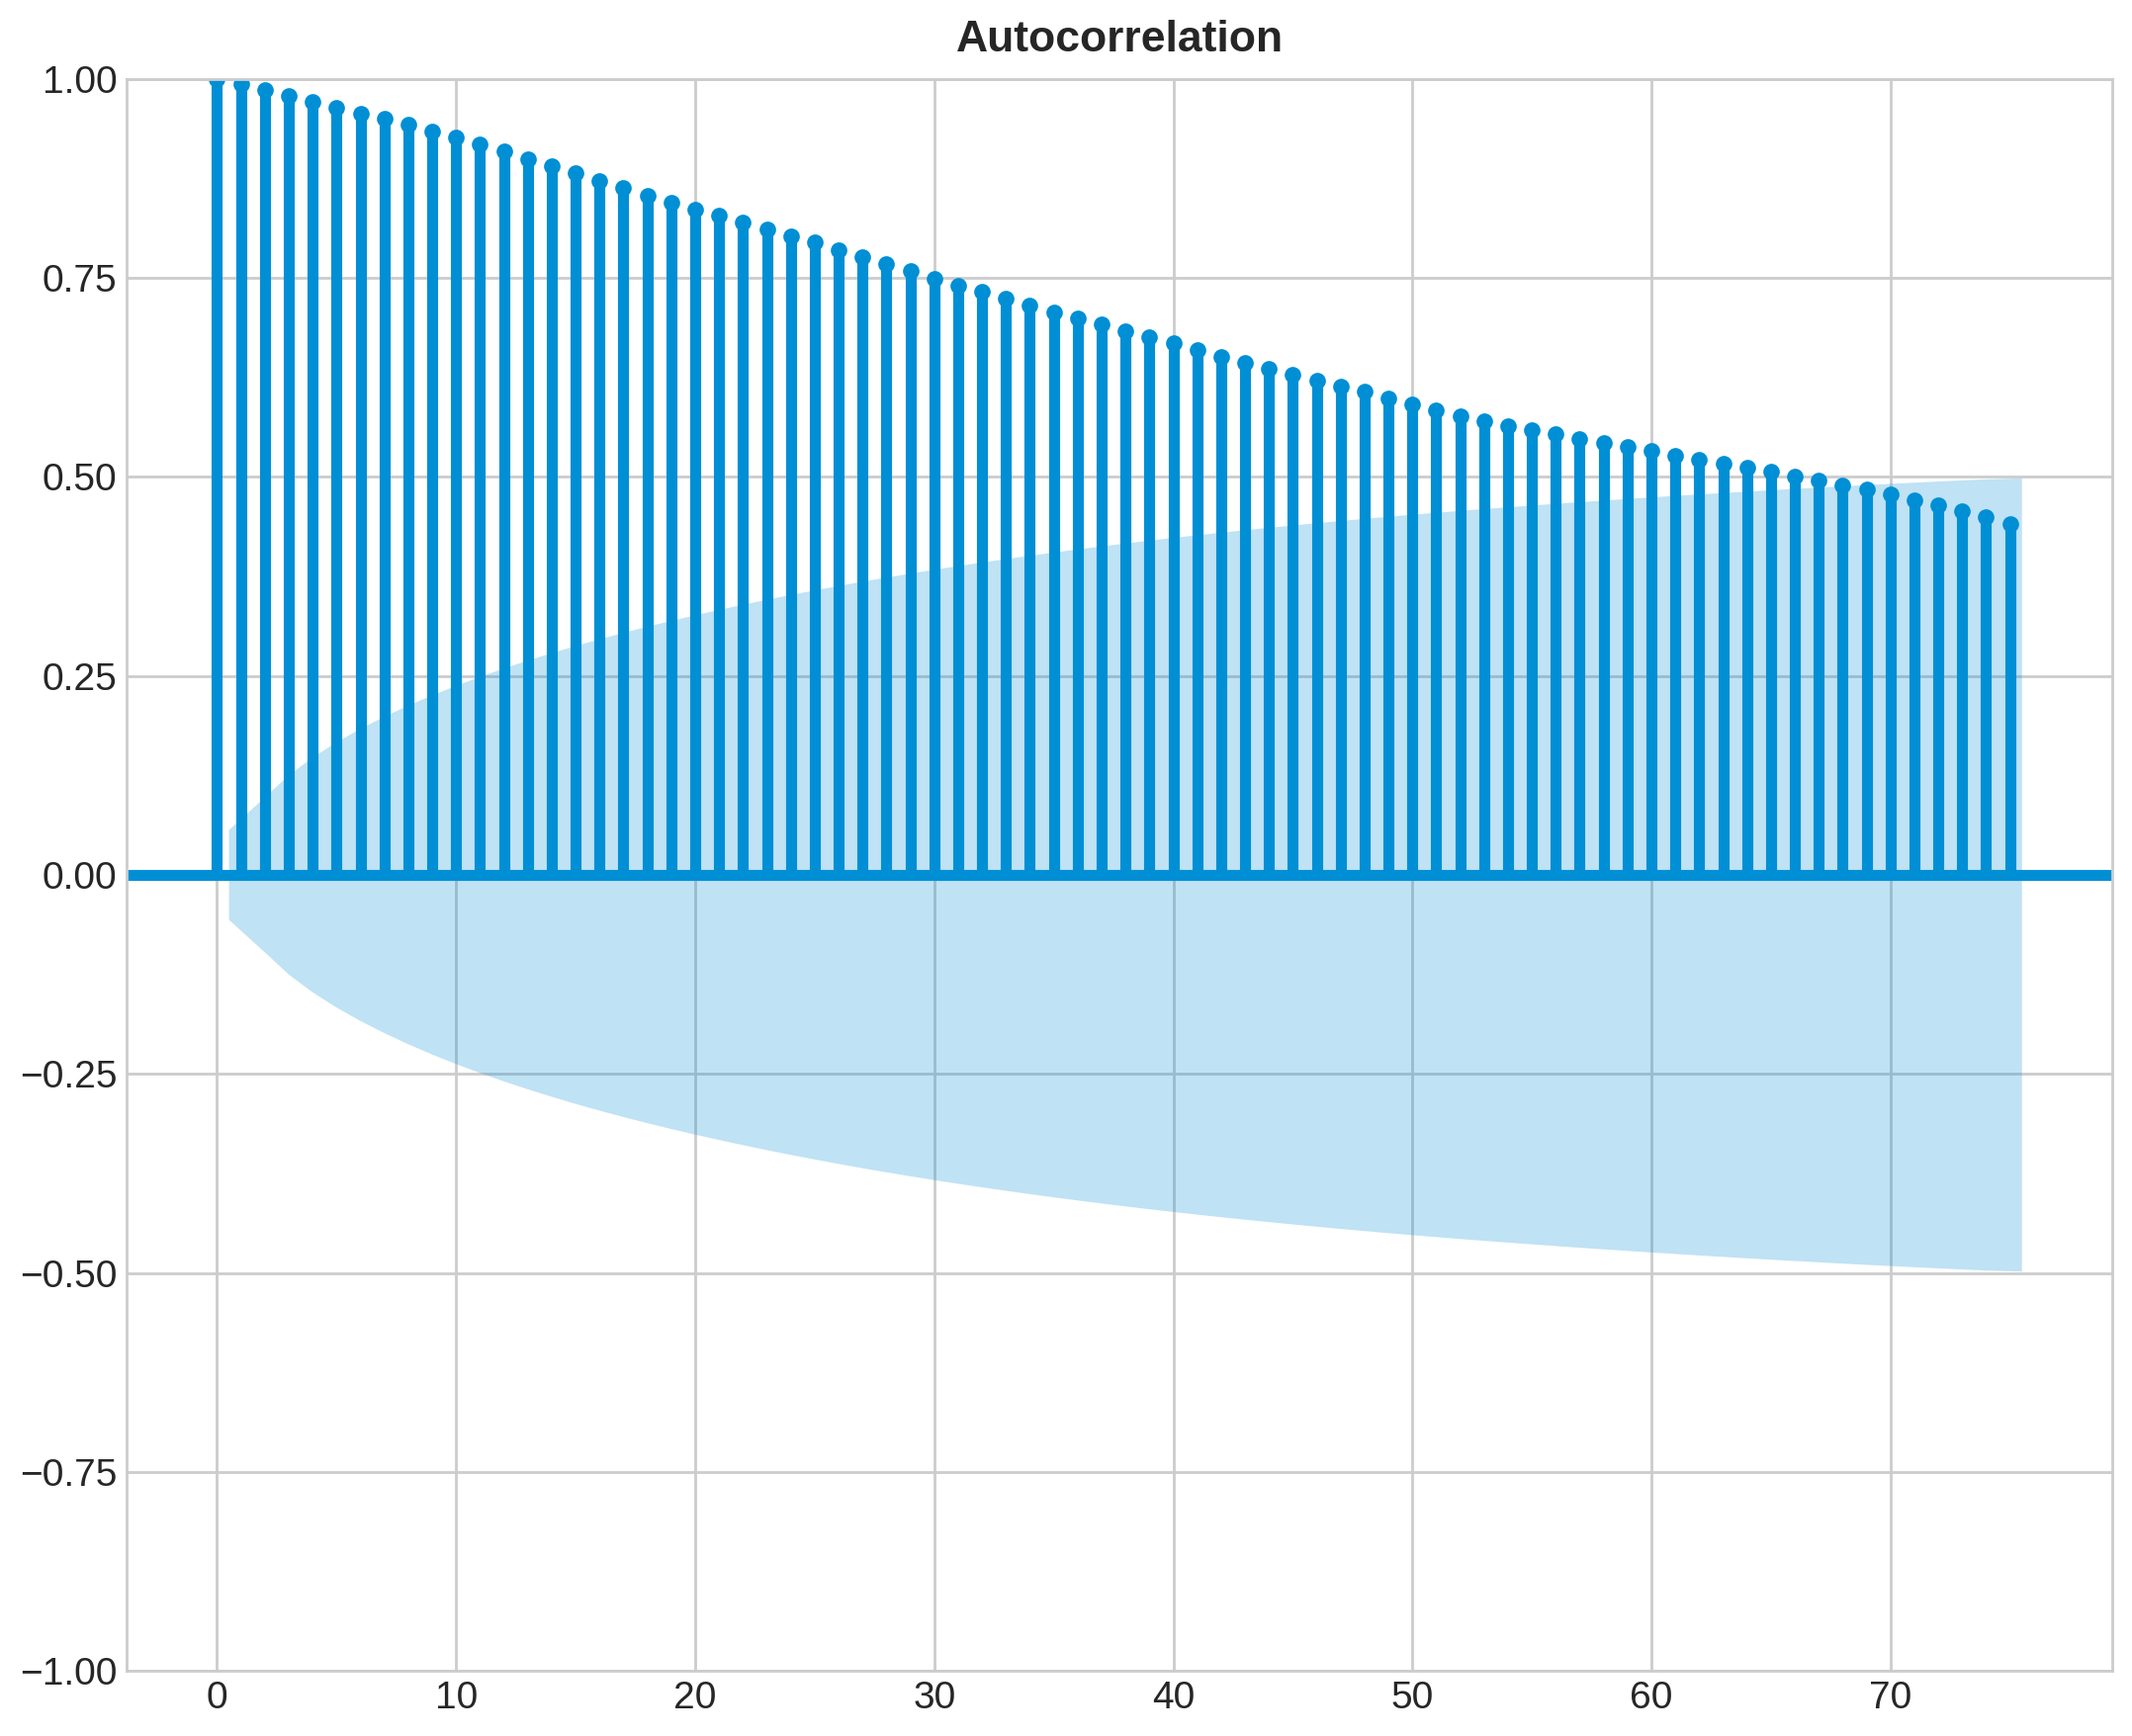

In [ ]:
plot_acf(sim2, lags=75)
plt.show()

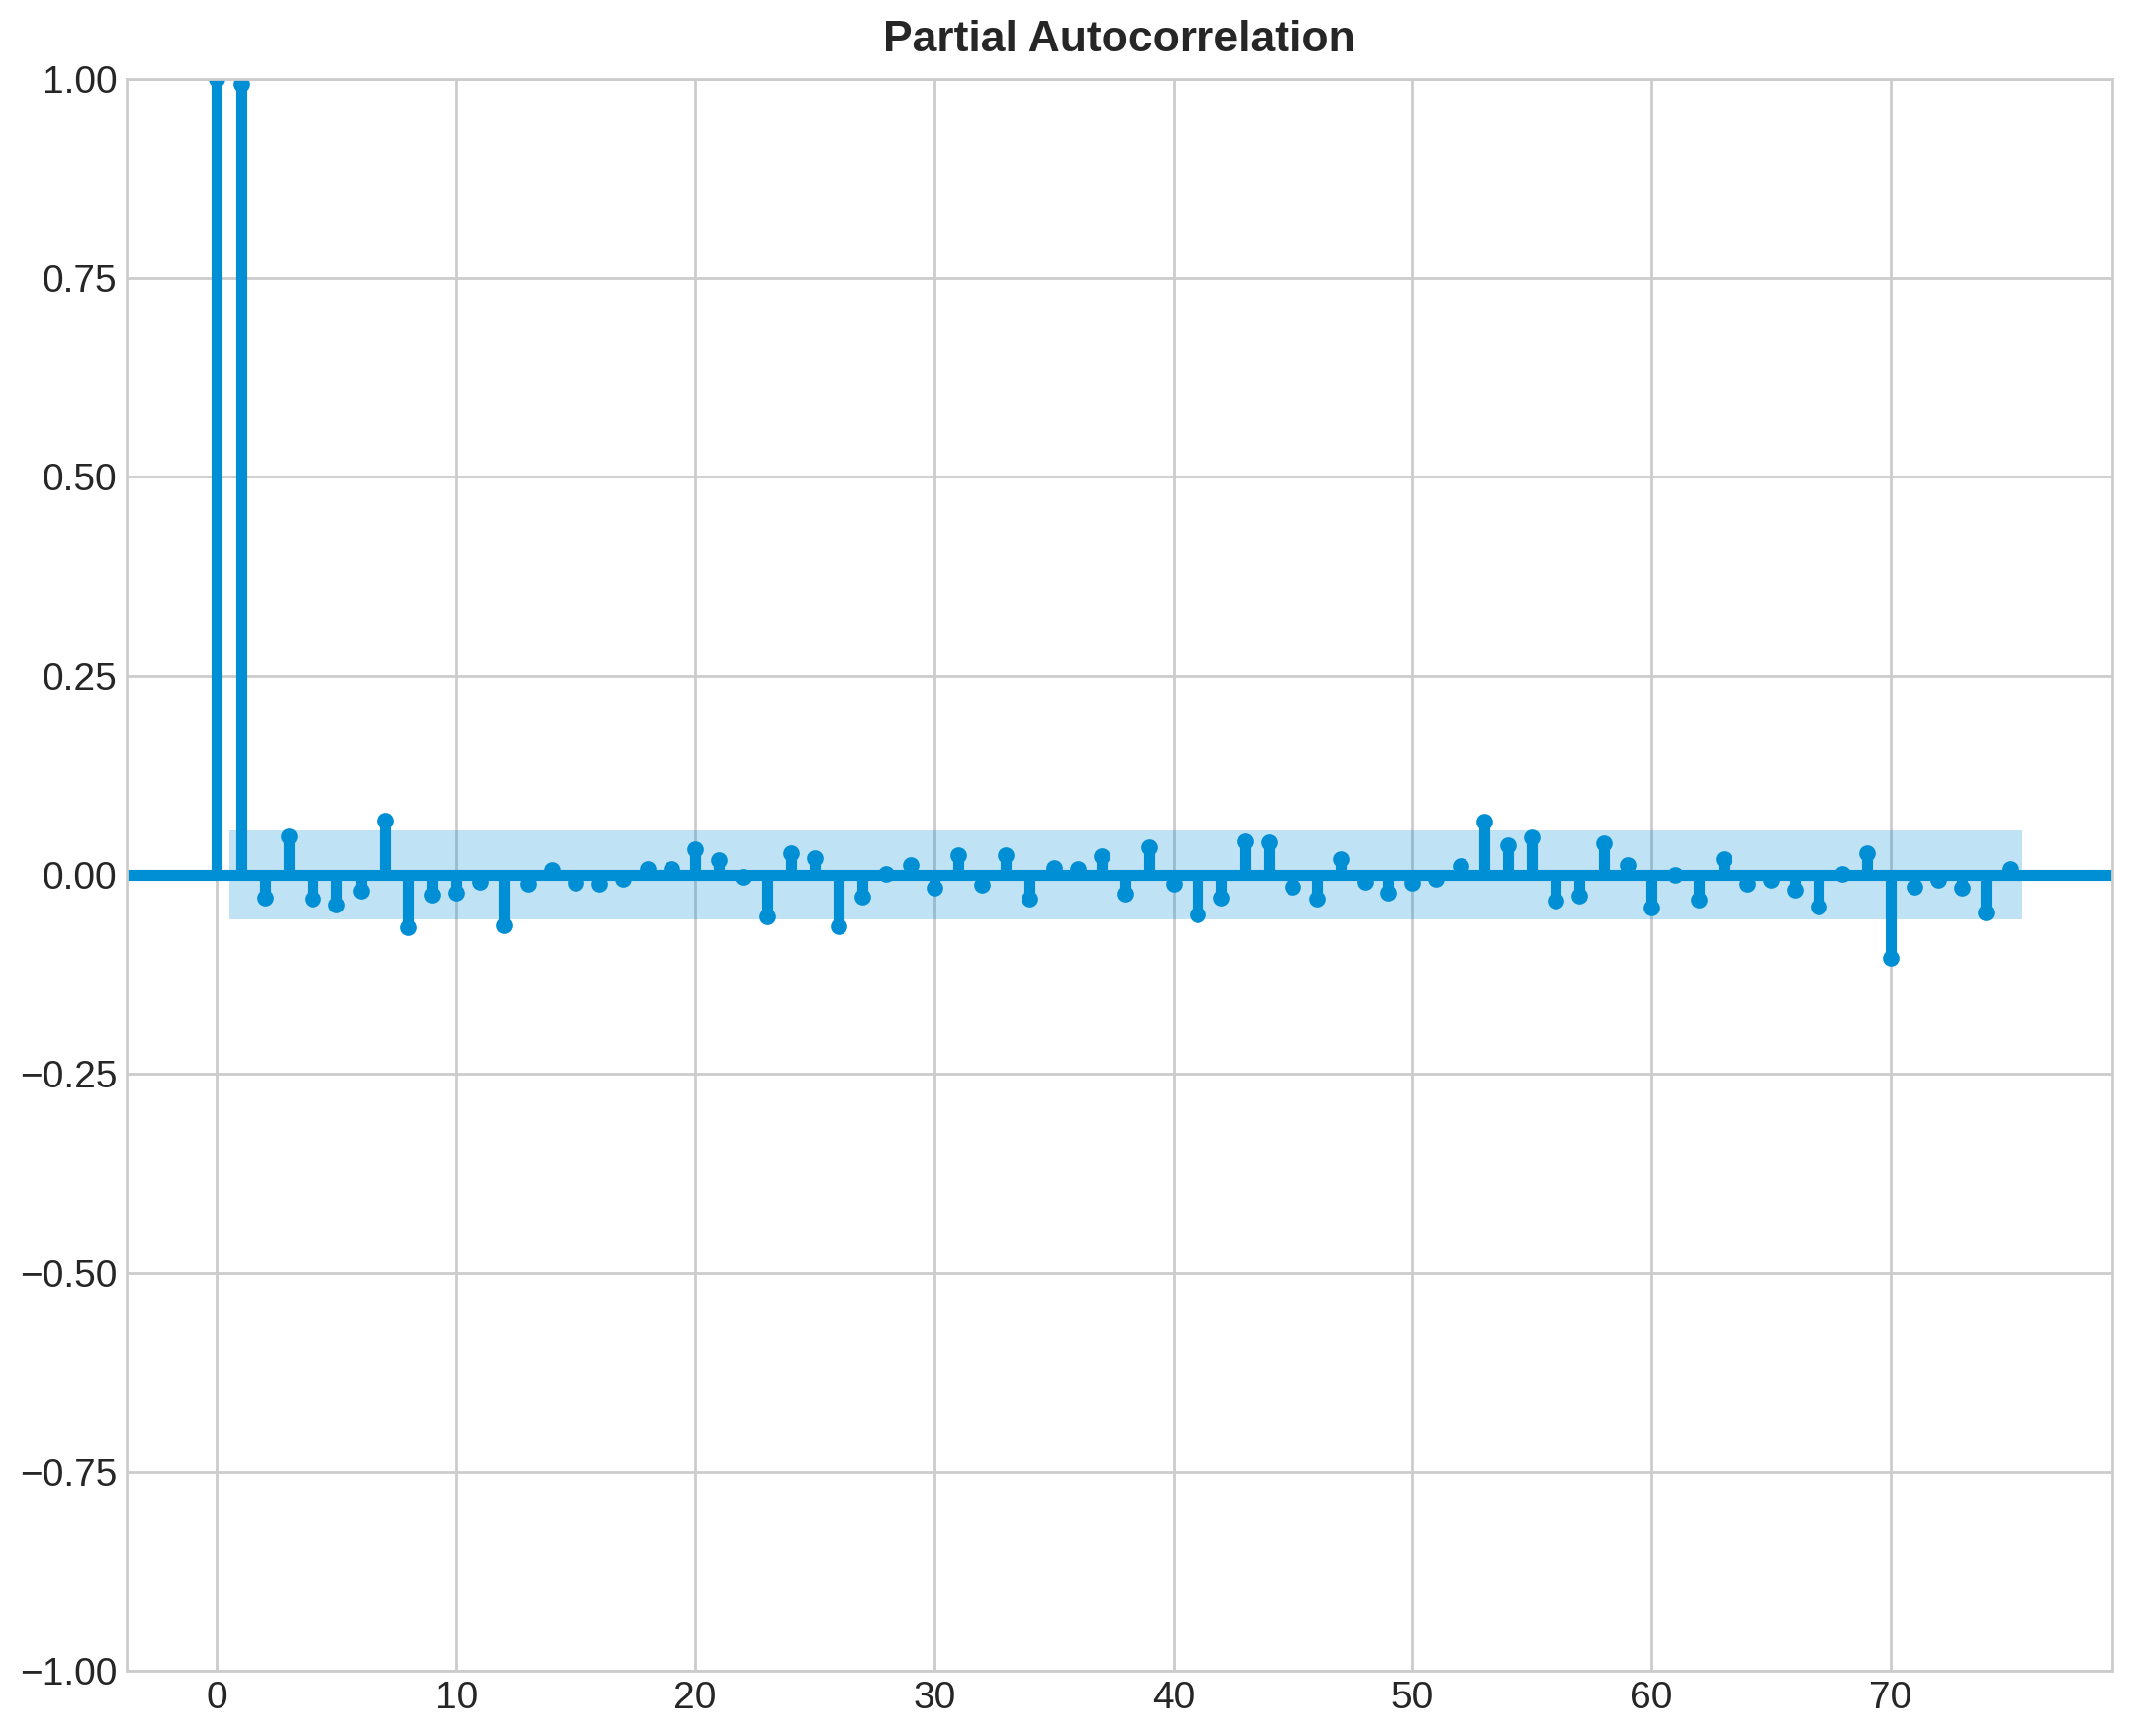

In [ ]:
plot_pacf(sim2, lags=75)
plt.show()

In [ ]:
d1=sim2-sim2.shift(1)
d1.dropna(inplace=True)

<Axes: xlabel='Date'>

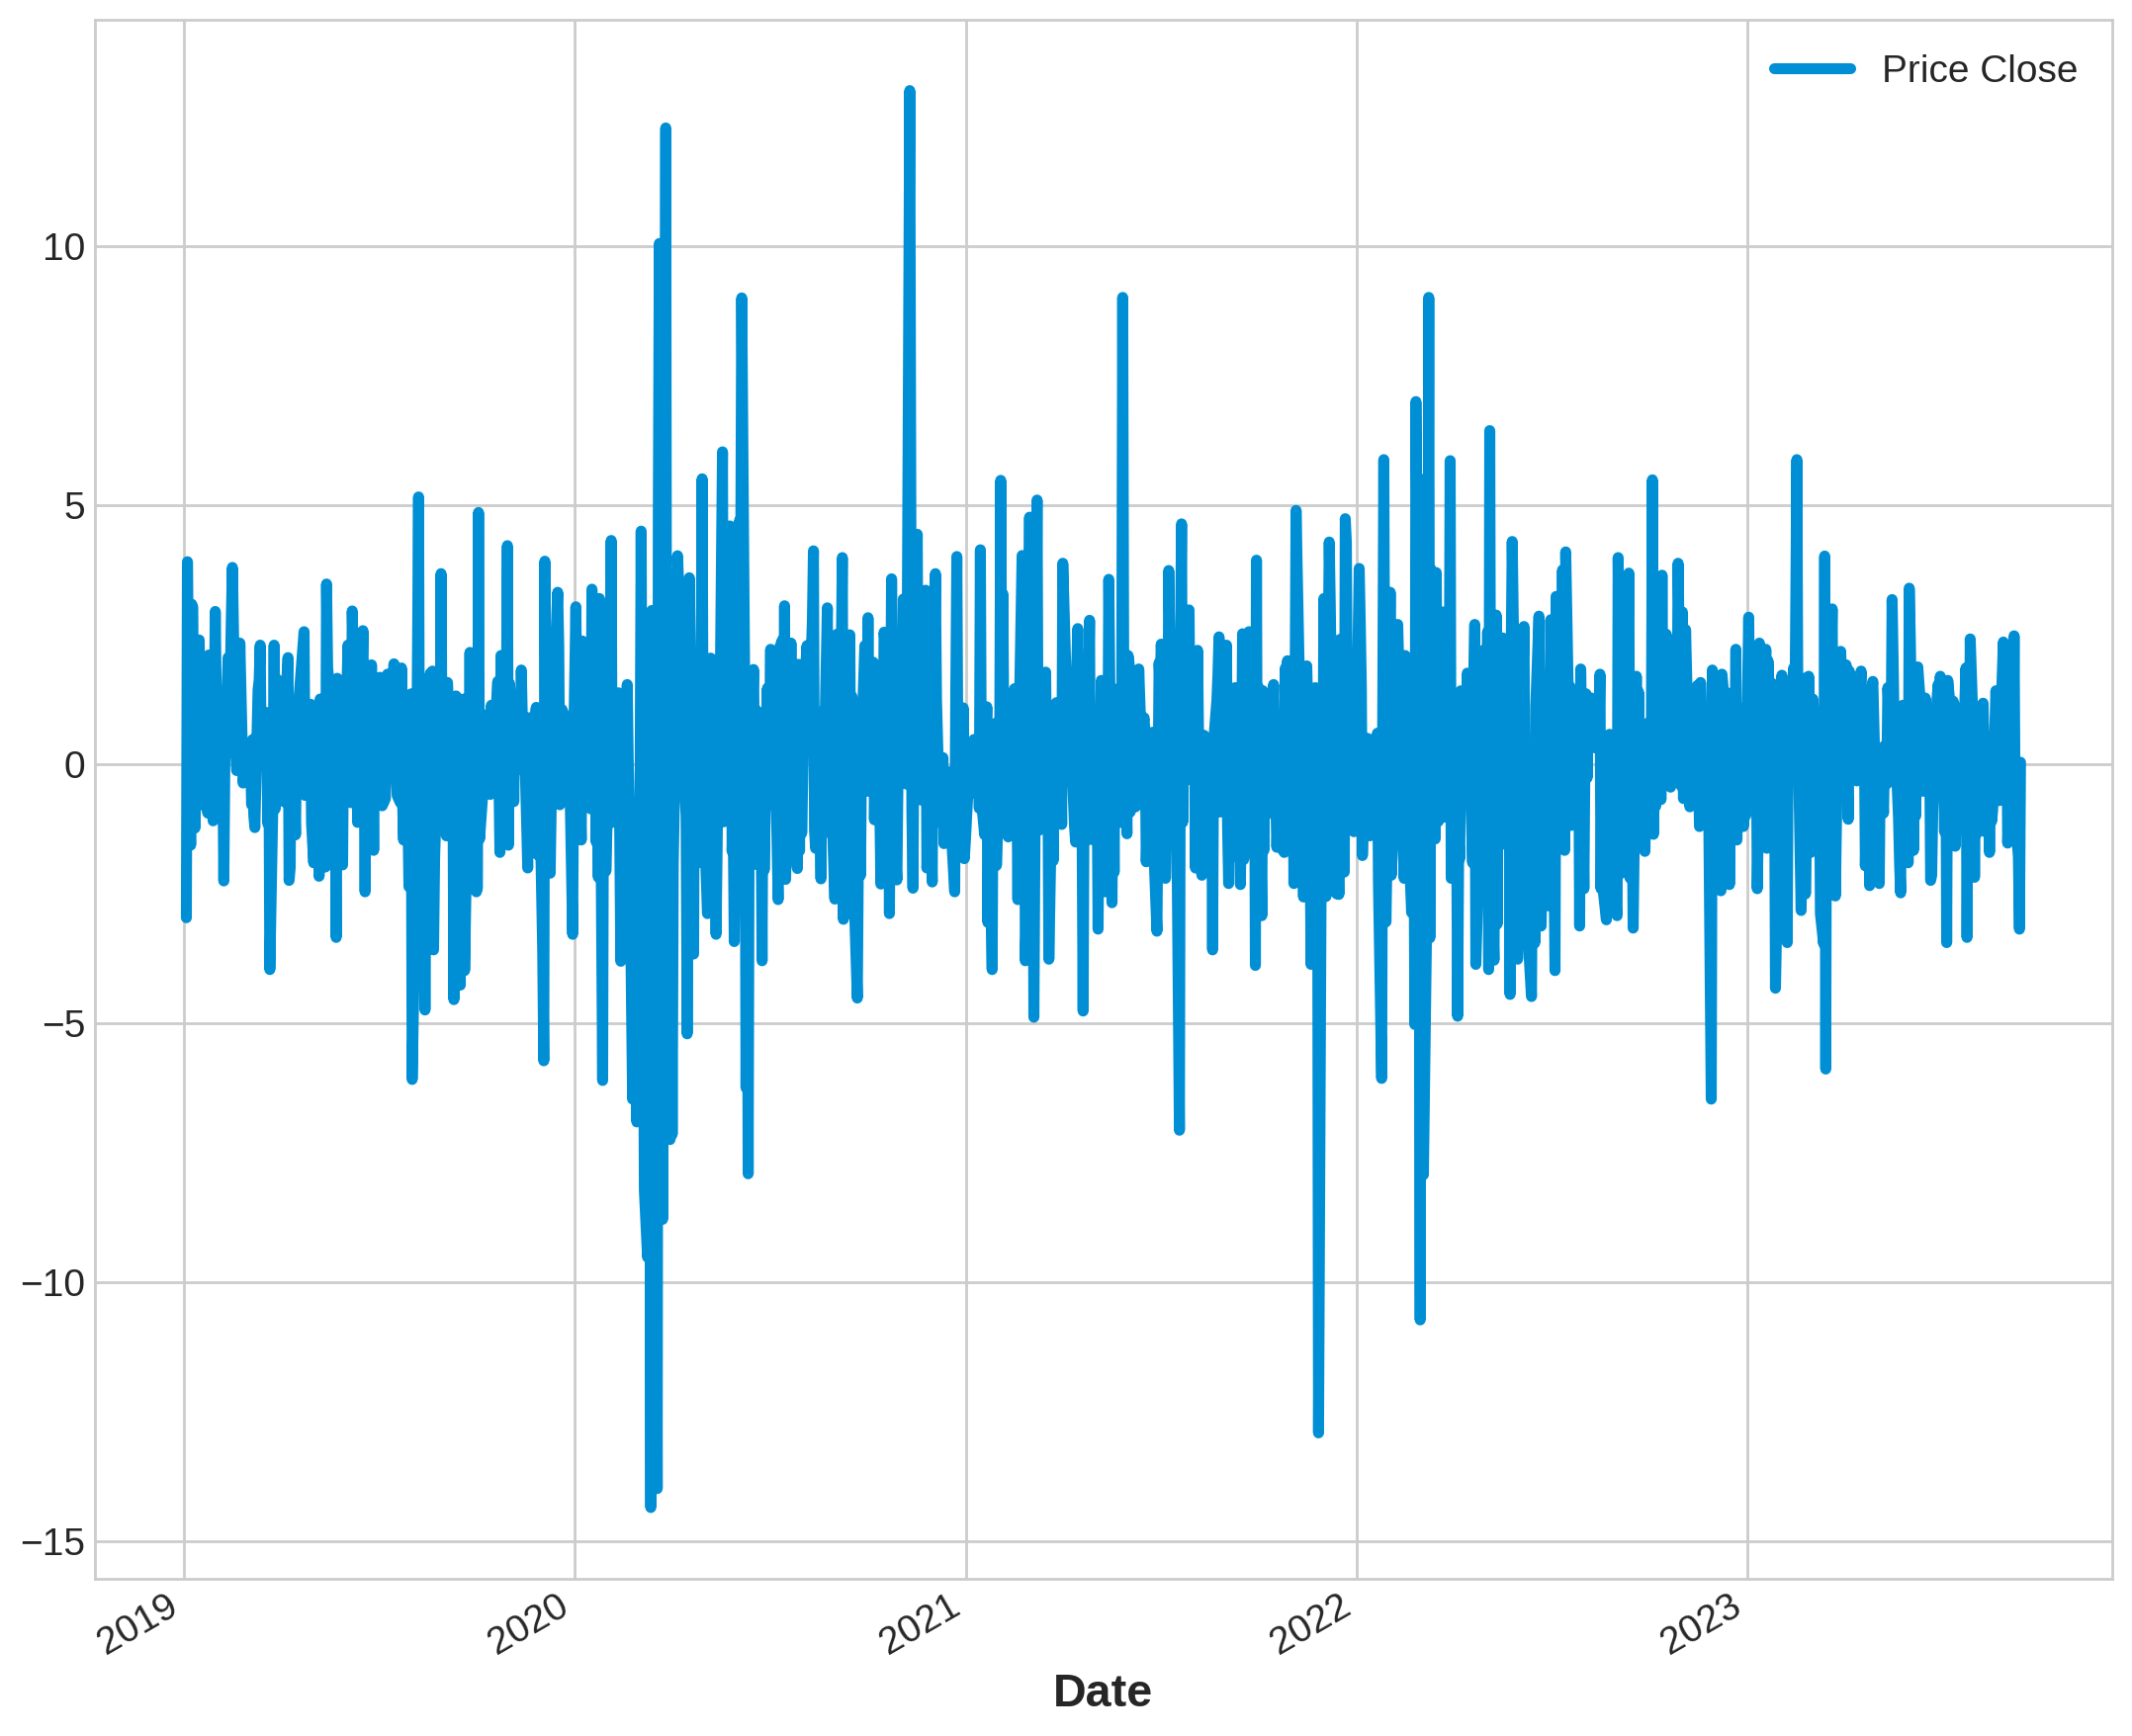

In [ ]:
d1.plot()

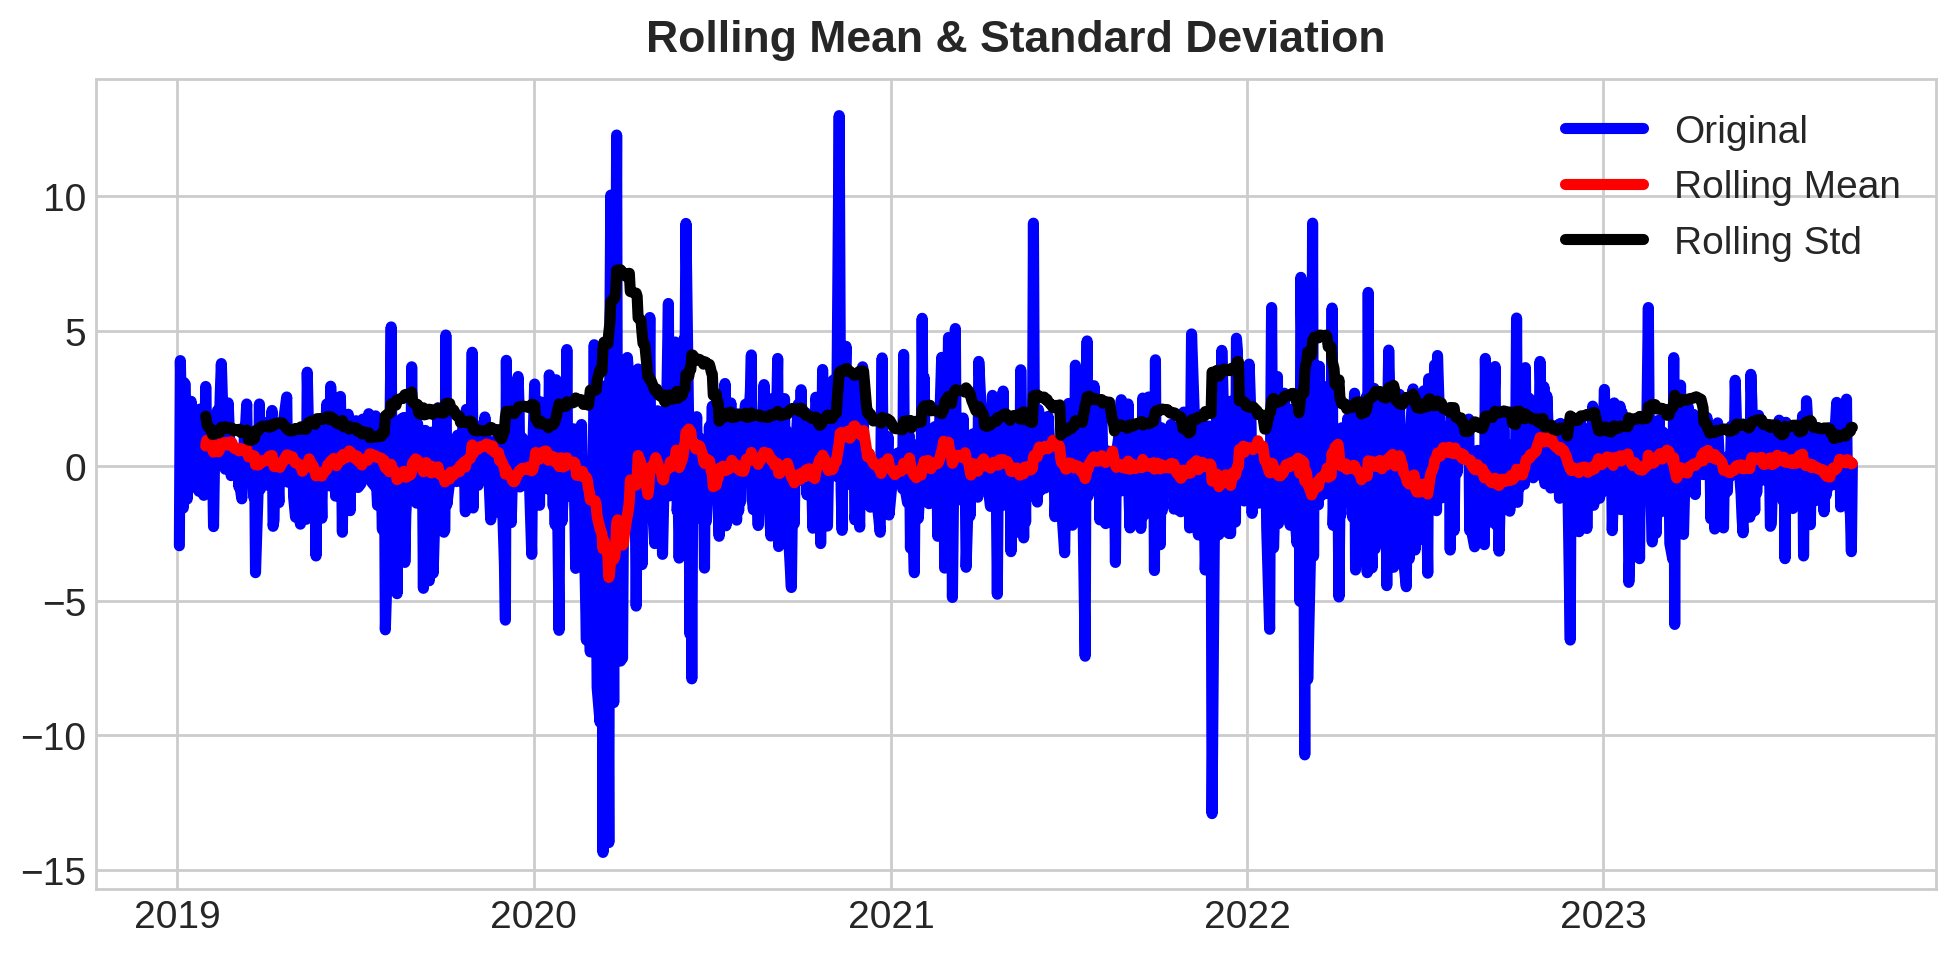

Results of Dickey-Fuller Test:
Test Statistic                -8.871666e+00
p-value                        1.392631e-14
#Lags Used                     1.000000e+01
Number of Observations Used    1.195000e+03
Critical Value (1%)           -3.435834e+00
Critical Value (5%)           -2.863962e+00
Critical Value (10%)          -2.568059e+00
dtype: float64


In [ ]:
StationaryTest = test_stationarity(d1)

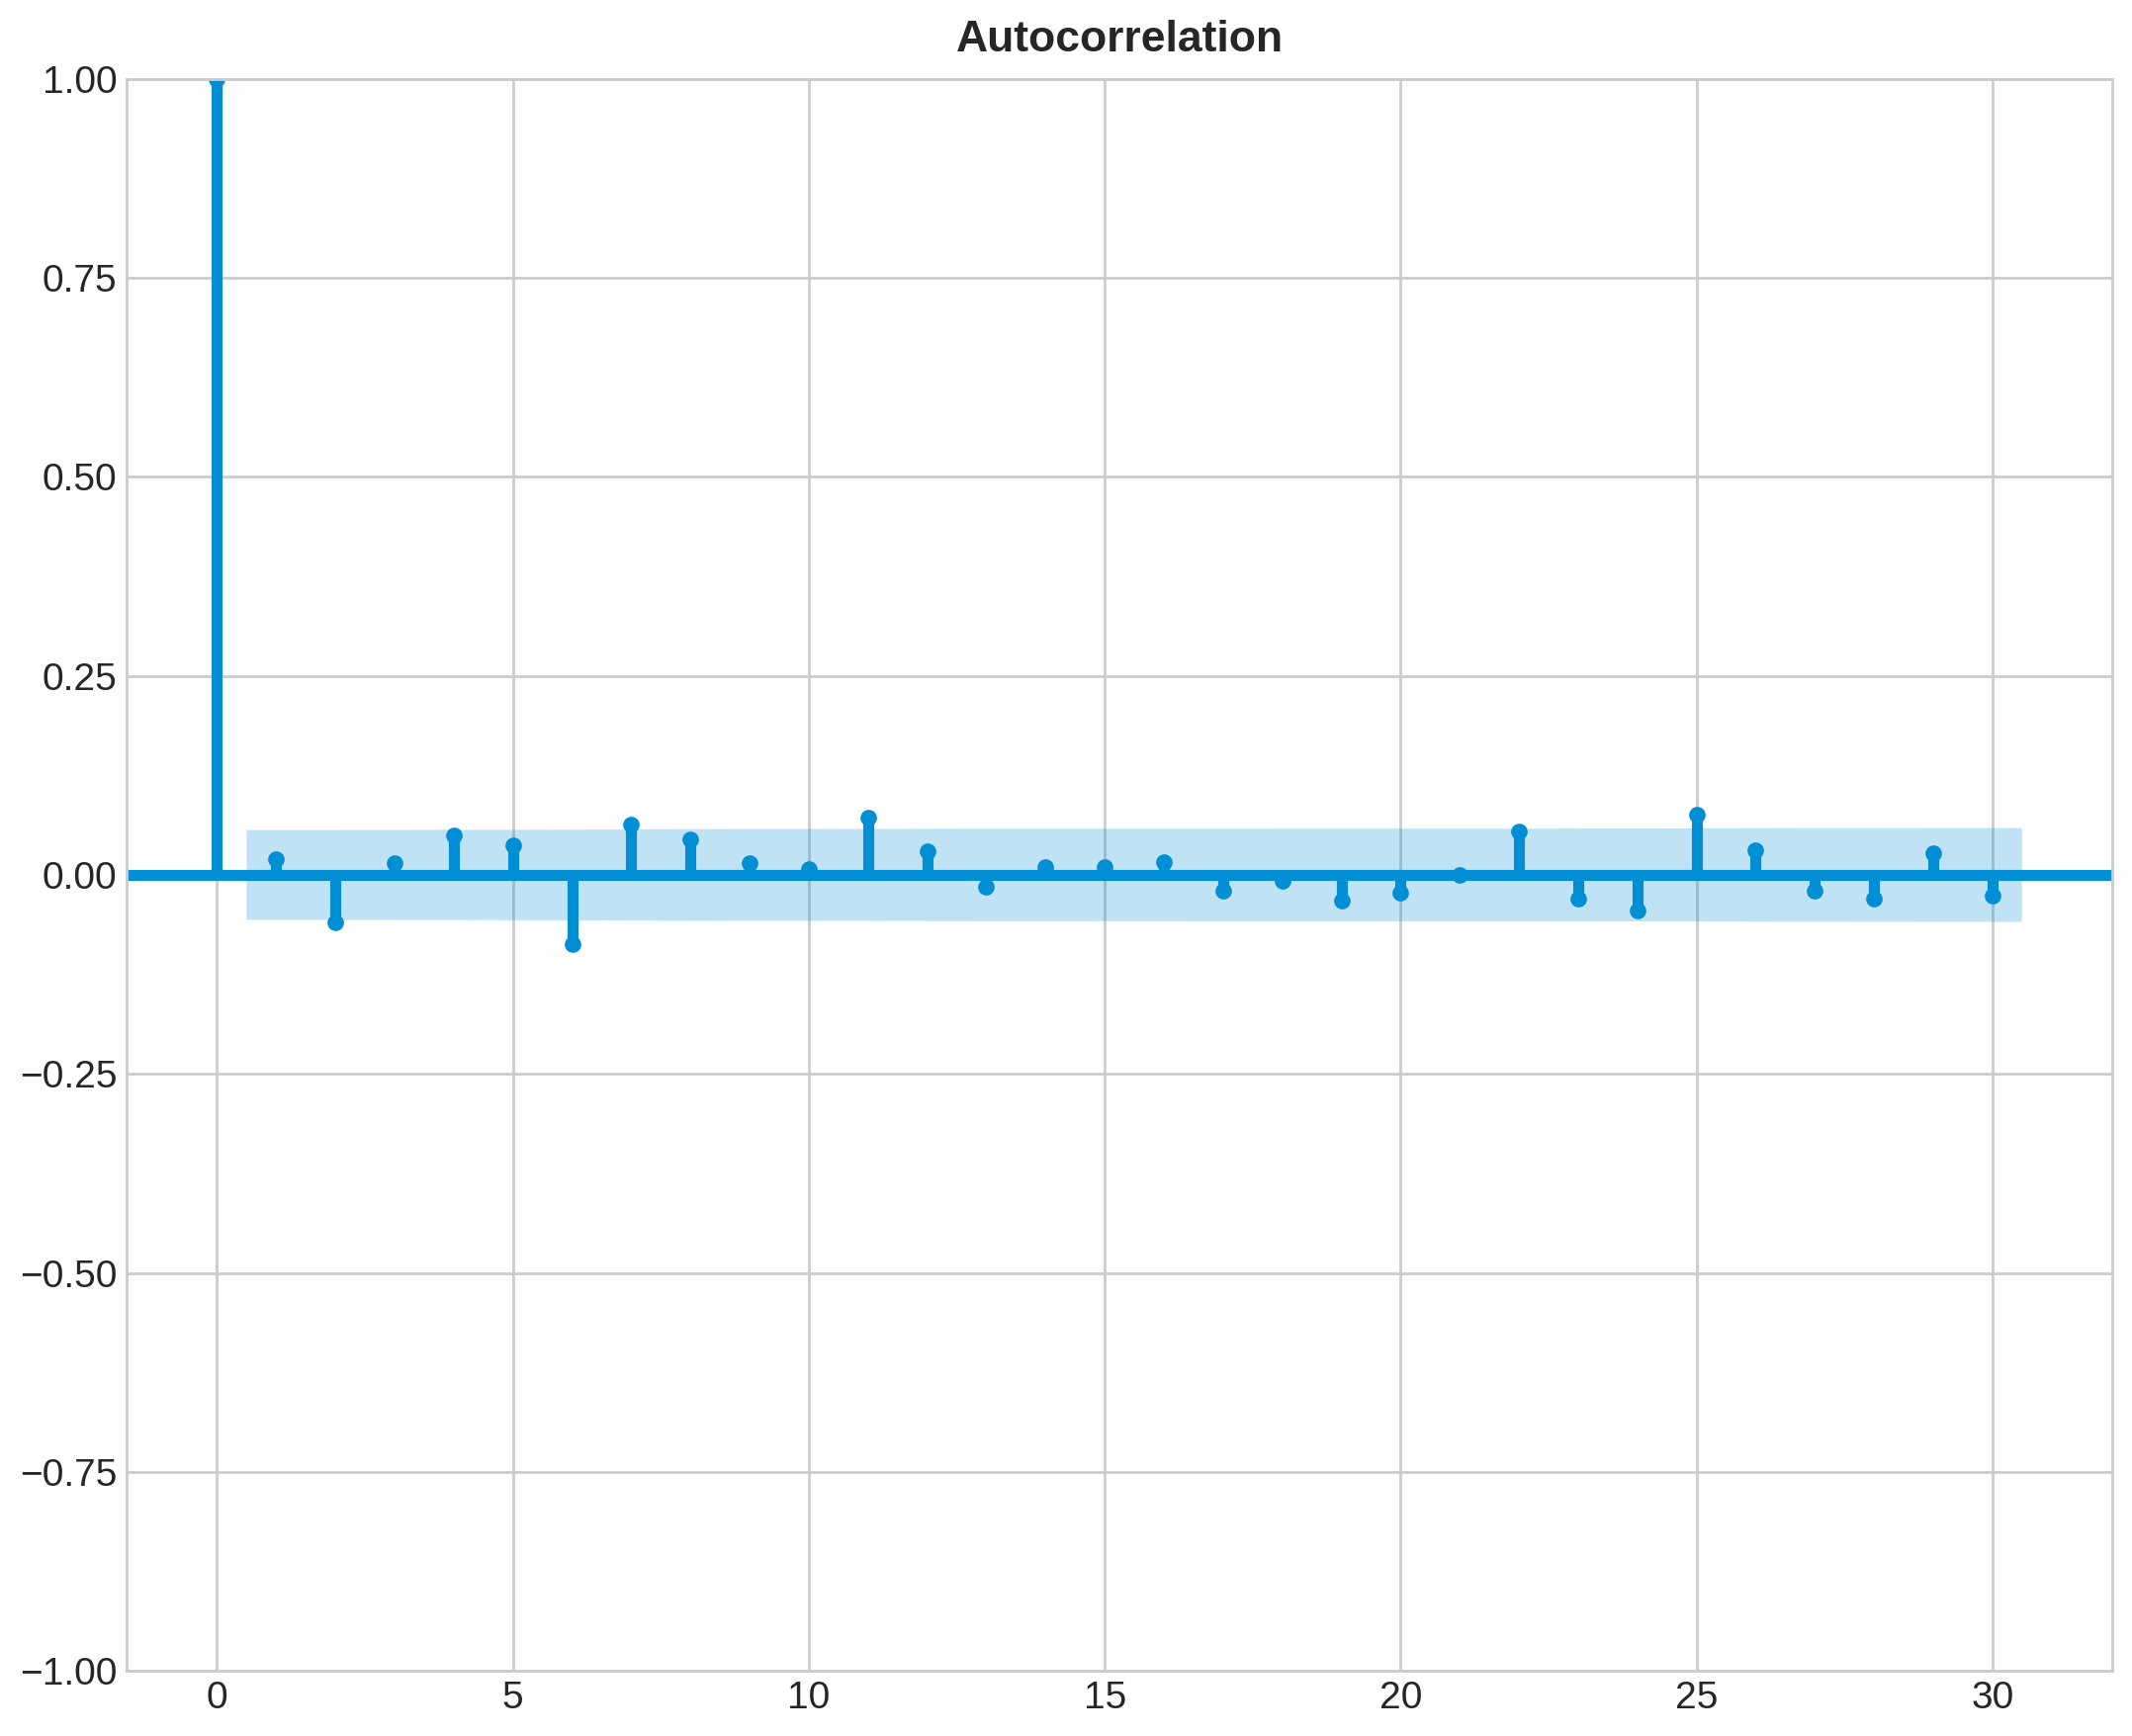

In [ ]:
plot_acf(d1, lags=30)
plt.show()

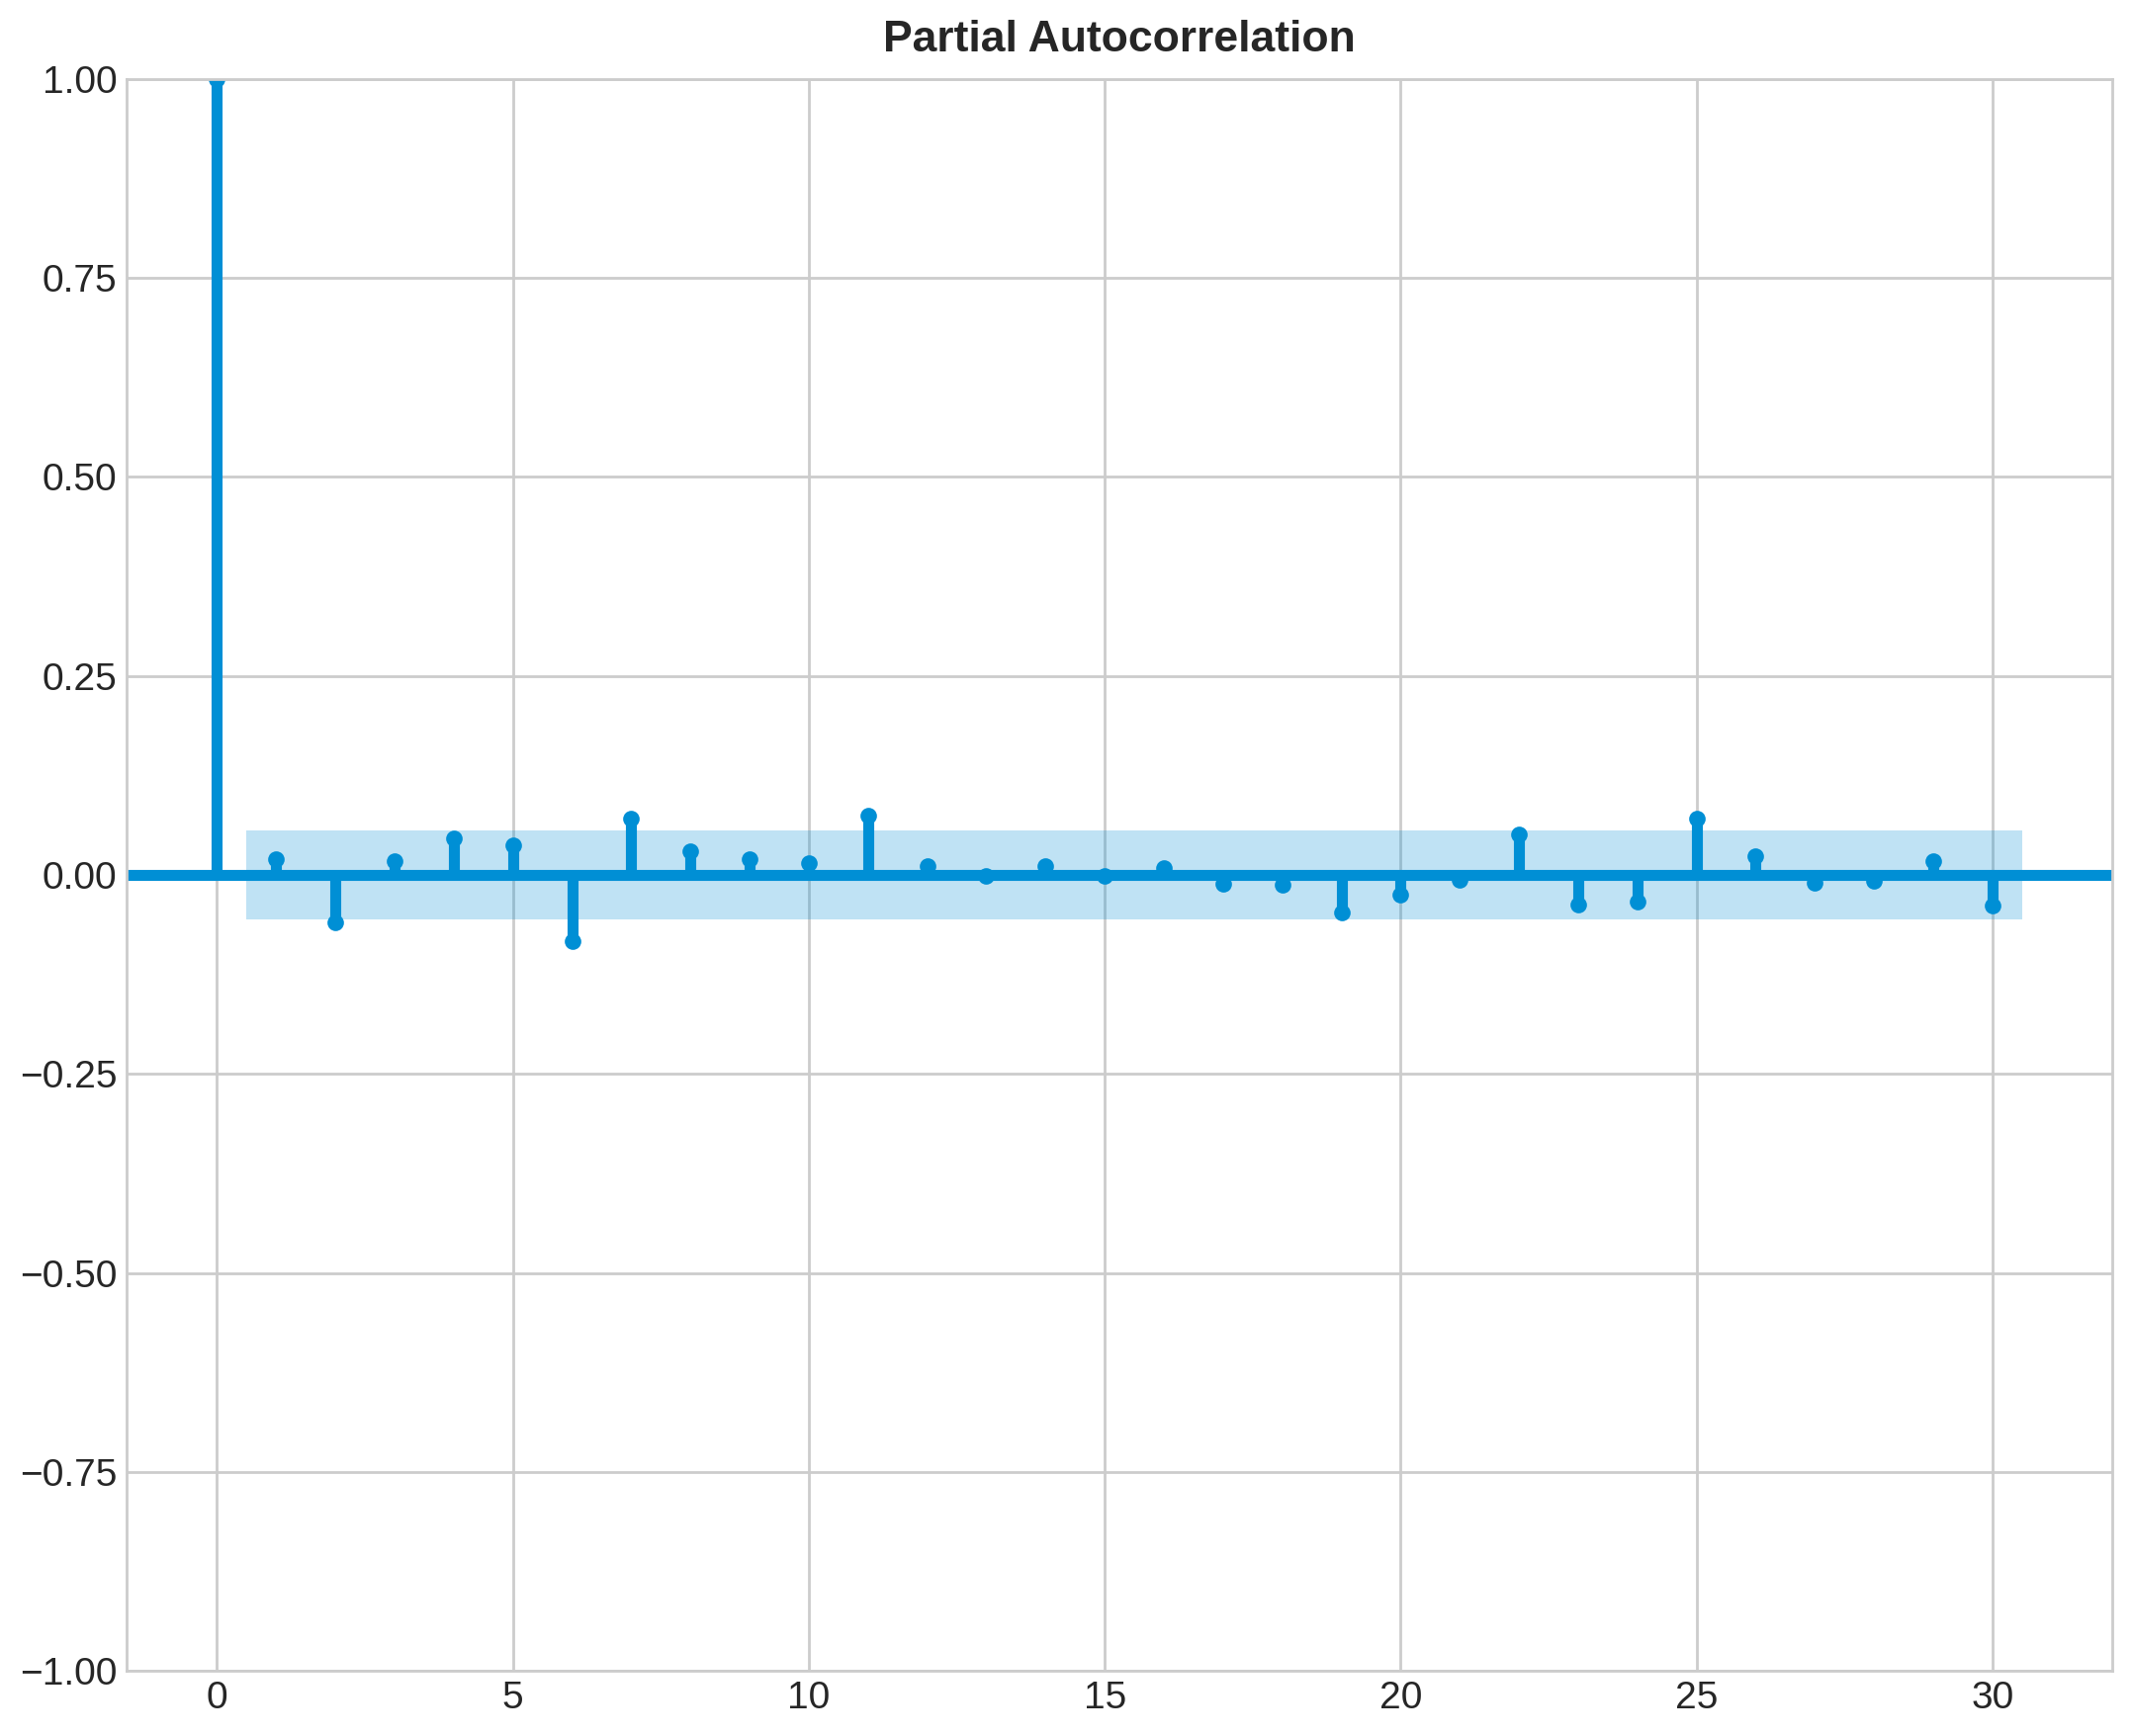

In [ ]:
plot_pacf(d1, lags=30)
plt.show()

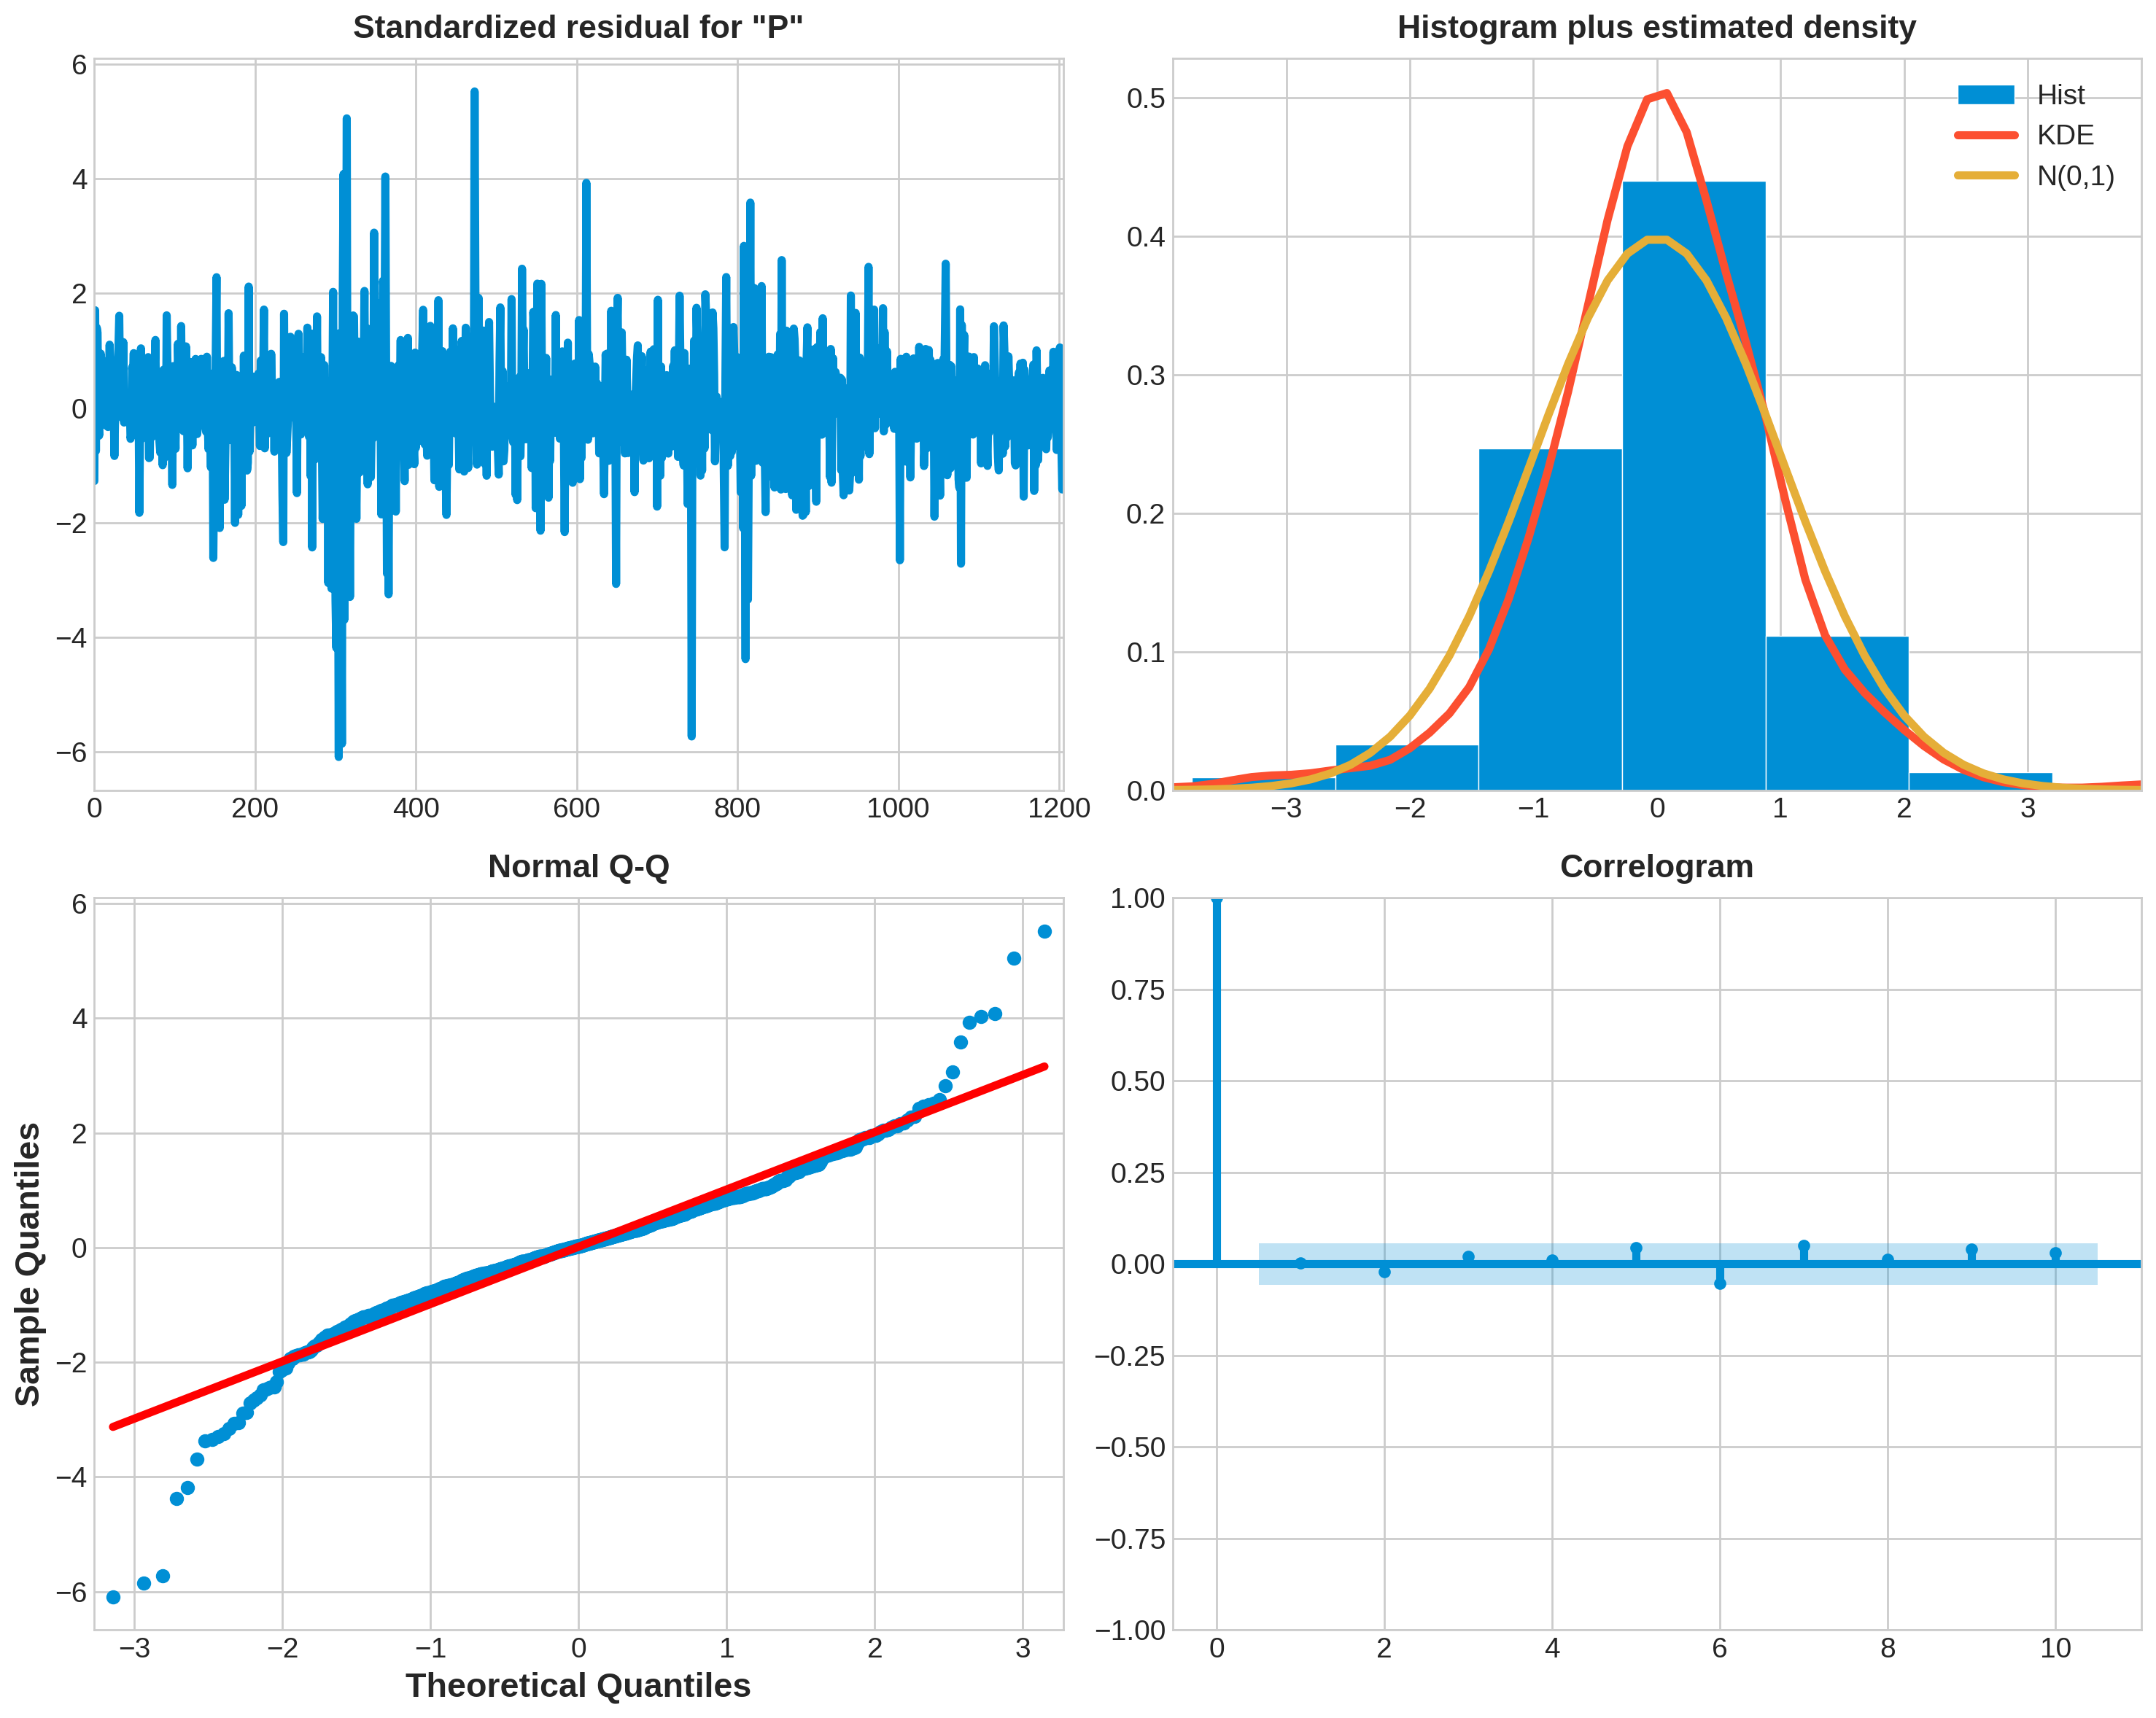

In [ ]:
mod = sm.tsa.statespace.SARIMAX(sim2,
                                order=(2, 1, 2))

results2 = mod.fit()

results2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Price Close   No. Observations:                 1207
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2713.336
Date:                Wed, 15 Nov 2023   AIC                           5436.672
Time:                        03:52:34   BIC                           5462.147
Sample:                             0   HQIC                          5446.266
                               - 1207                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3088      0.008    -37.000      0.000      -0.325      -0.292
ar.L2         -0.9863      0.007   -137.761      0.000      -1.000      -0.972
ma.L1          0.3297      0.012     28.296      0.000       0.307       0.353
ma.L2          0.9760      0.011     89.945      0.000       0.955       0.997
sigma2         5.2717      0.119     44.275      0.000       5.038       5.505
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1509.63
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

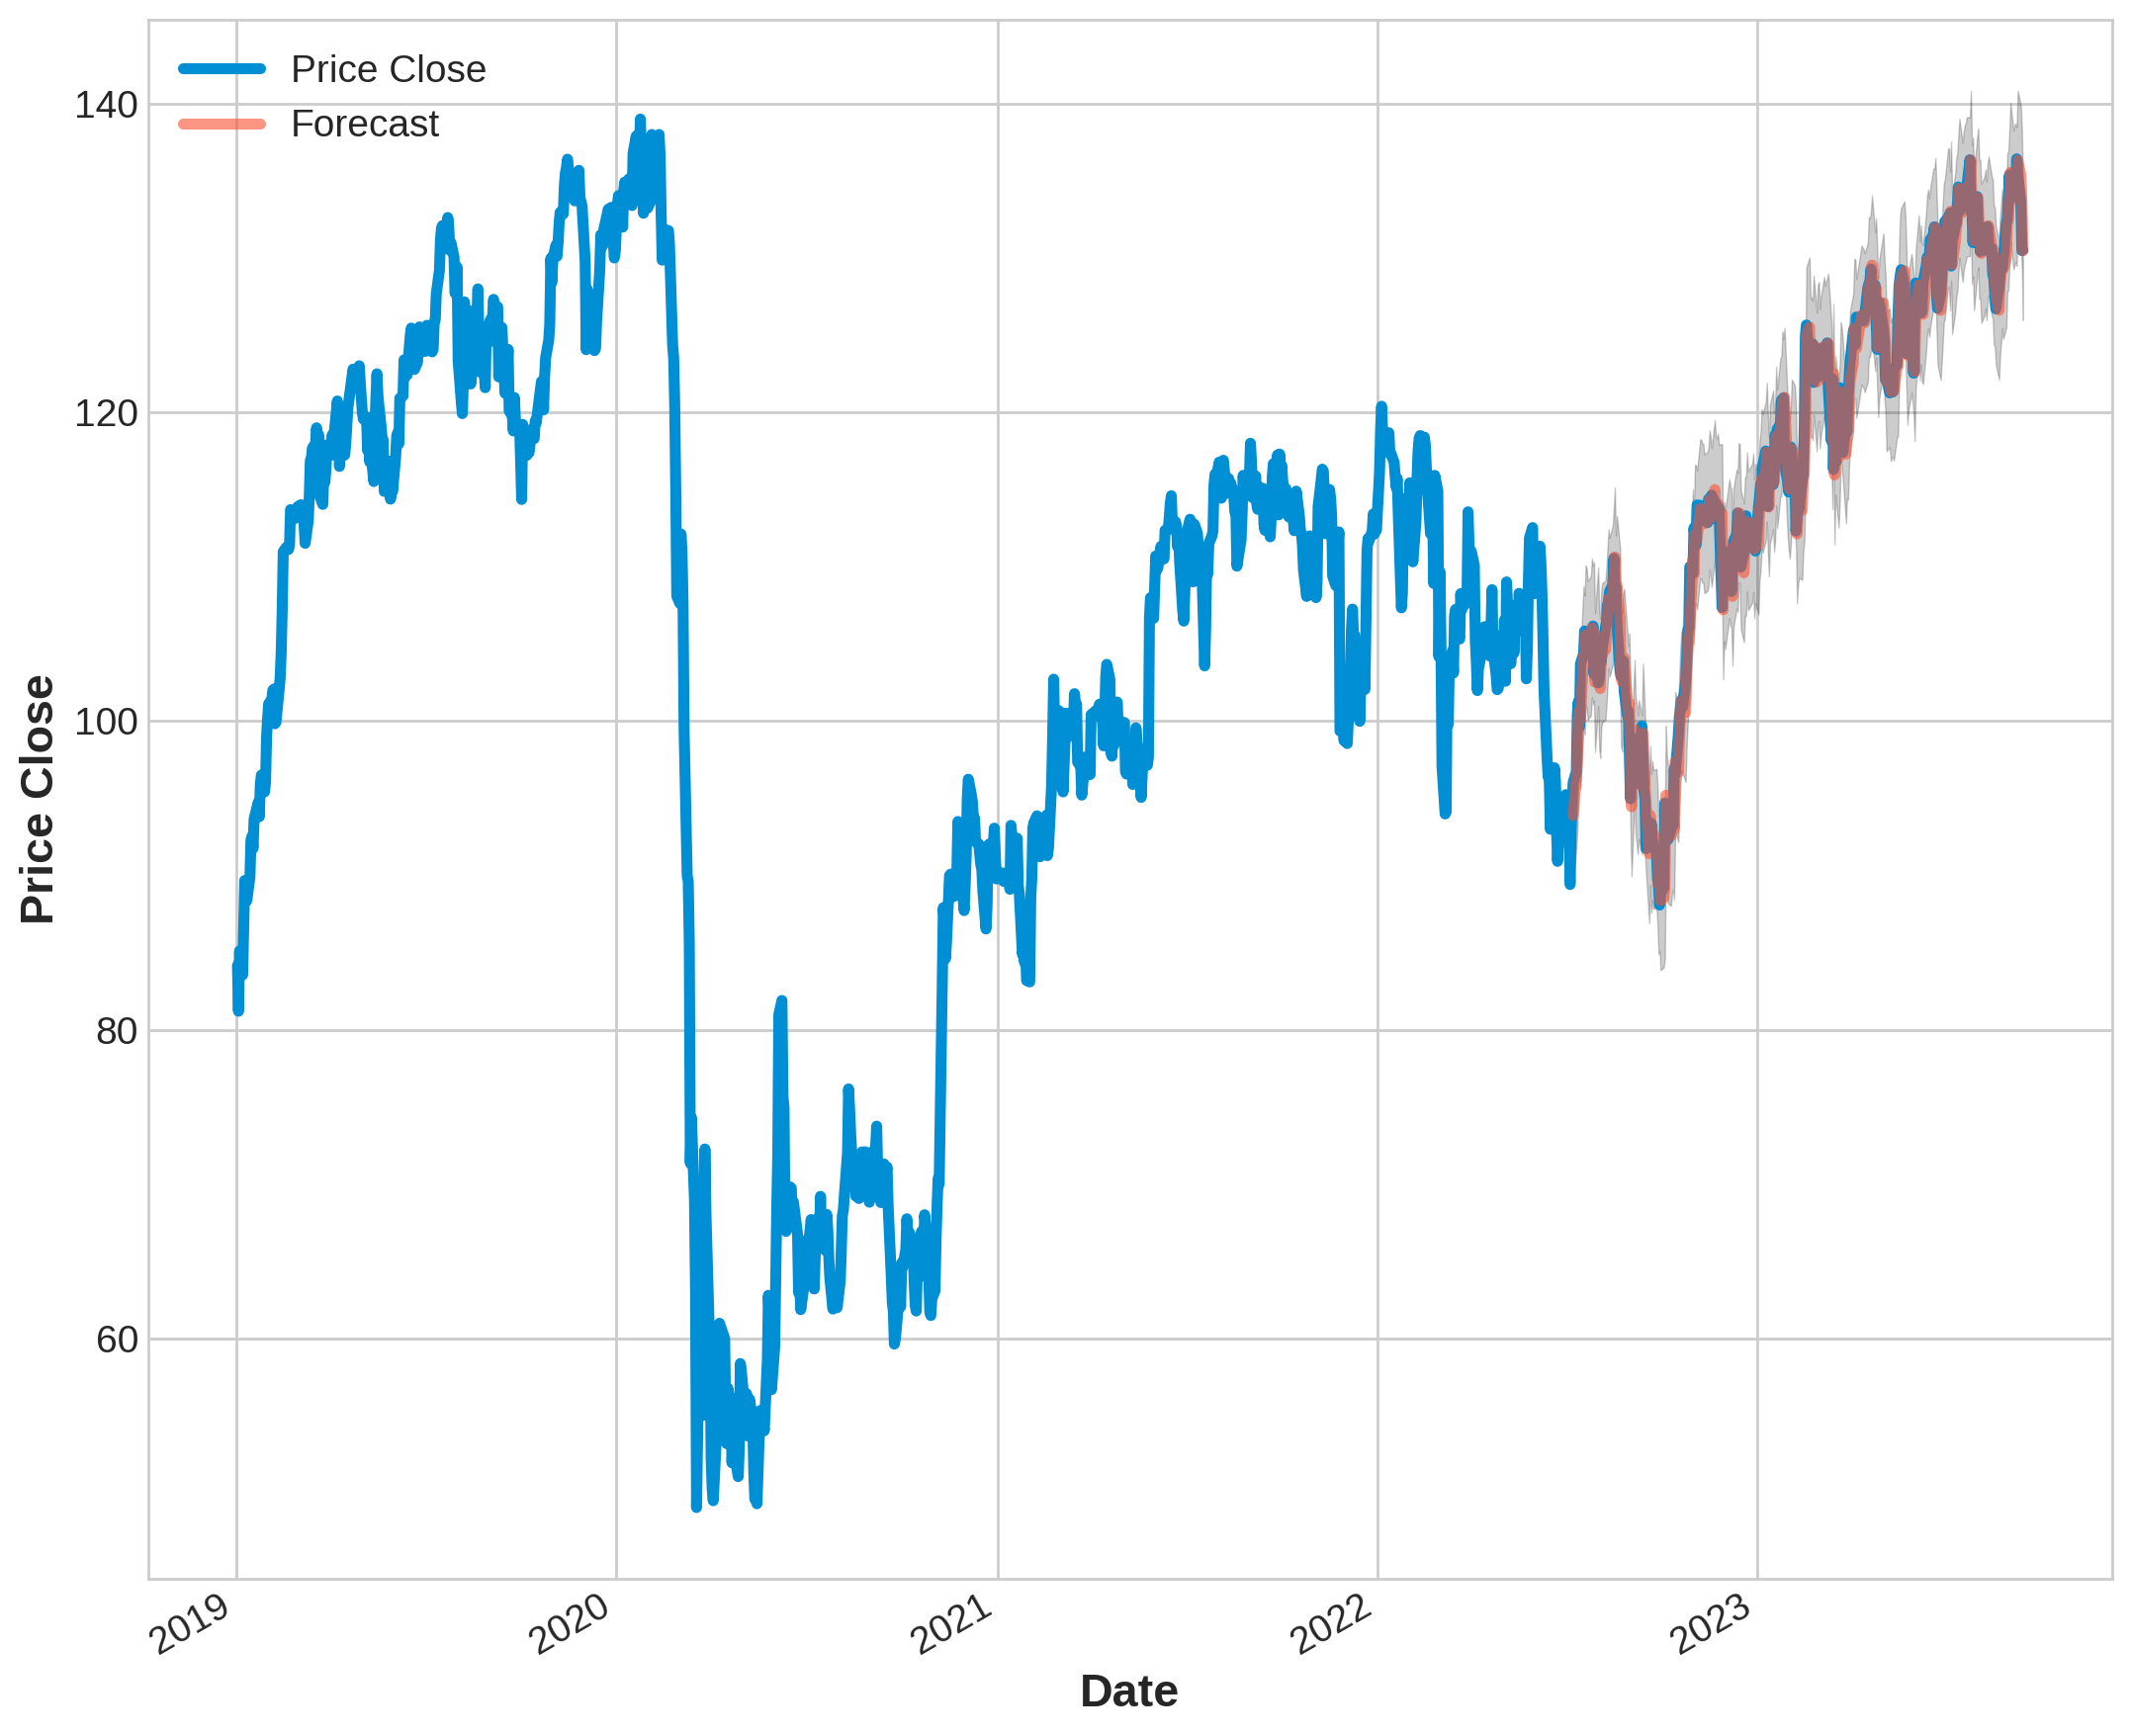

In [ ]:
pred2 = results2.get_prediction(start=902, dynamic=False)
pred_ci2 = pred2.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim2.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci2.index, pred_ci2.iloc[:, 0], pred_ci2.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price Close')
plt.legend()

plt.show()

In [ ]:
predictions = results2.predict(902,1206)
rmse = mean_squared_error(sim2[902:], predictions)**0.5
print(f"RMSE: {rmse:.2f}\n")

RMSE: 1.71



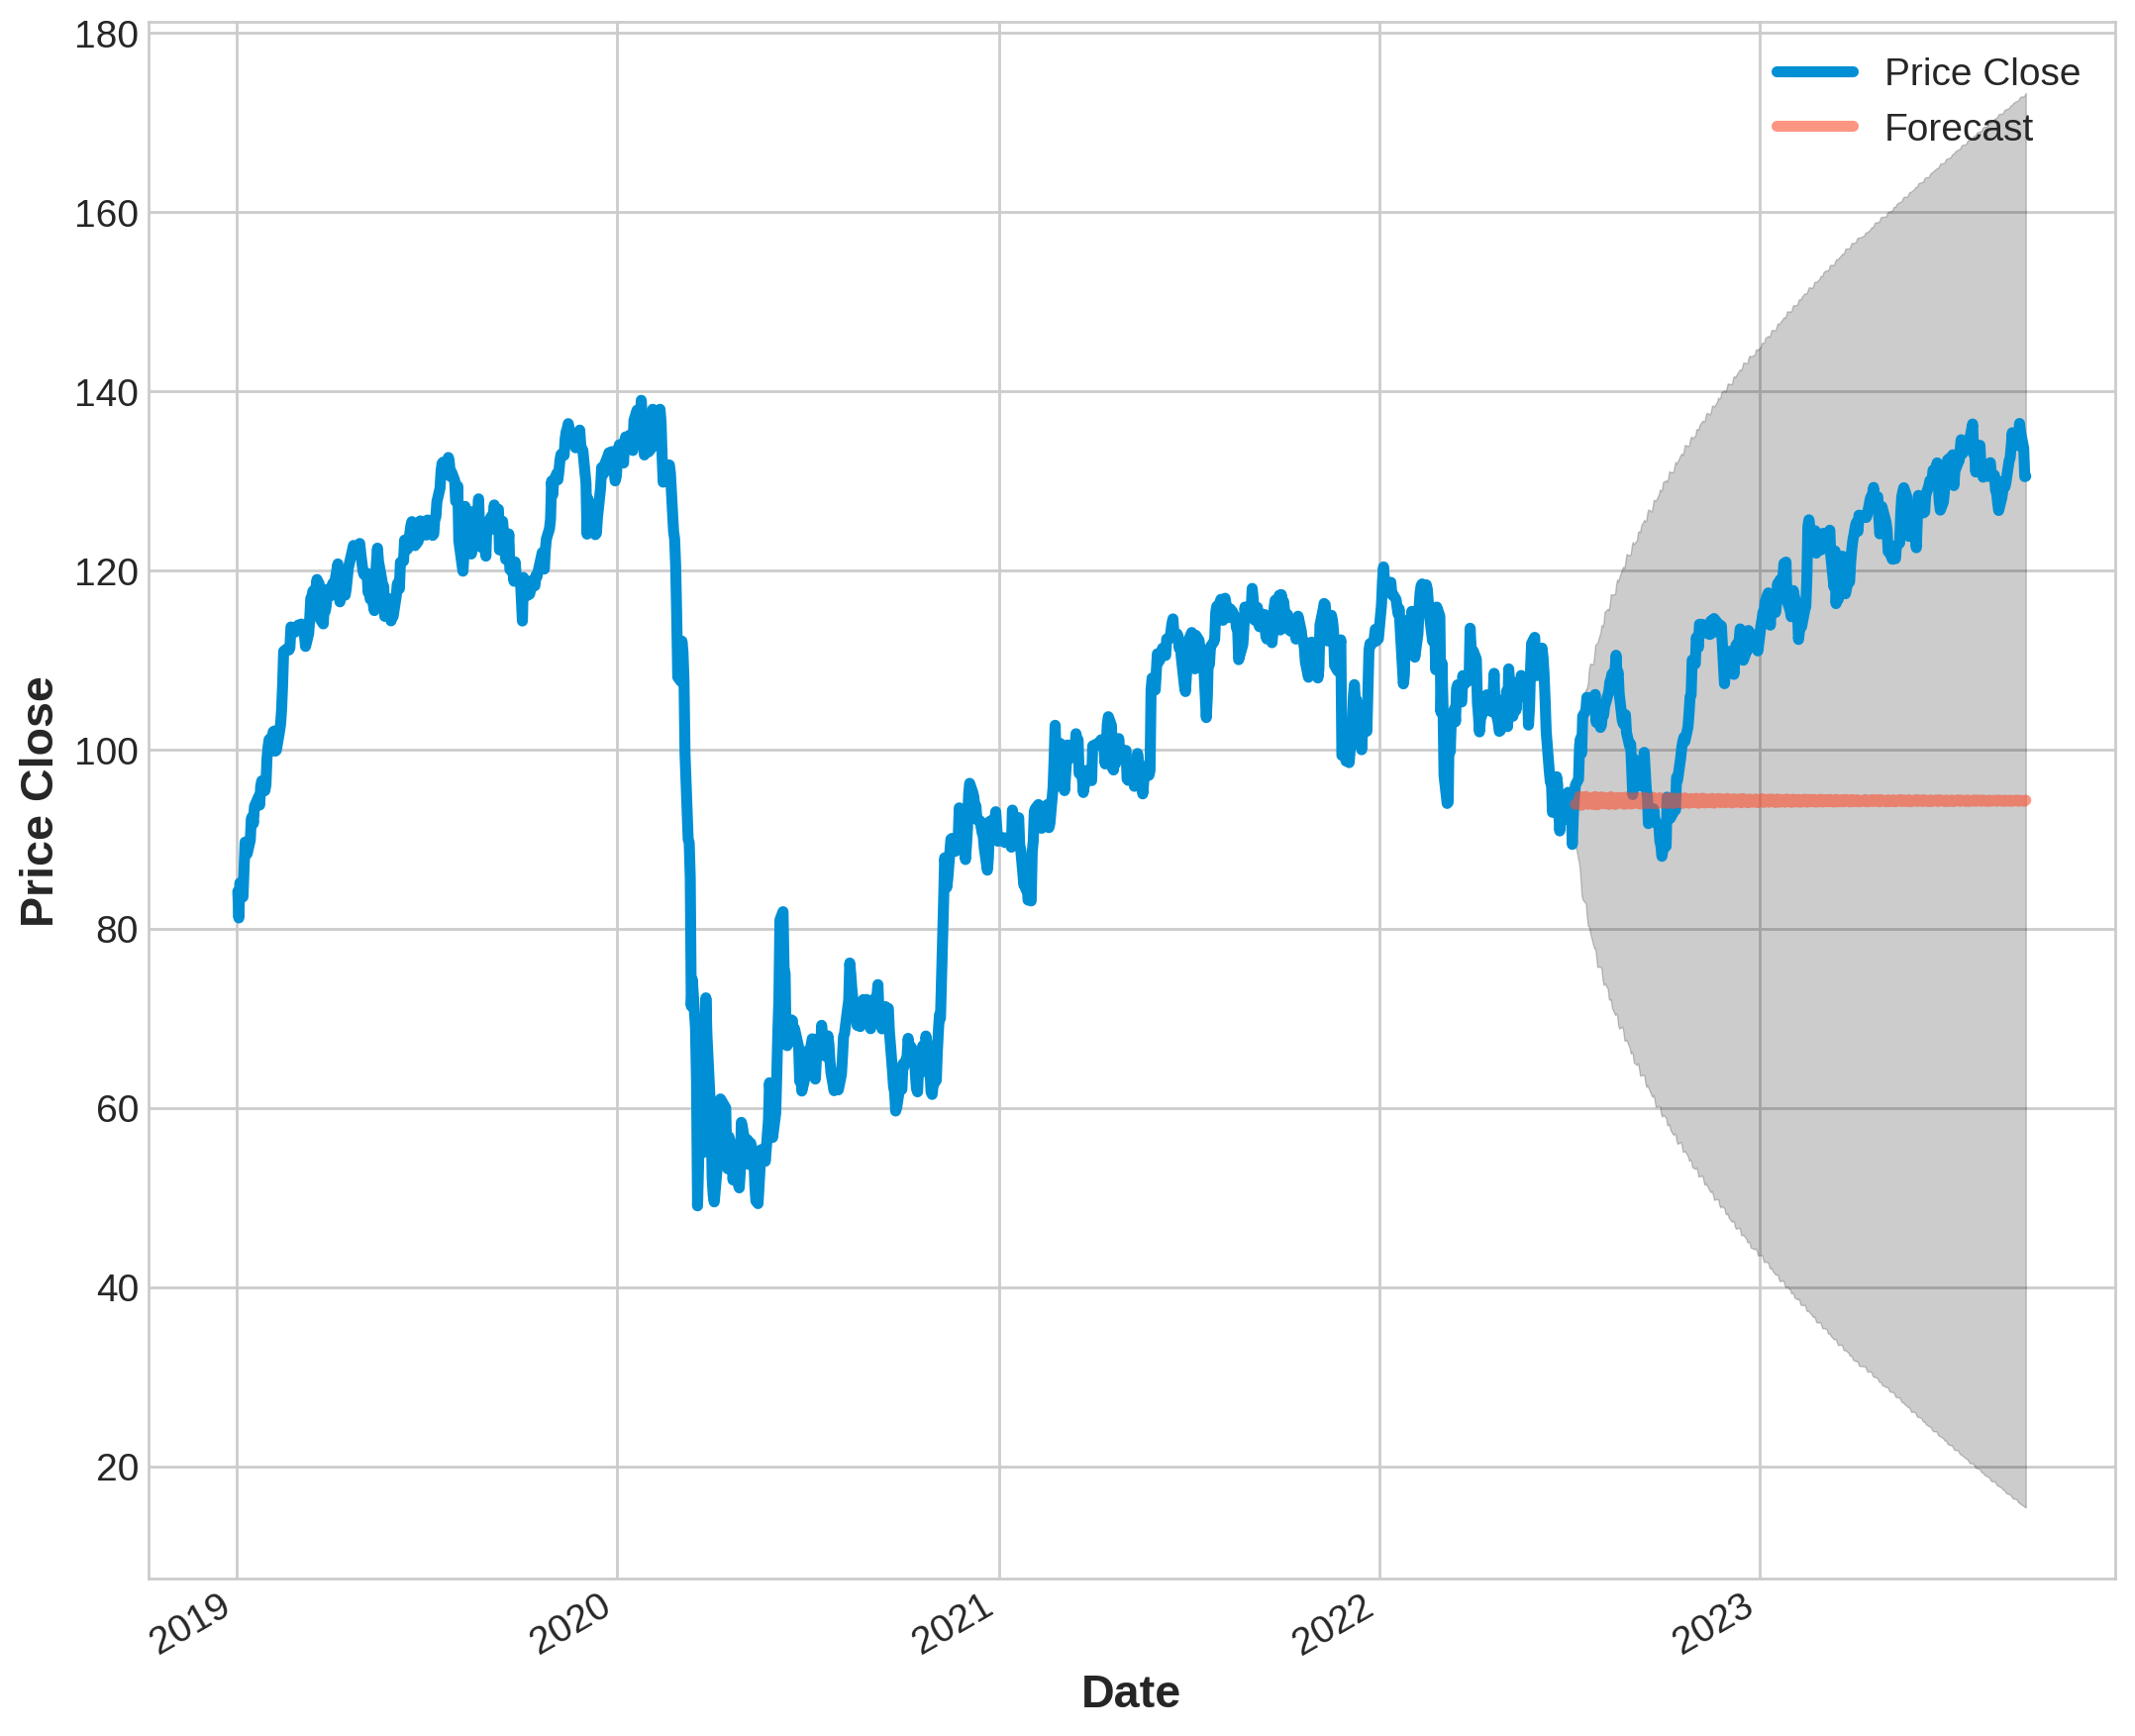

In [ ]:
pred2 = results2.get_prediction(start=902, dynamic=True)
pred_ci2 = pred2.conf_int()

ax = sim2.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci2.index, pred_ci2.iloc[:, 0], pred_ci2.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price Close')
plt.legend()

plt.show()

RMSE: 2.69



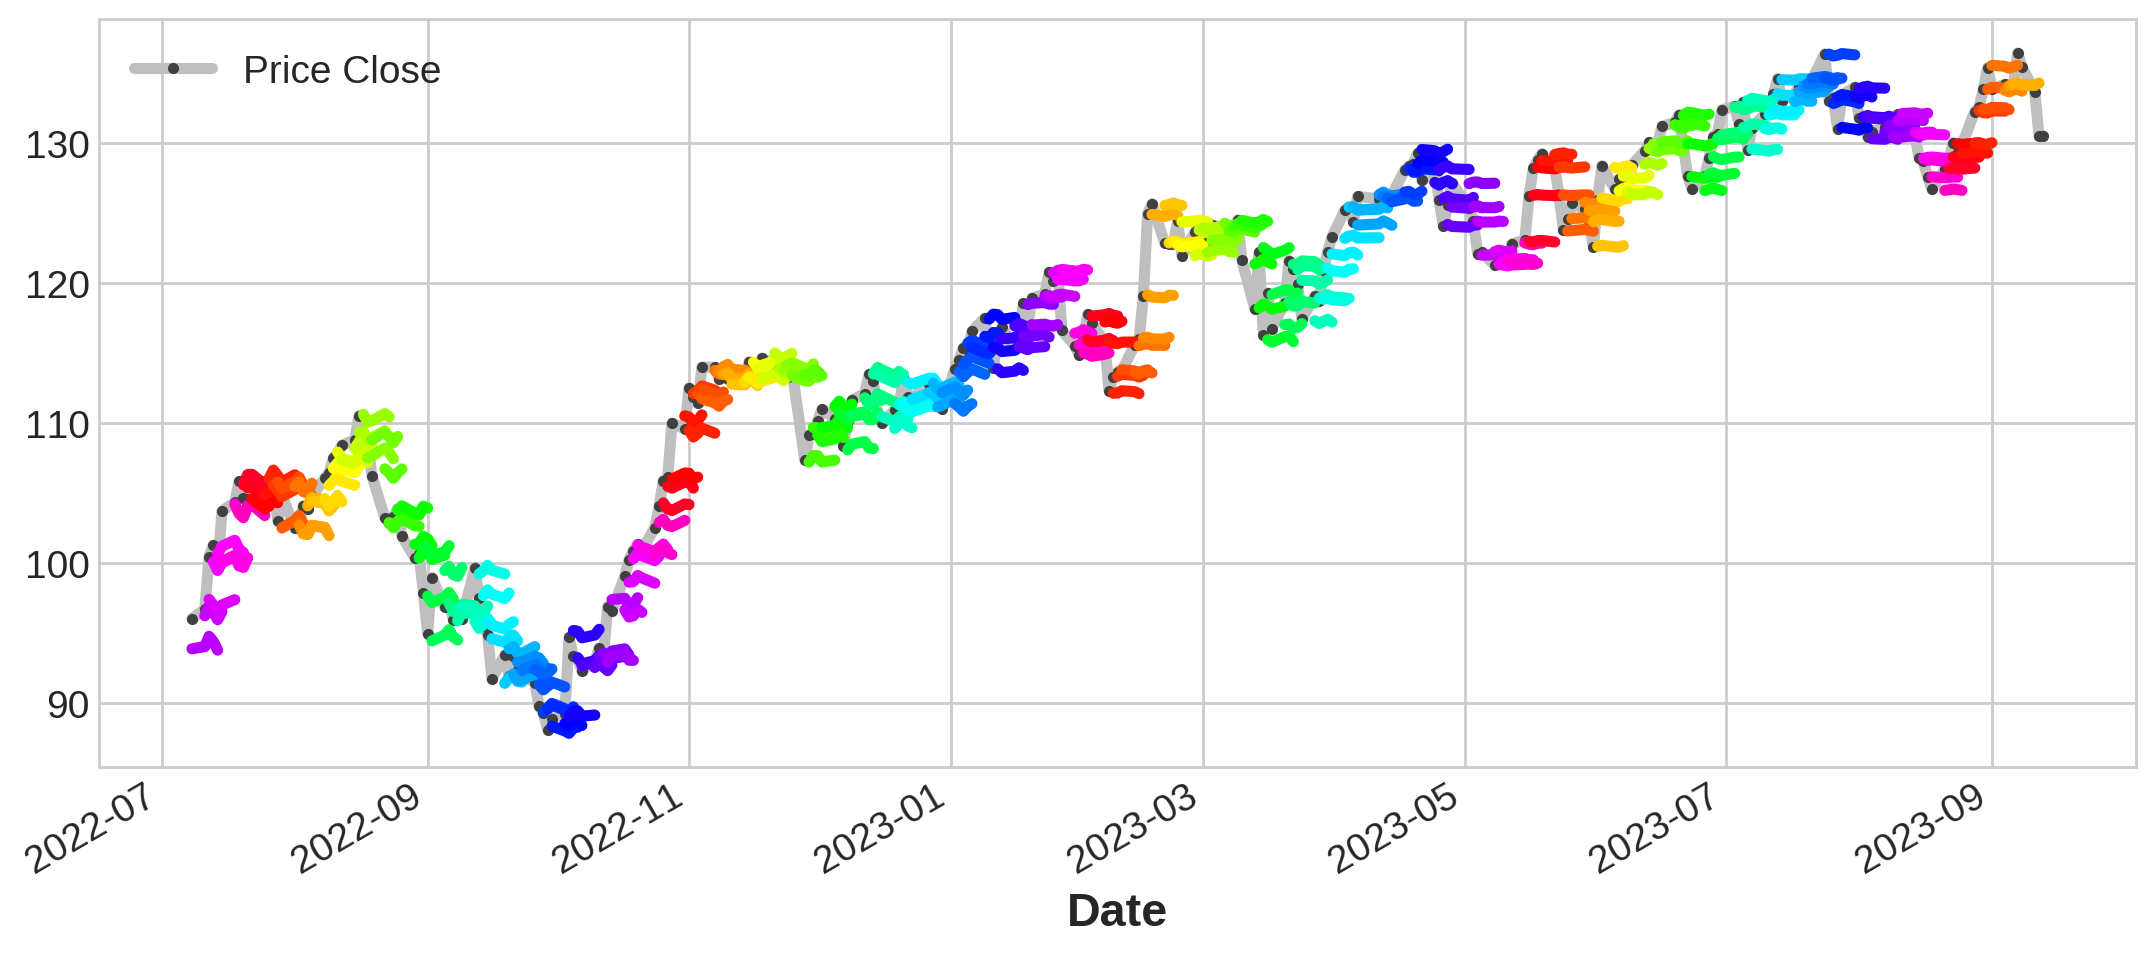

In [ ]:
y_pred = []
y_true = []
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 70))

ax1 = sim2[902:].plot(figsize=(11,5),**plot_params)
for i in range(902, 1202):
    pred2 = results2.predict(i,i+4,dynamic=True)
    y_pred.append(pred2.to_list())
    y_true.append(sim2['Price Close'][i:i+5].to_list())
    pred2.plot(ax=ax1, color=colors[i%70])
rmse1 = mean_squared_error(y_true, y_pred,squared=False)
print(f"RMSE: {rmse1:.2f}\n")

## Linear Regression

In [ ]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
y = sim2.copy()
X = make_lags(y, lags=7).dropna()
X['Covid19'] = (X.index >= '2020-03-13').astype(int)

In [ ]:
X

y_lag_1     y_lag_2     y_lag_3     y_lag_4  \
                          Price Close Price Close Price Close Price Close   
Date                                                                        
2019-01-11 00:00:00+00:00       89.61       89.68       86.65       83.56   
2019-01-14 00:00:00+00:00       88.38       89.61       89.68       86.65   
2019-01-15 00:00:00+00:00       89.91       88.38       89.61       89.68   
2019-01-16 00:00:00+00:00       92.31       89.91       88.38       89.61   
2019-01-17 00:00:00+00:00       92.54       92.31       89.91       88.38   
...                               ...         ...         ...         ...   
2023-09-07 00:00:00+00:00      133.94      134.10      134.18      133.86   
2023-09-08 00:00:00+00:00      136.42      133.94      134.10      134.18   
2023-09-11 00:00:00+00:00      135.44      136.42      133.94      134.10   
2023-09-12 00:00:00+00:00      133.66      135.44      136.42      133.94   
2023-09-13 00:00:00+00:00      130.48      133.66      135.44      136.42   

                              y_lag_5     y_lag_6     y_lag_7 Covid19  
                          Price Close Price Close Price Close          
Date                                                                   
2019-01-11 00:00:00+00:00       85.12       81.21       84.17       0  
2019-01-14 00:00:00+00:00       83.56       85.12       81.21       0  
2019-01-15 00:00:00+00:00       86.65       83.56       85.12       0  
2019-01-16 00:00:00+00:00       89.68       86.65       83.56       0  
2019-01-17 00:00:00+00:00       89.61       89.68       86.65       0  
...                               ...         ...         ...     ...  
2023-09-07 00:00:00+00:00      135.38      133.84      132.56       1  
2023-09-08 00:00:00+00:00      133.86      135.38      133.84       1  
2023-09-11 00:00:00+00:00      134.18      133.86      135.38       1  
2023-09-12 00:00:00+00:00      134.10      134.18      133.86       1  
2023-09-13 00:00:00+00:00      133.94      134.10      134.18       1  

[1200 rows x 8 columns]

In [ ]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
y = make_multistep_target(y, steps=5).dropna()

In [ ]:
y

y_step_1    y_step_2    y_step_3    y_step_4  \
                          Price Close Price Close Price Close Price Close   
Date                                                                        
2019-01-02 00:00:00+00:00       84.17       81.21       85.12       83.56   
2019-01-03 00:00:00+00:00       81.21       85.12       83.56       86.65   
2019-01-04 00:00:00+00:00       85.12       83.56       86.65       89.68   
2019-01-07 00:00:00+00:00       83.56       86.65       89.68       89.61   
2019-01-08 00:00:00+00:00       86.65       89.68       89.61       88.38   
...                               ...         ...         ...         ...   
2023-09-01 00:00:00+00:00      133.86      134.18      134.10      133.94   
2023-09-04 00:00:00+00:00      134.18      134.10      133.94      136.42   
2023-09-05 00:00:00+00:00      134.10      133.94      136.42      135.44   
2023-09-06 00:00:00+00:00      133.94      136.42      135.44      133.66   
2023-09-07 00:00:00+00:00      136.42      135.44      133.66      130.48   

                             y_step_5  
                          Price Close  
Date                                   
2019-01-02 00:00:00+00:00       86.65  
2019-01-03 00:00:00+00:00       89.68  
2019-01-04 00:00:00+00:00       89.61  
2019-01-07 00:00:00+00:00       88.38  
2019-01-08 00:00:00+00:00       89.91  
...                               ...  
2023-09-01 00:00:00+00:00      136.42  
2023-09-04 00:00:00+00:00      135.44  
2023-09-05 00:00:00+00:00      133.66  
2023-09-06 00:00:00+00:00      130.48  
2023-09-07 00:00:00+00:00      130.52  

[1203 rows x 5 columns]

In [ ]:
y, X = y.align(X, join='inner', axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 4.16
Test RMSE: 2.75


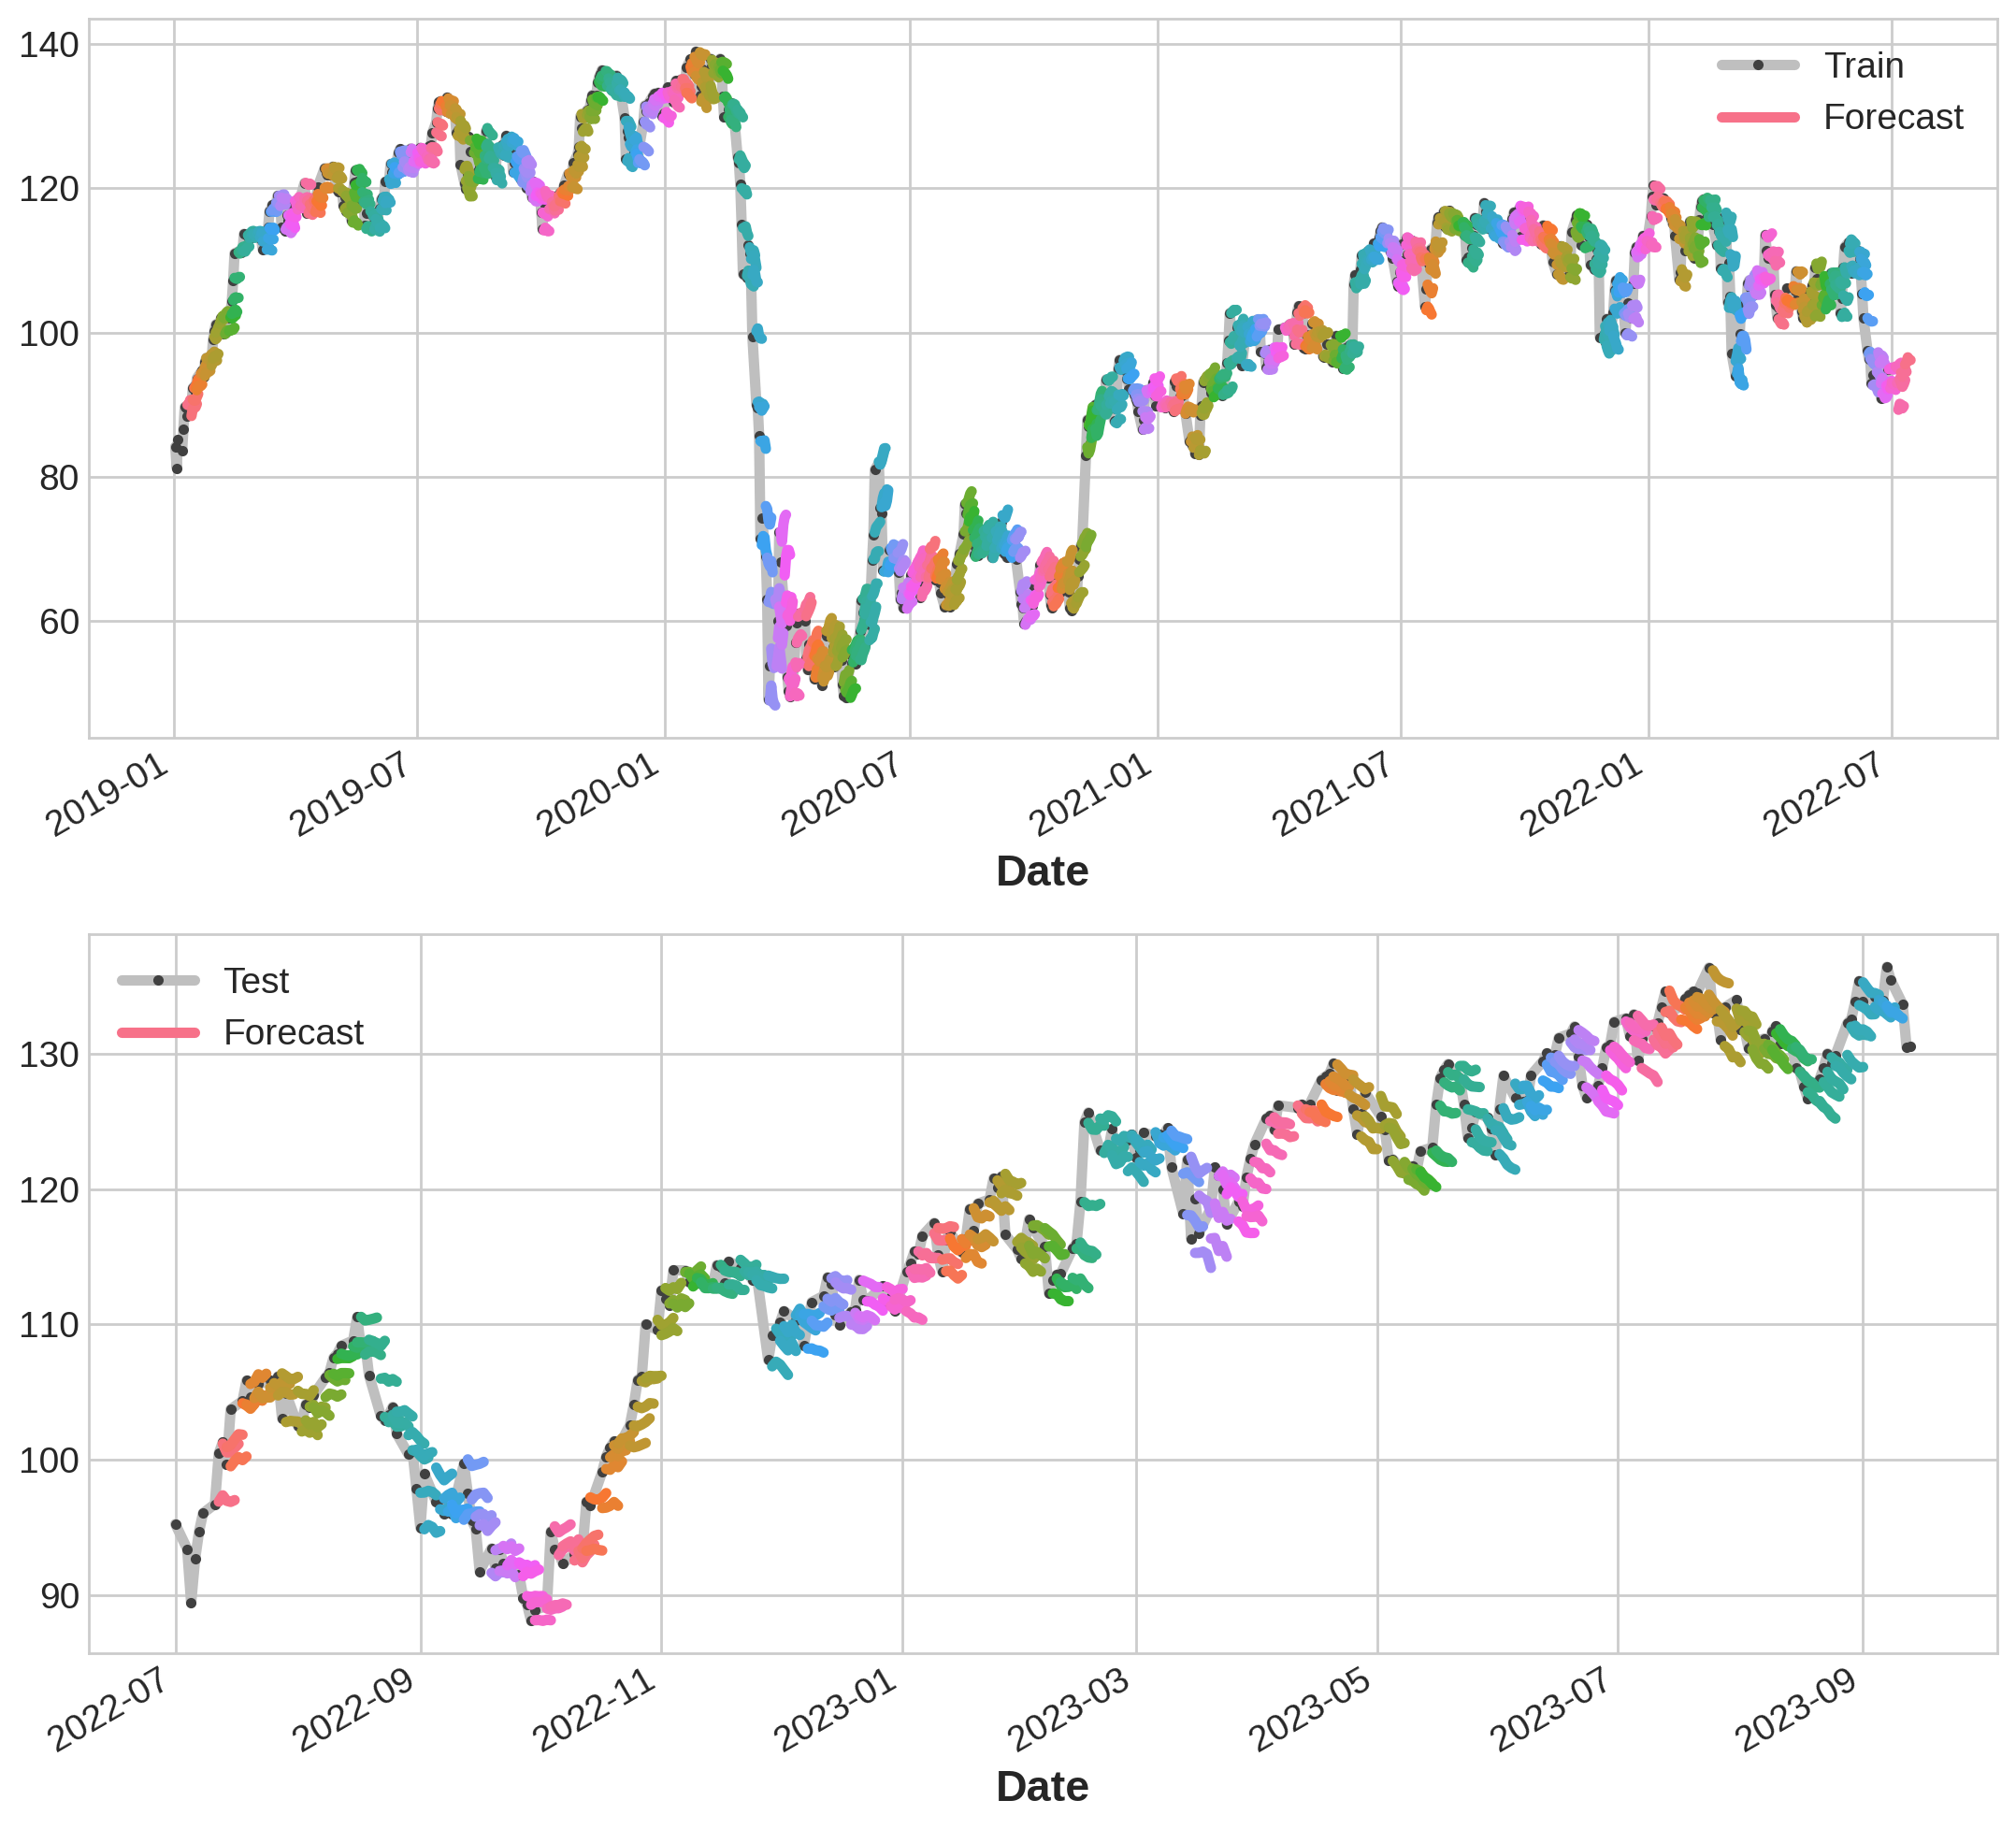

In [ ]:
train_rmse1 = mean_squared_error(y_train, y_fit, squared=False)
test_rmse1 = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse1:.2f}\n" f"Test RMSE: {test_rmse1:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10))
ax1 = sim2[:len(y_fit)].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Train', 'Forecast'])
ax2 = sim2[len(y_fit):].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Test', 'Forecast'])

## XGBoost

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor(
        learning_rate=0.008,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1.0,
        gamma=0,
        objective='reg:squarederror',
        eval_metric='rmse',
        verbose=1
))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
train_rmse2 = mean_squared_error(y_train, y_fit, squared=False)
test_rmse2 = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse2:.2f}\n" f"Test RMSE: {test_rmse2:.2f}"))

Train RMSE: 1.96
Test RMSE: 3.29


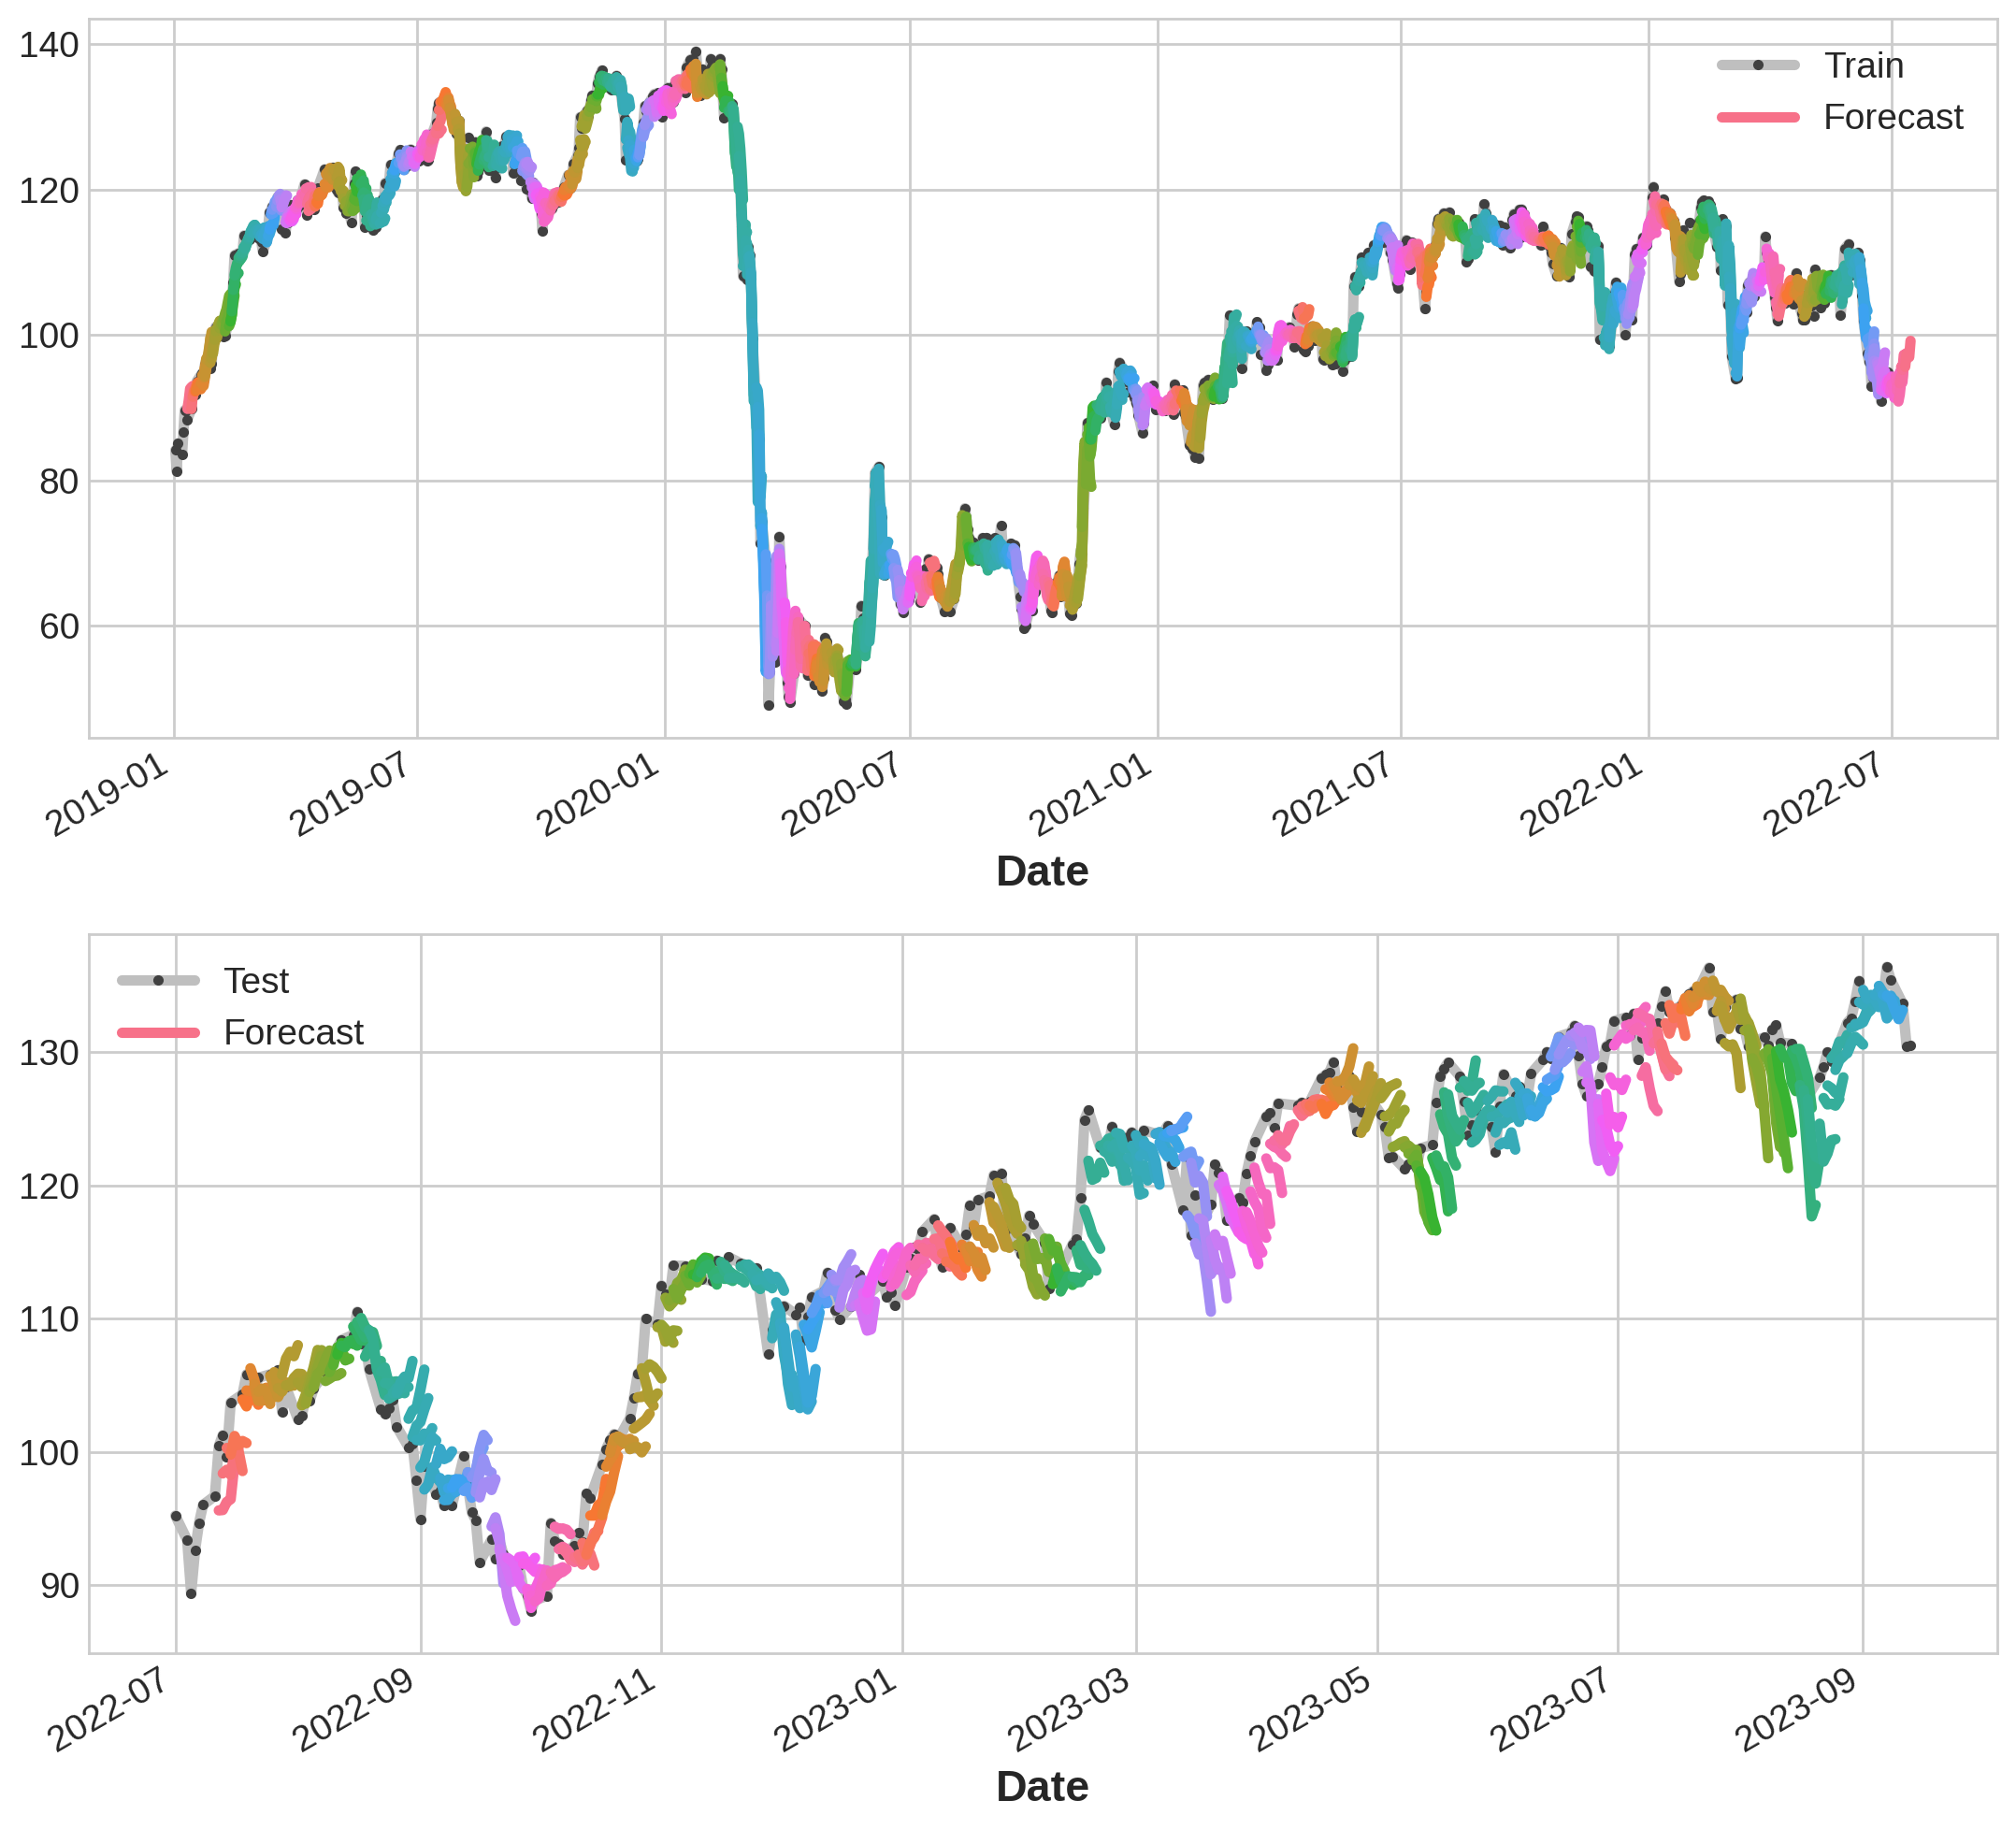

In [ ]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10))
ax1 = sim2[:len(y_fit)].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Train', 'Forecast'])
ax2 = sim2[len(y_fit):].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Test', 'Forecast'])

# Model Evaluation

In [ ]:
eva = pd.DataFrame()
eva['Model'] = ['ARIMA','Linear Regression','XGBoost']
eva['RMSE'] = [rmse1,test_rmse1,test_rmse2]
fig = sns.barplot(data=eva,y='RMSE',x='Model')
fig.set_ylim(2.5,3.5)
for i in fig.containers:
    fig.bar_label(i,)
plt.title('RMSE of 3 Models')
plt.show()

# LSTM

In [ ]:
data = sim2.copy()
data = data.values.squeeze()
data

array([ 84.17,  81.21,  85.12, ..., 133.66, 130.48, 130.52])

In [ ]:


# 生成题目所需的训练集合
def generate_data(data):
    # 记录 data 的长度
    n = data.shape[0]

    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []

    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i - 15: i - 1])
        y.append(data[i - 1])

    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)

    return x, y


x, y = generate_data(data)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 将 y 转化形状
y = torch.unsqueeze(y, dim=1)
print(x.shape, y.shape)

# 样本总数
num_samples = x.shape[0]
num_train = round(num_samples * 0.8)
num_valid = round(num_samples * 0.1)
num_test = num_samples - num_train - num_valid

dataset = Data.TensorDataset(x, y)
train_data, valid_data, test_data = Data.random_split(dataset, (num_train, num_valid, num_test))

batch_size = 512
train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=False)


def compute_mae(y_hat, y):
    """
    :param y_hat: 用户的预测值
    :param y: 标准值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    """
    return torch.mean(torch.abs(y_hat - y))


def compute_mape(y_hat, y):
    """
    :param y_hat: 用户的预测值
    :param y: 标准值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    """
    return torch.mean(torch.abs(y_hat - y)/y)


def evaluate_accuracy(data_loader, model):
    """
    :param data_loader: 输入的 DataLoader
    :param model: 用户的模型
    :return: 对应的 MAE 和 MAPE
    """
    # 初始化参数
    mae_sum, mape_sum, n = 0.0, 0.0, 0

    # 对每一个 data_iter 的每一个 x,y 进行计算
    for x, y in data_loader:
        x = x.to(device)
        # 计算模型得出的 y_hat
        y_hat = model(x)

        # 计算对应的 MAE 和 RMSE 对应的和，并乘以 batch 大小
        mae_sum += compute_mae(y_hat, y) * y.shape[0]
        mape_sum += compute_mape(y_hat, y) * y.shape[0]

        # n 用于统计 DataLoader 中一共有多少数量
        n += y.shape[0]

    # 返回时需要除以 batch 大小，得到平均值
    return mae_sum / n, mape_sum / n

torch.Size([1192, 14]) torch.Size([1192, 1])


In [ ]:
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1
# 隐藏层的个数
num_hiddens = 128


In [ ]:

# 建立一个稍微复杂的 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=num_hiddens,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(num_hiddens, num_outputs)

    def forward(self, x):
        x = x.view(x.shape[0], -1, 1)
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.fc(r_out[:, -1, :])  # 只需要最后一个的output
        return out


lstm = LSTM(num_hiddens, num_outputs).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)


# 用于绘图用的信息
train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes = [], [], [], [], [], []

# 循环 num_epochs 次
epochs = 2000
for epoch in range(epochs):
    # 初始化参数
    train_l_sum, n = 0.0, 0
    # 初始化时间
    start = time.time()

    lstm.train()

    # 对训练数据集的每个 batch 执行
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        n += y.shape[0]

    # 模型开启预测状态
    lstm.eval()

    # 同样的，我们可以计算验证集上的 loss
    valid_l_sum, valid_n = 0, 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)

        # 对 loss 求和（在下面打印出来）
        valid_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        valid_n += y.shape[0]

    # 对验证集合求指标
    # 这里训练集其实可以在循环内高效地直接算出，这里为了代码的可读性牺牲了效率
    train_mae, train_mape = evaluate_accuracy(train_loader, lstm)
    valid_mae, valid_mape = evaluate_accuracy(valid_loader, lstm)
    if (epoch + 1) % 100 == 0:
        print(
            'epoch %d, train loss %.6f, valid loss %.6f, train mae %.6f, mape %.6f, valid mae %.6f,mape %.6f, time %.2f sec'
            % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mae, train_mape, valid_mae, valid_mape,
               time.time() - start))

    # 记录绘图有关的信息
    train_losses.append(train_l_sum / n)
    valid_losses.append(valid_l_sum / valid_n)
    train_maes.append(train_mae.item())
    train_mapes.append(train_mape.item())
    valid_maes.append(valid_mae.item())
    valid_mapes.append(valid_mape.item())


epoch 100, train loss 6069.253088, valid loss 6038.599064, train mae 74.859467, mape 0.688796, valid mae 74.859474,mape 0.688796, time 0.55 sec
epoch 200, train loss 3185.220081, valid loss 3169.412481, train mae 52.372845, mape 0.466580, valid mae 52.372845,mape 0.466580, time 0.55 sec
epoch 300, train loss 1664.739373, valid loss 1656.543710, train mae 37.063461, mape 0.329795, valid mae 37.063465,mape 0.329795, time 0.76 sec
epoch 400, train loss 832.972806, valid loss 828.489611, train mae 24.701622, mape 0.212482, valid mae 24.701622,mape 0.212482, time 0.55 sec
epoch 500, train loss 406.100175, valid loss 403.683274, train mae 16.017002, mape 0.135390, valid mae 16.017002,mape 0.135390, time 0.54 sec
epoch 600, train loss 202.610409, valid loss 201.524661, train mae 10.497551, mape 0.087971, valid mae 10.497550,mape 0.087971, time 0.77 sec
epoch 700, train loss 109.225747, valid loss 108.716241, train mae 7.143804, mape 0.059688, valid mae 7.143804,mape 0.059688, time 0.76 sec
ep

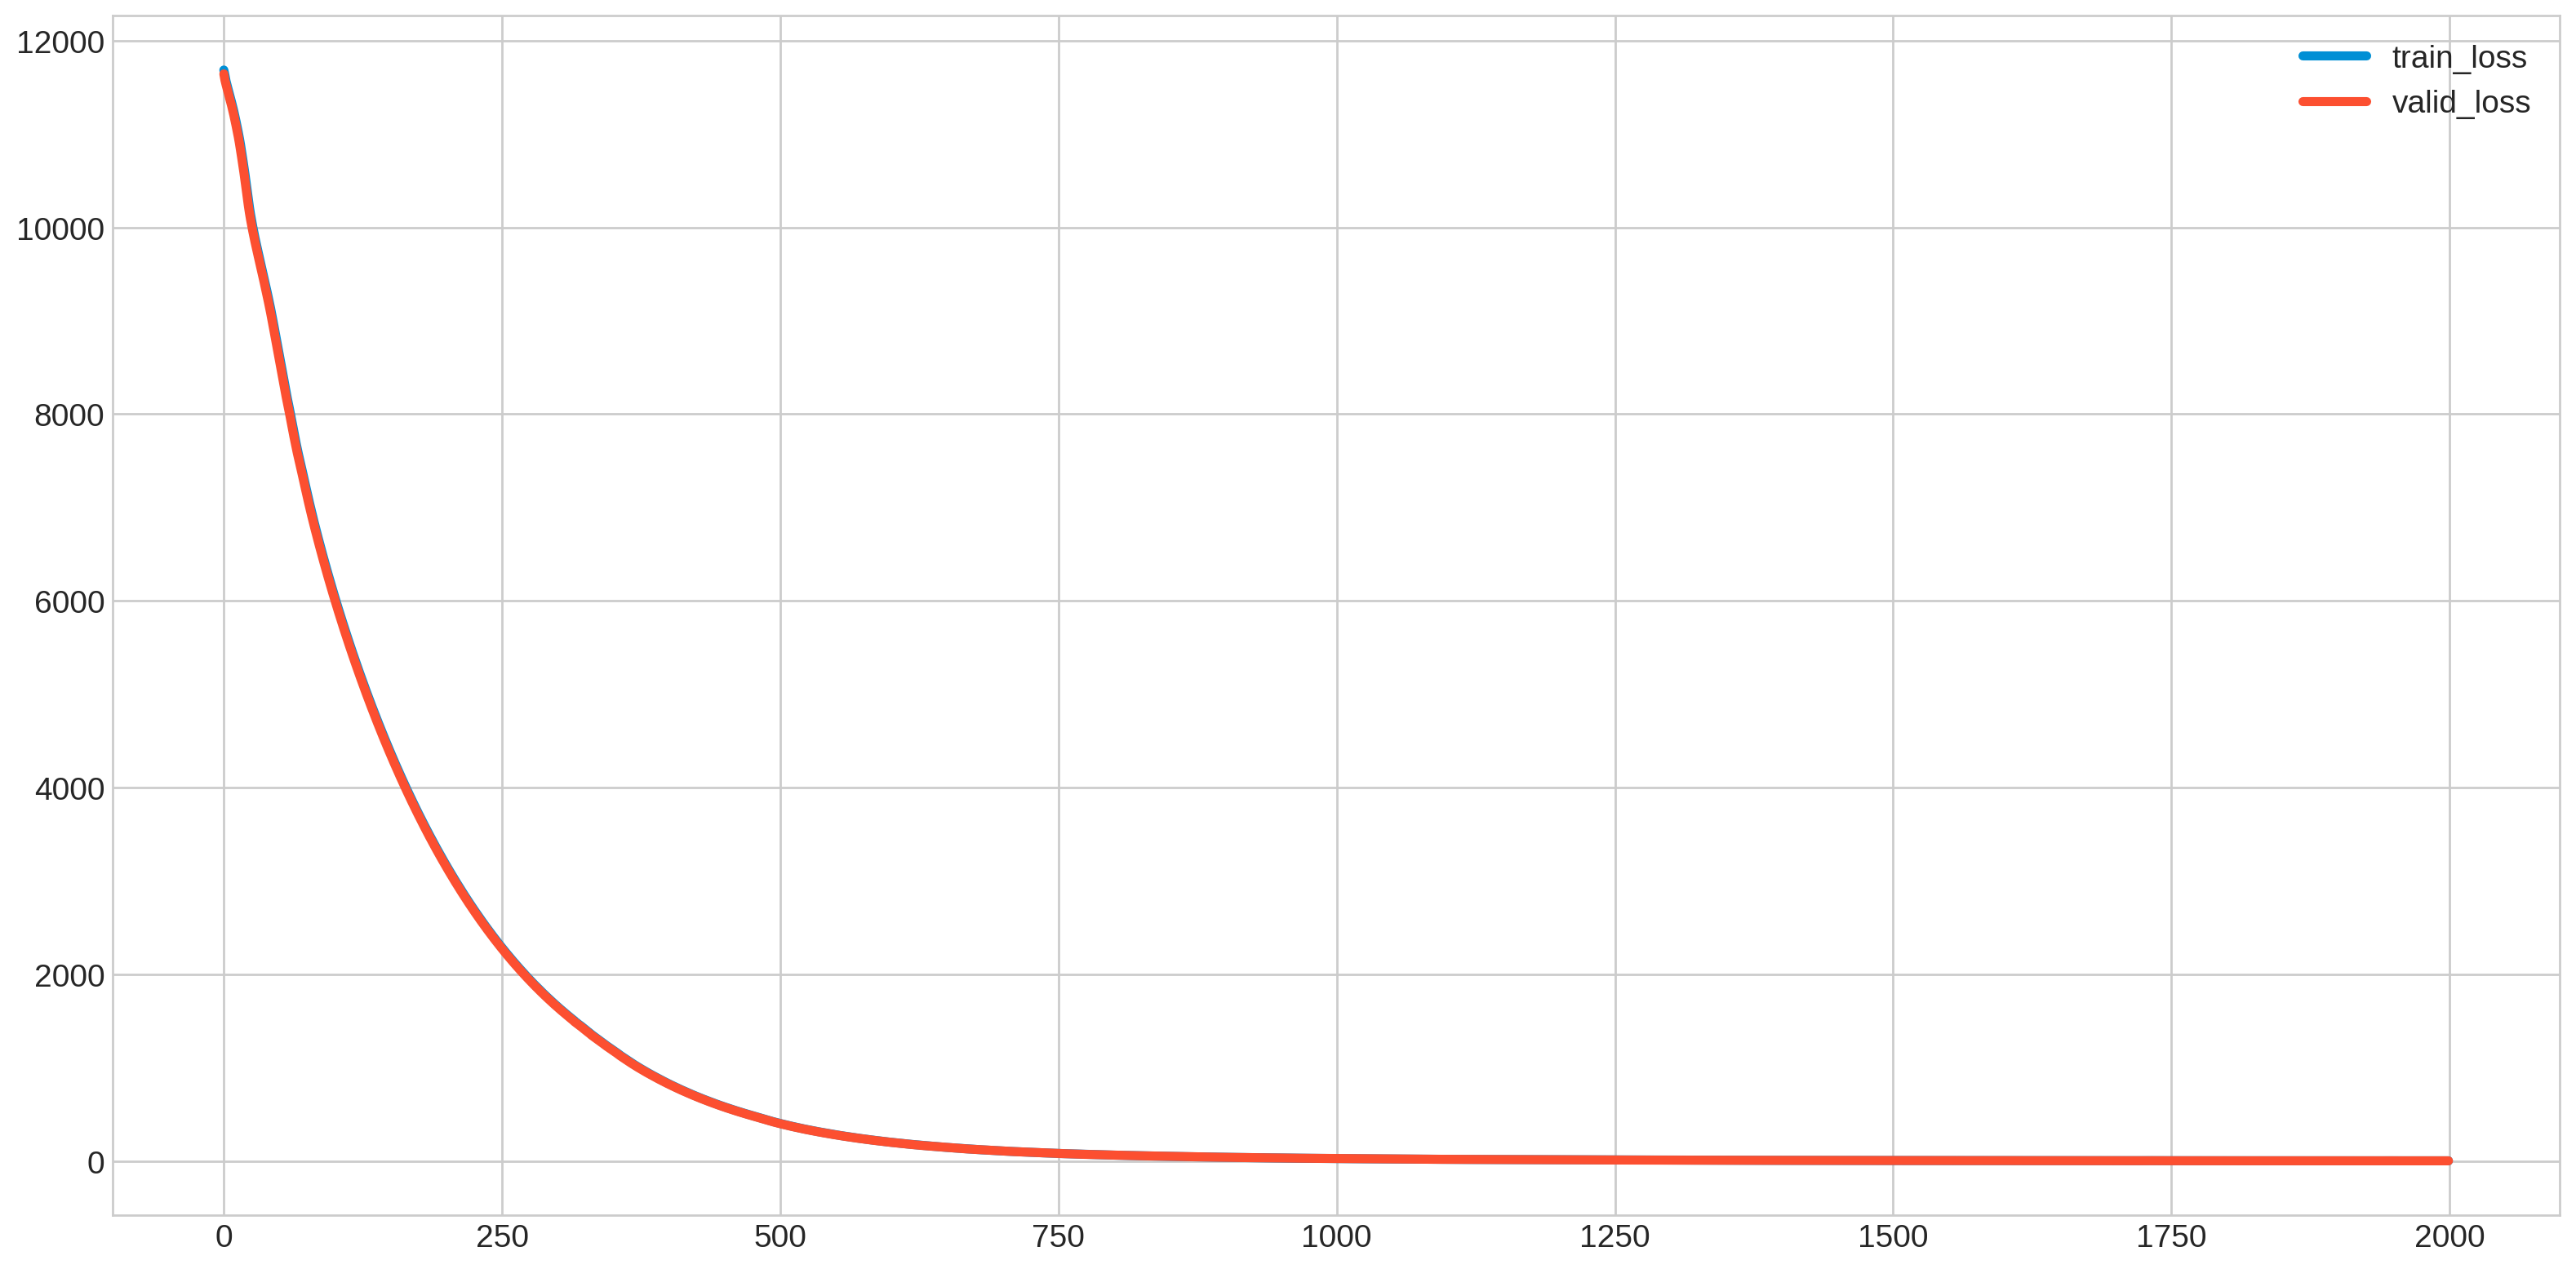

In [ ]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘制 train_loss 曲线
plt.plot(train_losses, label='train_loss')

# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')

# 展示带标签的图像
plt.legend()

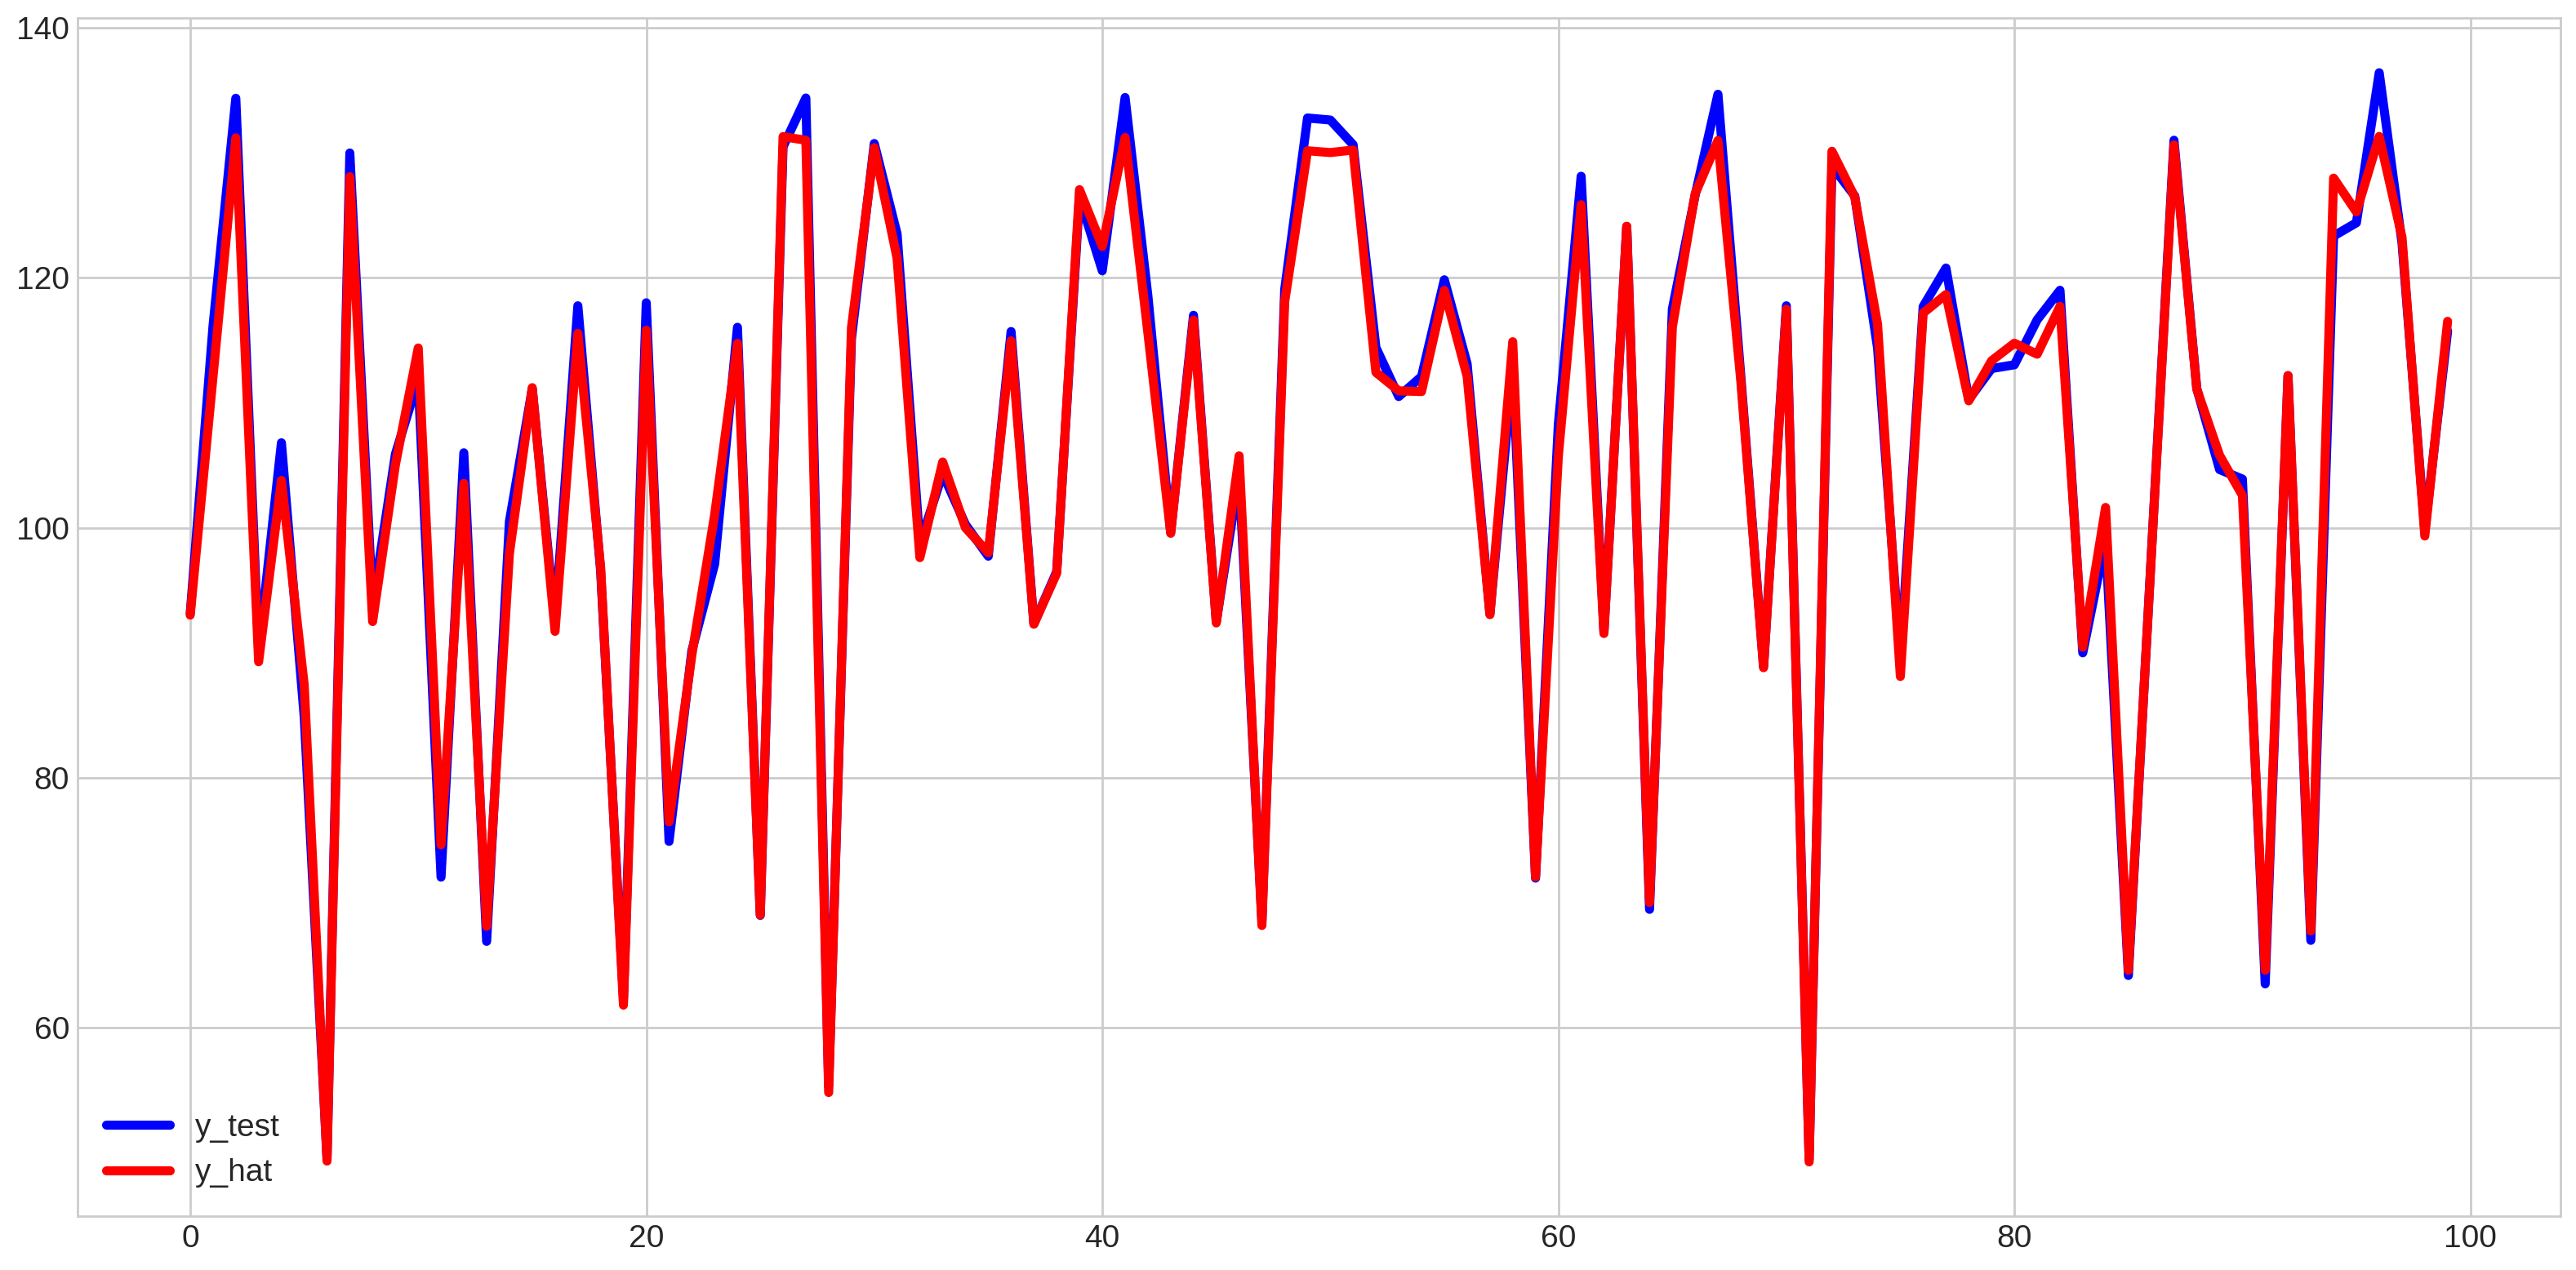

In [ ]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 预测结果
x_test, y_test, y_hat = [], [], []
for b_x, b_y in test_loader:
    b_x = b_x.to(device)
    y_pred = lstm(b_x).detach().cpu()
    y_test += list(b_y)
    y_hat += list(y_pred)

# 绘画某些结点第一天的情况
plt.plot(y_test[: 100], c='blue', label='y_test')
plt.plot(y_hat[: 100], c='red', label='y_hat')

# 展示图像
plt.legend()